#OPIM-5509-Introduction to Deep Learning-SECB12-1213
#University of Connecticut, Spring 2021 <br>
#Dr. Dave Wanik

##***Project 3: Texas Energy Demand Forecasting***




Saivalini Durvasula - (2887062)



# ***Introduction***

When the summer heat peaks in Texas, the familiar hum of air conditioners across the state grows a little louder, and the demand for electricity on the state’s grid shoots up. During the Summer of 2020, as temperatures soared past 100 degrees across the state, the grid reached a new record demand: 74,531 megawatts of electricity in one hour. That beat last year’s record—which was set during the state’s fifth hottest summer on record—by 1,000 megawatts, the equivalent of powering 200,000 homes for the day. This strain on the system prompted the Electric Reliability Council of Texas (ERCOT), the state’s grid operator, to issue an emergency alert urging customers to reduce their electricity consumption during the hottest part of the day.[4][5]

Similarly, Two back-to-back frigid winter storms swept across Texas—one from February 10–11 and the second from February 13–17, 2021—during which recorded temperatures reached record-setting lows. At the peak of one of the storms, the Dallas-Fort Worth airport reported a temperature at -2 °F, the coldest on record in North Texas in 72 years. The frigid weather event saw 4.4 million people without power at one point and caused many to lose water. In addition, cell phone signals were lost in some rural areas. The storms are connected to the deaths of at least 36 Texans.[1]

As the state’s grid had low reserve margins or no extra supply and since the customers needed more electricity than predicted ERCOT needed to initiate rolling blackouts to prevent a larger, more dangerous power outage. Additionally, researchers estimate that climate change could drive up global energy demand by as much as 58 percent in the next 30 years and hence Accurate forecasts for electricity demand are important for electric utilities and regional transmission organizations and is definitely the need of the hour.[3]

Long-term forecasts can reduce investment risk, medium-term forecasts help in planning fuel purchases and scheduling plant maintenance, and short-term forecasts are essential in matching electricity generation and demand for grid reliability. This project focuses on high to medium-term forecasting, specifically making one-year forecasts at a resolution of one hour for Austin, Texas. Historical electricity demand and weather data from 2011-2014 is used. A combination of time series analysis and neural network  models (RNN)  are used to make forecasting predictions, which are compared against the observed hourly electricity demand for a series of one-year intervals.


# ***Variable Description***

**Energy Data**

Date: date of the observation

HE: hour of the observation (from 1 to 24)

MWh: energy demand at that timestamp




**Weather Data**

station:
three or four character site identifier

valid:
timestamp of the observation

tmpf:
Air Temperature in Fahrenheit, typically @ 2 meters

dwpf:
Dew Point Temperature in Fahrenheit, typically @ 2 meters

relh:
Relative Humidity in %

drct:
Wind Direction in degrees from *true* north

sknt:
Wind Speed in knots

p01i:
One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.

alti:
Pressure altimeter in inches

mslp:
Sea Level Pressure in millibar

vsby:
Visibility in miles

gust:
Wind Gust in knots

skyc1:
Sky Level 1 Coverage

skyc2:
Sky Level 2 Coverage

skyc3:
Sky Level 3 Coverage

skyc4:
Sky Level 4 Coverage

skyl1:
Sky Level 1 Altitude in feet

skyl2:
Sky Level 2 Altitude in feet

skyl3:
Sky Level 3 Altitude in feet

skyl4:
Sky Level 4 Altitude in feet

wxcodes:
Present Weather Codes (space seperated)

feel:
Apparent Temperature (Wind Chill or Heat Index) in Fahrenheit

ice_accretion_1hr:
Ice Accretion over 1 Hour (inches)

ice_accretion_3hr:
Ice Accretion over 3 Hours (inches)

ice_accretion_6hr:
Ice Accretion over 6 Hours (inches)

peak_wind_gust:
Peak Wind Gust (from PK WND METAR remark) (knots)

peak_wind_drct:
Peak Wind Gust Direction (from PK WND METAR remark) (deg)

peak_wind_time:
Peak Wind Gust Time (from PK WND METAR remark)

metar:
unprocessed reported observation in METAR format

# ***Data Cleaning and Resampling***

## Reading the data


Importing required modules

In [ ]:
# Importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

## Demand Data

Read the demand data.

In [ ]:
# https://drive.google.com/file/d/1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9/view?usp=sharing
!gdown --id 1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9

Downloading...
From: https://drive.google.com/uc?id=1M7-XiHcfboUzKZ-tmflDomy_IuRAvnw9
To: /content/Ercot_2011_2021_feb.csv
3.52MB [00:00, 54.2MB/s]


In [ ]:
energy = pd.read_csv('Ercot_2011_2021_feb.csv') # it just downloaded locally to your workspace!
energy.head()

Unnamed: 0        Date  HE           MWh
0           0  2010-01-01   1  32094.064435
1           1  2010-01-01   2  32171.322546
2           2  2010-01-01   3  32241.752463
3           3  2010-01-01   4  32459.193227
4           4  2010-01-01   5  33123.751047

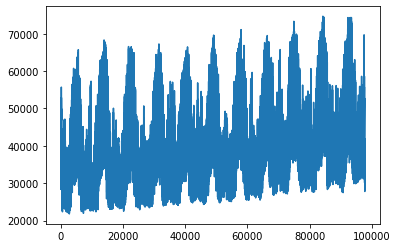

In [ ]:
# this is your target variable
energy['MWh'].plot()

Pretty cool - looks like energy variabes between 20K and 70K megawatts.

In [ ]:
print(energy['Date'].min())
print(energy['Date'].max())

2010-01-01
2021-03-01


The data is ranging from 2010 to 2021 but we only need 2011-2014 data for training and 2015 for test. So, the data will be sampled accordingly in further steps.

In [ ]:
# Information about demand data
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97848 entries, 0 to 97847
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  97848 non-null  int64  
 1   Date        97848 non-null  object 
 2   HE          97848 non-null  int64  
 3   MWh         97847 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.0+ MB


So, it has 97848 rows and 4 columns.

### Data cleaning for demand data

In [ ]:
# Dropping the 'Unnamed: 0' column, as it would not be useful
energy.drop('Unnamed: 0', axis=1, inplace=True)
energy.head()

Date  HE           MWh
0  2010-01-01   1  32094.064435
1  2010-01-01   2  32171.322546
2  2010-01-01   3  32241.752463
3  2010-01-01   4  32459.193227
4  2010-01-01   5  33123.751047

In [ ]:
# Creating one single date-time column from date and hours (HE)
energy['Date'] = pd.to_datetime(energy.Date) + pd.to_timedelta(energy.HE, unit='h')
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97848 entries, 0 to 97847
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    97848 non-null  datetime64[ns]
 1   HE      97848 non-null  int64         
 2   MWh     97847 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.2 MB


In [ ]:
# Dropping 'HE' column
energy.drop('HE', axis=1, inplace=True)
energy.head()

Date           MWh
0 2010-01-01 01:00:00  32094.064435
1 2010-01-01 02:00:00  32171.322546
2 2010-01-01 03:00:00  32241.752463
3 2010-01-01 04:00:00  32459.193227
4 2010-01-01 05:00:00  33123.751047

### Sampling the demand data

In [ ]:
# Sampling the data to extract the records between 2011 to 2014
sample_energy = energy.loc[(energy['Date'] >= '2011-01-01') & (energy['Date'] < '2015-01-01')]
sample_energy.head()

Date           MWh
8759 2011-01-01 00:00:00  28496.388850
8760 2011-01-01 01:00:00  27662.443480
8761 2011-01-01 02:00:00  27250.044715
8762 2011-01-01 03:00:00  26783.226081
8763 2011-01-01 04:00:00  26676.468490

In [ ]:
# Sampling the data to extract the records from 2015 for test data
energy_test_2015 = energy.loc[(energy['Date'] >= '2015-01-01') & (energy['Date'] < '2016-01-01')]
energy_test_2015.head()

Date           MWh
43823 2015-01-01 00:00:00  40707.660350
43824 2015-01-01 01:00:00  39624.861027
43825 2015-01-01 02:00:00  39013.544802
43826 2015-01-01 03:00:00  38566.541927
43827 2015-01-01 04:00:00  38488.338511

### Missing values in demand data

In [ ]:
sample_energy.isnull().sum()

Date    0
MWh     0
dtype: int64

In [ ]:
energy_test_2015.isnull().sum()

Date    0
MWh     0
dtype: int64

As can be seen here, there are no missing values in the sampled demand data for both train and test.

## Weather Data

Read the weather data.

In [ ]:
# https://drive.google.com/file/d/1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od/view?usp=sharing
!gdown --id 1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od

Downloading...
From: https://drive.google.com/uc?id=1vl2RKquLYS1QRyYE7ySIj24jPnXFp2od
To: /content/FST.csv
97.2MB [00:00, 209MB/s]


In [ ]:
weather = pd.read_csv('FST.csv')
weather.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


station  ...                                              metar
0     FST  ...  METAR KFST 010553Z AUTO 18005KT 10SM CLR M01/M...
1     FST  ...  METAR KFST 010653Z AUTO 19005KT 10SM CLR M02/M...
2     FST  ...  METAR KFST 010753Z AUTO 22009KT 10SM CLR M03/M...
3     FST  ...  METAR KFST 010853Z AUTO 21008KT 10SM CLR M03/M...
4     FST  ...  METAR KFST 010953Z AUTO 22012KT 10SM CLR M02/M...

[5 rows x 29 columns]

In [ ]:
# convert time stamp to datetime for interpolation
weather['valid'] = pd.to_datetime(weather['valid'], errors = "coerce")
weather.dtypes

station                      object
valid                datetime64[ns]
tmpf                         object
dwpf                         object
relh                         object
drct                         object
sknt                         object
p01i                         object
alti                         object
mslp                         object
vsby                         object
gust                         object
skyc1                        object
skyc2                        object
skyc3                        object
skyc4                        object
skyl1                        object
skyl2                        object
skyl3                        object
skyl4                        object
wxcodes                      object
ice_accretion_1hr            object
ice_accretion_3hr            object
ice_accretion_6hr            object
peak_wind_gust               object
peak_wind_drct               object
peak_wind_time               object
feel                        

In [ ]:
# look at the datetime range
print(weather['valid'].min())
print(weather['valid'].max())

2010-01-01 00:53:00
2021-02-19 23:55:00


This data will also be sampled for 2011-2014 and 2015 seperately in further steps.

In [ ]:
# set the datetime as the index so you can do interpolation later
weather.set_index(weather['valid'], inplace=True)
weather.head(1) # see how the valid column is now the index? this will allow
                # you to do resampling to hourly resolution

station  ...                                              metar
valid                        ...                                                   
2010-01-01 00:53:00     FST  ...  METAR KFST 010553Z AUTO 18005KT 10SM CLR M01/M...

[1 rows x 29 columns]

You are welcome to use all fields if you would like (not recommended), but I recommend you focus on:
* tmpf
*	dwpf
*	relh

Since these are the three variables that determine who turns on their heat or airconditioner. You should coerce these three variables to numeric (the missing values are currently coded as 'M'), which is why the data type is object right now.

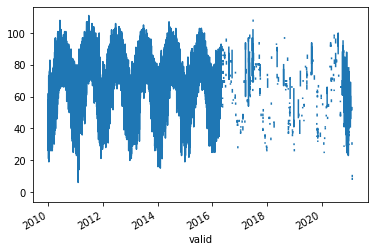

In [ ]:
weather['tmpf'] = pd.to_numeric(weather['tmpf'], errors='coerce')
weather['tmpf'].plot()

### Data cleaning for weather data

In [ ]:
# Picking out the necessary columns along with Wind Speed and Visibility columns
weather = weather[['valid','tmpf','dwpf','relh','sknt','vsby','mslp','alti','skyc1','feel']]
weather.head()

valid   tmpf   dwpf  ...   alti skyc1   feel
valid                                                  ...                    
2010-01-01 00:53:00 2010-01-01 00:53:00  30.02  24.98  ...  30.50   CLR  24.04
2010-01-01 01:53:00 2010-01-01 01:53:00  28.04  24.08  ...  30.49   CLR  21.69
2010-01-01 02:53:00 2010-01-01 02:53:00  26.96  23.00  ...  30.47   CLR  17.25
2010-01-01 03:53:00 2010-01-01 03:53:00  26.96  23.00  ...  30.46   CLR  17.90
2010-01-01 04:53:00 2010-01-01 04:53:00  28.04  23.00  ...  30.44   CLR  16.96

[5 rows x 10 columns]

In [ ]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 581124 entries, 2010-01-01 00:53:00 to 2021-02-19 23:55:00
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   valid   581124 non-null  datetime64[ns]
 1   tmpf    107334 non-null  float64       
 2   dwpf    581124 non-null  object        
 3   relh    581124 non-null  object        
 4   sknt    581124 non-null  object        
 5   vsby    581124 non-null  object        
 6   mslp    581124 non-null  object        
 7   alti    581124 non-null  object        
 8   skyc1   581124 non-null  object        
 9   feel    581124 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 48.8+ MB


### Resampling the weather data to hourly resolution

Currently the weather data is not in equal intervals of time. So, it needs to be resamples of on an hourly resolution according to maximum value per hour.

In [ ]:
weather.resample('60min', origin='2010-01-01 00:00:00').max()

valid   tmpf   dwpf  ...   alti skyc1   feel
valid                                                  ...                    
2010-01-01 00:00:00 2010-01-01 00:53:00  30.02  24.98  ...  30.50   CLR  24.04
2010-01-01 01:00:00 2010-01-01 01:53:00  28.04  24.08  ...  30.49   CLR  21.69
2010-01-01 02:00:00 2010-01-01 02:53:00  26.96  23.00  ...  30.47   CLR  17.25
2010-01-01 03:00:00 2010-01-01 03:53:00  26.96  23.00  ...  30.46   CLR  17.90
2010-01-01 04:00:00 2010-01-01 04:53:00  28.04  23.00  ...  30.44   CLR  16.96
...                                 ...    ...    ...  ...    ...   ...    ...
2021-02-19 19:00:00 2021-02-19 19:55:00  46.90      M  ...  30.21   CLR      M
2021-02-19 20:00:00 2021-02-19 20:55:00  44.10      M  ...  30.22   CLR      M
2021-02-19 21:00:00 2021-02-19 21:55:00  43.00      M  ...  30.21   CLR      M
2021-02-19 22:00:00 2021-02-19 22:55:00  43.00      M  ...  30.21   CLR      M
2021-02-19 23:00:00 2021-02-19 23:55:00  44.10      M  ...  30.21   CLR      M

[97632 rows x 10 columns]

In [ ]:
# Using floor to make the data uniform and so that the times starts at 00:00:00
weather['valid'] = weather['valid'].dt.floor('H')
weather.head()

valid   tmpf   dwpf  ...   alti skyc1   feel
valid                                                  ...                    
2010-01-01 00:53:00 2010-01-01 00:00:00  30.02  24.98  ...  30.50   CLR  24.04
2010-01-01 01:53:00 2010-01-01 01:00:00  28.04  24.08  ...  30.49   CLR  21.69
2010-01-01 02:53:00 2010-01-01 02:00:00  26.96  23.00  ...  30.47   CLR  17.25
2010-01-01 03:53:00 2010-01-01 03:00:00  26.96  23.00  ...  30.46   CLR  17.90
2010-01-01 04:53:00 2010-01-01 04:00:00  28.04  23.00  ...  30.44   CLR  16.96

[5 rows x 10 columns]

### Sampling the weather data

In [ ]:
# Sampling the data to extract the records between 2011 to 2014
sample_weather = weather.loc[(weather['valid'] >= '2011-01-01') & (weather['valid'] < '2015-01-01')]
sample_weather.head()

valid   tmpf   dwpf  ...   alti skyc1   feel
valid                                                  ...                    
2011-01-01 00:53:00 2011-01-01 00:00:00  32.00  17.96  ...  30.02   CLR  24.11
2011-01-01 01:53:00 2011-01-01 01:00:00  33.08  19.04  ...  30.03   CLR  26.10
2011-01-01 02:53:00 2011-01-01 02:00:00  33.08  17.96  ...  30.05   CLR  24.86
2011-01-01 03:53:00 2011-01-01 03:00:00  32.00  19.04  ...  30.06   CLR  24.78
2011-01-01 04:53:00 2011-01-01 04:00:00  30.02  19.04  ...  30.07   CLR  22.37

[5 rows x 10 columns]

In [ ]:
# Sampling the data to extract the records in 2015 for test data
weather_test_2015 = weather.loc[(weather['valid'] >= '2015-01-01') & (weather['valid'] < '2016-01-01')]
weather_test_2015.head()

valid   tmpf   dwpf  ...   alti skyc1   feel
valid                                                  ...                    
2015-01-01 00:03:00 2015-01-01 00:00:00  21.02  21.02  ...  30.29   OVC  16.14
2015-01-01 00:26:00 2015-01-01 00:00:00  21.02  21.02  ...  30.29   OVC  21.02
2015-01-01 00:53:00 2015-01-01 00:00:00  21.02  21.02  ...  30.26   OVC  13.36
2015-01-01 01:53:00 2015-01-01 01:00:00  21.92  21.02  ...  30.25   OVC  17.17
2015-01-01 02:04:00 2015-01-01 02:00:00  21.92  21.02  ...  30.24   OVC  15.65

[5 rows x 10 columns]

In [ ]:
# Resetting index to avoid timestamp in index as well.
sample_weather.reset_index(drop=True, inplace=True)
sample_weather.head()

valid   tmpf   dwpf   relh  ...     mslp   alti skyc1   feel
0 2011-01-01 00:00:00  32.00  17.96  55.72  ...  1015.50  30.02   CLR  24.11
1 2011-01-01 01:00:00  33.08  19.04  55.89  ...  1015.60  30.03   CLR  26.10
2 2011-01-01 02:00:00  33.08  17.96  53.36  ...  1016.20  30.05   CLR  24.86
3 2011-01-01 03:00:00  32.00  19.04  58.37  ...  1016.60  30.06   CLR  24.78
4 2011-01-01 04:00:00  30.02  19.04  63.24  ...  1017.20  30.07   CLR  22.37

[5 rows x 10 columns]

In [ ]:
# Resetting index to avoid timestamp in index as well.
weather_test_2015.reset_index(drop=True, inplace=True)
weather_test_2015.head()

valid   tmpf   dwpf    relh  ...     mslp   alti skyc1   feel
0 2015-01-01 00:00:00  21.02  21.02  100.00  ...        M  30.29   OVC  16.14
1 2015-01-01 00:00:00  21.02  21.02  100.00  ...        M  30.29   OVC  21.02
2 2015-01-01 00:00:00  21.02  21.02  100.00  ...  1026.40  30.26   OVC  13.36
3 2015-01-01 01:00:00  21.92  21.02   96.26  ...  1026.00  30.25   OVC  17.17
4 2015-01-01 02:00:00  21.92  21.02   96.26  ...        M  30.24   OVC  15.65

[5 rows x 10 columns]

### Datatypes

In [ ]:
# Replacing M with NaN in order to use ffill. M is nothing but missing values
sample_weather = sample_weather.replace('M', np.NaN)
weather_test_2015 = weather_test_2015.replace('M', np.NaN)

In [ ]:
# Converting columns to numeric
sample_weather['tmpf'] = pd.to_numeric(sample_weather['tmpf'])
sample_weather['dwpf'] = pd.to_numeric(sample_weather['dwpf'])
sample_weather['relh'] = pd.to_numeric(sample_weather['relh'])
sample_weather['sknt'] = pd.to_numeric(sample_weather['sknt'])
sample_weather['vsby'] = pd.to_numeric(sample_weather['vsby'])
sample_weather['mslp'] = pd.to_numeric(sample_weather['mslp'])
sample_weather['alti'] = pd.to_numeric(sample_weather['alti'])
sample_weather['feel'] = pd.to_numeric(sample_weather['feel'])

sample_weather.info()

# For test data
weather_test_2015['tmpf'] = pd.to_numeric(weather_test_2015['tmpf'])
weather_test_2015['dwpf'] = pd.to_numeric(weather_test_2015['dwpf'])
weather_test_2015['relh'] = pd.to_numeric(weather_test_2015['relh'])
weather_test_2015['sknt'] = pd.to_numeric(weather_test_2015['sknt'])
weather_test_2015['vsby'] = pd.to_numeric(weather_test_2015['vsby'])
weather_test_2015['mslp'] = pd.to_numeric(weather_test_2015['mslp'])
weather_test_2015['alti'] = pd.to_numeric(weather_test_2015['alti'])
weather_test_2015['feel'] = pd.to_numeric(weather_test_2015['feel'])

weather_test_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38218 entries, 0 to 38217
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   valid   38218 non-null  datetime64[ns]
 1   tmpf    38017 non-null  float64       
 2   dwpf    38010 non-null  float64       
 3   relh    37692 non-null  float64       
 4   sknt    37832 non-null  float64       
 5   vsby    37987 non-null  float64       
 6   mslp    34537 non-null  float64       
 7   alti    38174 non-null  float64       
 8   skyc1   38060 non-null  object        
 9   feel    37692 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 2.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10519 entries, 0 to 10518
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   valid   10519 non-null  datetime64[ns]
 1   tmpf    10516 non-null  float64       
 2   dw

### Missing values in weather data

In [ ]:
sample_weather.isnull().sum()

valid       0
tmpf      201
dwpf      208
relh      526
sknt      386
vsby      231
mslp     3681
alti       44
skyc1     158
feel      526
dtype: int64

In [ ]:
weather_test_2015.isnull().sum()

valid       0
tmpf        3
dwpf        3
relh       89
sknt       89
vsby        6
mslp     1854
alti        0
skyc1      72
feel       89
dtype: int64

There are a few missing values that need to be imputed.

In [ ]:
# Using ffill and bfill to impute the missing values
# This basically imputes missing values based on the previous as well as the next value

sample_weather = sample_weather.fillna(method='ffill').fillna(method='bfill')
sample_weather.head()

valid   tmpf   dwpf   relh  ...    mslp   alti  skyc1   feel
0 2011-01-01 00:00:00  32.00  17.96  55.72  ...  1015.5  30.02    CLR  24.11
1 2011-01-01 01:00:00  33.08  19.04  55.89  ...  1015.6  30.03    CLR  26.10
2 2011-01-01 02:00:00  33.08  17.96  53.36  ...  1016.2  30.05    CLR  24.86
3 2011-01-01 03:00:00  32.00  19.04  58.37  ...  1016.6  30.06    CLR  24.78
4 2011-01-01 04:00:00  30.02  19.04  63.24  ...  1017.2  30.07    CLR  22.37

[5 rows x 10 columns]

In [ ]:
# For test data
weather_test_2015 = weather_test_2015.fillna(method='ffill').fillna(method='bfill')
weather_test_2015.head()

valid   tmpf   dwpf    relh  ...    mslp   alti  skyc1   feel
0 2015-01-01 00:00:00  21.02  21.02  100.00  ...  1026.4  30.29    OVC  16.14
1 2015-01-01 00:00:00  21.02  21.02  100.00  ...  1026.4  30.29    OVC  21.02
2 2015-01-01 00:00:00  21.02  21.02  100.00  ...  1026.4  30.26    OVC  13.36
3 2015-01-01 01:00:00  21.92  21.02   96.26  ...  1026.0  30.25    OVC  17.17
4 2015-01-01 02:00:00  21.92  21.02   96.26  ...  1026.0  30.24    OVC  15.65

[5 rows x 10 columns]

In [ ]:
# Checking for missing values again
sample_weather.isnull().sum()

valid    0
tmpf     0
dwpf     0
relh     0
sknt     0
vsby     0
mslp     0
alti     0
skyc1    0
feel     0
dtype: int64

In [ ]:
# Checking for missing values again on test data
weather_test_2015.isnull().sum()

valid    0
tmpf     0
dwpf     0
relh     0
sknt     0
vsby     0
mslp     0
alti     0
skyc1    0
feel     0
dtype: int64

The imputaion was successful, and hence there are no more missing values.

## Merging the Demand data with Weather data

In [ ]:
# Merging both the datsets together
ercot_data = pd.merge(sample_energy, sample_weather, left_on= 'Date', right_on= 'valid')
ercot_data.head()

Date           MWh               valid  ...   alti  skyc1   feel
0 2011-01-01 00:00:00  28496.388850 2011-01-01 00:00:00  ...  30.02    CLR  24.11
1 2011-01-01 01:00:00  27662.443480 2011-01-01 01:00:00  ...  30.03    CLR  26.10
2 2011-01-01 02:00:00  27250.044715 2011-01-01 02:00:00  ...  30.05    CLR  24.86
3 2011-01-01 03:00:00  26783.226081 2011-01-01 03:00:00  ...  30.06    CLR  24.78
4 2011-01-01 04:00:00  26676.468490 2011-01-01 04:00:00  ...  30.07    CLR  22.37

[5 rows x 12 columns]

In [ ]:
# Test data also
ercot_data_test = pd.merge(energy_test_2015, weather_test_2015, left_on= 'Date', right_on= 'valid')
ercot_data_test.head()

Date           MWh               valid  ...   alti  skyc1   feel
0 2015-01-01 00:00:00  40707.660350 2015-01-01 00:00:00  ...  30.29    OVC  16.14
1 2015-01-01 00:00:00  40707.660350 2015-01-01 00:00:00  ...  30.29    OVC  21.02
2 2015-01-01 00:00:00  40707.660350 2015-01-01 00:00:00  ...  30.26    OVC  13.36
3 2015-01-01 01:00:00  39624.861027 2015-01-01 01:00:00  ...  30.25    OVC  17.17
4 2015-01-01 02:00:00  39013.544802 2015-01-01 02:00:00  ...  30.24    OVC  15.65

[5 rows x 12 columns]

In [ ]:
# Dropping valid column as it is just the repetition of Date column
ercot_data.drop('valid', axis=1, inplace=True)
ercot_data.head()

Date           MWh   tmpf   dwpf  ...    mslp   alti  skyc1   feel
0 2011-01-01 00:00:00  28496.388850  32.00  17.96  ...  1015.5  30.02    CLR  24.11
1 2011-01-01 01:00:00  27662.443480  33.08  19.04  ...  1015.6  30.03    CLR  26.10
2 2011-01-01 02:00:00  27250.044715  33.08  17.96  ...  1016.2  30.05    CLR  24.86
3 2011-01-01 03:00:00  26783.226081  32.00  19.04  ...  1016.6  30.06    CLR  24.78
4 2011-01-01 04:00:00  26676.468490  30.02  19.04  ...  1017.2  30.07    CLR  22.37

[5 rows x 11 columns]

In [ ]:
# For test data
ercot_data_test.drop('valid', axis=1, inplace=True)
ercot_data_test.head()

Date           MWh   tmpf   dwpf  ...    mslp   alti  skyc1   feel
0 2015-01-01 00:00:00  40707.660350  21.02  21.02  ...  1026.4  30.29    OVC  16.14
1 2015-01-01 00:00:00  40707.660350  21.02  21.02  ...  1026.4  30.29    OVC  21.02
2 2015-01-01 00:00:00  40707.660350  21.02  21.02  ...  1026.4  30.26    OVC  13.36
3 2015-01-01 01:00:00  39624.861027  21.92  21.02  ...  1026.0  30.25    OVC  17.17
4 2015-01-01 02:00:00  39013.544802  21.92  21.02  ...  1026.0  30.24    OVC  15.65

[5 rows x 11 columns]

In [ ]:
ercot_data.info()
ercot_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38223 entries, 0 to 38222
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    38223 non-null  datetime64[ns]
 1   MWh     38223 non-null  float64       
 2   tmpf    38223 non-null  float64       
 3   dwpf    38223 non-null  float64       
 4   relh    38223 non-null  float64       
 5   sknt    38223 non-null  float64       
 6   vsby    38223 non-null  float64       
 7   mslp    38223 non-null  float64       
 8   alti    38223 non-null  float64       
 9   skyc1   38223 non-null  object        
 10  feel    38223 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 3.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10520 entries, 0 to 10519
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10520 non-null  datetime64[ns]
 1   MW

Our final pre-processed data has 38223 rows, 6 columns and 0 missing values. One of the columns is a datetime column and the rest are float. As per the test data from 2015, it has 10520 rows and 6 columns with the same data types.

In [ ]:
ercot_data.corr() # tmpf, dwpf, feel, HE, are most correlated to energy, we will use these in the model

MWh      tmpf      dwpf  ...      mslp      alti      feel
MWh   1.000000  0.507672  0.301505  ... -0.153633 -0.091302  0.457054
tmpf  0.507672  1.000000  0.453107  ... -0.676653 -0.557400  0.991082
dwpf  0.301505  0.453107  1.000000  ... -0.254731 -0.143423  0.494263
relh -0.182045 -0.501309  0.472182  ...  0.384206  0.369174 -0.473082
sknt  0.073696  0.181515  0.080327  ... -0.305618 -0.307554  0.166026
vsby  0.002955  0.220501 -0.012755  ... -0.192637 -0.174888  0.231135
mslp -0.153633 -0.676653 -0.254731  ...  1.000000  0.976220 -0.679368
alti -0.091302 -0.557400 -0.143423  ...  0.976220  1.000000 -0.557949
feel  0.457054  0.991082  0.494263  ... -0.679368 -0.557949  1.000000

[9 rows x 9 columns]

In [ ]:
ercot_data_test.corr()

MWh      tmpf      dwpf  ...      mslp      alti      feel
MWh   1.000000  0.454157  0.297954  ... -0.118955 -0.062451  0.409898
tmpf  0.454157  1.000000  0.679524  ... -0.668269 -0.513242  0.993839
dwpf  0.297954  0.679524  1.000000  ... -0.465038 -0.320274  0.700796
relh -0.263626 -0.675392  0.048309  ...  0.451224  0.376563 -0.656892
sknt  0.073620  0.169642  0.123281  ... -0.304348 -0.288449  0.139413
vsby  0.024131  0.442846  0.168640  ... -0.328516 -0.260371  0.456548
mslp -0.118955 -0.668269 -0.465038  ...  1.000000  0.970625 -0.671939
alti -0.062451 -0.513242 -0.320274  ...  0.970625  1.000000 -0.516492
feel  0.409898  0.993839  0.700796  ... -0.671939 -0.516492  1.000000

[9 rows x 9 columns]

# ***Feature Engineering***

Creating new columns for ercot_data, the data on which our models will be trained.

In [ ]:
# 5-hour rolling averages on weather columns

ercot_data['tmpf_5'] = ercot_data.iloc[:,2].rolling(window=5).mean()
ercot_data['dwpf_5'] = ercot_data.iloc[:,3].rolling(window=5).mean()
ercot_data['relh_5'] = ercot_data.iloc[:,4].rolling(window=5).mean()
ercot_data['sknt_5'] = ercot_data.iloc[:,5].rolling(window=5).mean()
ercot_data['vsby_5'] = ercot_data.iloc[:,6].rolling(window=5).mean()
ercot_data['mslp_5'] = ercot_data.iloc[:,7].rolling(window=5).mean()
ercot_data['alti_5'] = ercot_data.iloc[:,8].rolling(window=5).mean()
ercot_data['feel_5'] = ercot_data.iloc[:,10].rolling(window=5).mean()

In [ ]:
ercot_data.head()

Date           MWh   tmpf  ...   mslp_5  alti_5  feel_5
0 2011-01-01 00:00:00  28496.388850  32.00  ...      NaN     NaN     NaN
1 2011-01-01 01:00:00  27662.443480  33.08  ...      NaN     NaN     NaN
2 2011-01-01 02:00:00  27250.044715  33.08  ...      NaN     NaN     NaN
3 2011-01-01 03:00:00  26783.226081  32.00  ...      NaN     NaN     NaN
4 2011-01-01 04:00:00  26676.468490  30.02  ...  1016.22  30.046  24.444

[5 rows x 19 columns]

In [ ]:
ercot_data.corr() # tmpf5,  feel, dwpf_5, hour are most correlated to energy

MWh      tmpf      dwpf  ...    mslp_5    alti_5    feel_5
MWh     1.000000  0.507672  0.301505  ... -0.132983 -0.065019  0.438540
tmpf    0.507672  1.000000  0.453107  ... -0.640762 -0.519593  0.962628
dwpf    0.301505  0.453107  1.000000  ... -0.267103 -0.157224  0.511758
relh   -0.182045 -0.501309  0.472182  ...  0.347119  0.330927 -0.433692
sknt    0.073696  0.181515  0.080327  ... -0.307585 -0.311092  0.189227
vsby    0.002955  0.220501 -0.012755  ... -0.183177 -0.165568  0.226334
mslp   -0.153633 -0.676653 -0.254731  ...  0.987166  0.964263 -0.706309
alti   -0.091302 -0.557400 -0.143423  ...  0.961621  0.984456 -0.586298
feel    0.457054  0.991082  0.494263  ... -0.647002 -0.524357  0.972580
tmpf_5  0.488919  0.968896  0.474230  ... -0.684885 -0.564453  0.992347
dwpf_5  0.313657  0.473554  0.978195  ... -0.263078 -0.149922  0.515216
relh_5 -0.149070 -0.465544  0.450644  ...  0.390636  0.376445 -0.461443
sknt_5  0.040386  0.171906  0.087206  ... -0.351274 -0.354296  0.193765
vsby_5 -0.003532  0.274040 -0.012696  ... -0.241002 -0.217963  0.289245
mslp_5 -0.132983 -0.640762 -0.267103  ...  1.000000  0.976780 -0.687374
alti_5 -0.065019 -0.519593 -0.157224  ...  0.976780  1.000000 -0.564932
feel_5  0.438540  0.962628  0.511758  ... -0.687374 -0.564932  1.000000

[17 rows x 17 columns]

In [ ]:
# Hour column
ercot_data['Hour'] = ercot_data['Date'].dt.hour

In [ ]:
# Function to segregate the hour to parts of the day (example: Morning,evening,etc.)
def f(row):
  if row  >= 8 and row  < 12:
    val = 'Morning'
  elif row  >= 12 and row < 16:
    val = 'Afternoon'
  elif row  >= 16 and row < 20:
    val = 'Evening'
  elif row  >= 20 and row  < 24:
    val = 'Night'
  elif row  >= 0 and row < 4:
    val = 'Mid-night'
  else:
    val = 'Early Morning'
  return val

# Applying the function to "Hour"
ercot_data['part_of_day'] = ercot_data['Hour'].apply(f)

In [ ]:
# Month column
ercot_data['Month'] = ercot_data['Date'].dt.month

In [ ]:
# Day column
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
ercot_data['Day'] = ercot_data['Date'].dt.dayofweek.map(dayOfWeek)

In [ ]:
# Weekend binary column

# Function to create a binary column representing if it is the weekend or not with 1 and 0 respectively
def f(row):
  if row  == 'Saturday' or row  == 'Sunday':
    val = 1
  else:
    val = 0
  return val

# Applying the function to "Day"
ercot_data['Weekend'] = ercot_data['Day'].apply(f)

In [ ]:
ercot_data.head()

Date           MWh   tmpf  ...  Month       Day  Weekend
0 2011-01-01 00:00:00  28496.388850  32.00  ...      1  Saturday        1
1 2011-01-01 01:00:00  27662.443480  33.08  ...      1  Saturday        1
2 2011-01-01 02:00:00  27250.044715  33.08  ...      1  Saturday        1
3 2011-01-01 03:00:00  26783.226081  32.00  ...      1  Saturday        1
4 2011-01-01 04:00:00  26676.468490  30.02  ...      1  Saturday        1

[5 rows x 24 columns]

Creating the same columns for test data as well.

In [ ]:
# 5-hour rolling averages on weather columns

ercot_data_test['tmpf_5'] = ercot_data_test.iloc[:,2].rolling(window=5).mean()
ercot_data_test['dwpf_5'] = ercot_data_test.iloc[:,3].rolling(window=5).mean()
ercot_data_test['relh_5'] = ercot_data_test.iloc[:,4].rolling(window=5).mean()
ercot_data_test['sknt_5'] = ercot_data_test.iloc[:,5].rolling(window=5).mean()
ercot_data_test['vsby_5'] = ercot_data_test.iloc[:,6].rolling(window=5).mean()
ercot_data_test['mslp_5'] = ercot_data_test.iloc[:,7].rolling(window=5).mean()
ercot_data_test['alti_5'] = ercot_data_test.iloc[:,8].rolling(window=5).mean()
ercot_data_test['feel_5'] = ercot_data_test.iloc[:,10].rolling(window=5).mean()

In [ ]:
# Hour column
ercot_data_test['Hour'] = ercot_data_test['Date'].dt.hour

In [ ]:
# Function to segregate the hour to parts of the day (example: Morning,evening,etc.)
def f(row):
  if row  >= 8 and row  < 12:
    val = 'Morning'
  elif row  >= 12 and row < 16:
    val = 'Afternoon'
  elif row  >= 16 and row < 20:
    val = 'Evening'
  elif row  >= 20 and row  < 24:
    val = 'Night'
  elif row  >= 0 and row < 4:
    val = 'Mid-night'
  else:
    val = 'Early Morning'
  return val

# Applying the function to "Hour"
ercot_data_test['part_of_day'] = ercot_data_test['Hour'].apply(f)

In [ ]:
# Month column
ercot_data_test['Month'] = ercot_data_test['Date'].dt.month

In [ ]:
# Day column
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
ercot_data_test['Day'] = ercot_data_test['Date'].dt.dayofweek.map(dayOfWeek)

In [ ]:
# Weekend binary column

# Function to create a binary column representing if it is the weekend or not with 1 and 0 respectively
def f(row):
  if row  == 'Saturday' or row  == 'Sunday':
    val = 1
  else:
    val = 0
  return val

# Applying the function to "Day"
ercot_data_test['Weekend'] = ercot_data_test['Day'].apply(f)

In [ ]:
ercot_data_test.head()

Date           MWh   tmpf  ...  Month       Day  Weekend
0 2015-01-01 00:00:00  40707.660350  21.02  ...      1  Thursday        0
1 2015-01-01 00:00:00  40707.660350  21.02  ...      1  Thursday        0
2 2015-01-01 00:00:00  40707.660350  21.02  ...      1  Thursday        0
3 2015-01-01 01:00:00  39624.861027  21.92  ...      1  Thursday        0
4 2015-01-01 02:00:00  39013.544802  21.92  ...      1  Thursday        0

[5 rows x 24 columns]

In [ ]:
## Write to csv

ercot_data.to_csv("ercot_data_train_1.csv")
ercot_data_test.to_csv("ercot_data_test_1.csv")

# ***EDA and Statistics***

# Plot 1

Looking at the time series plot of the data shows us the variation of the time series of each variable

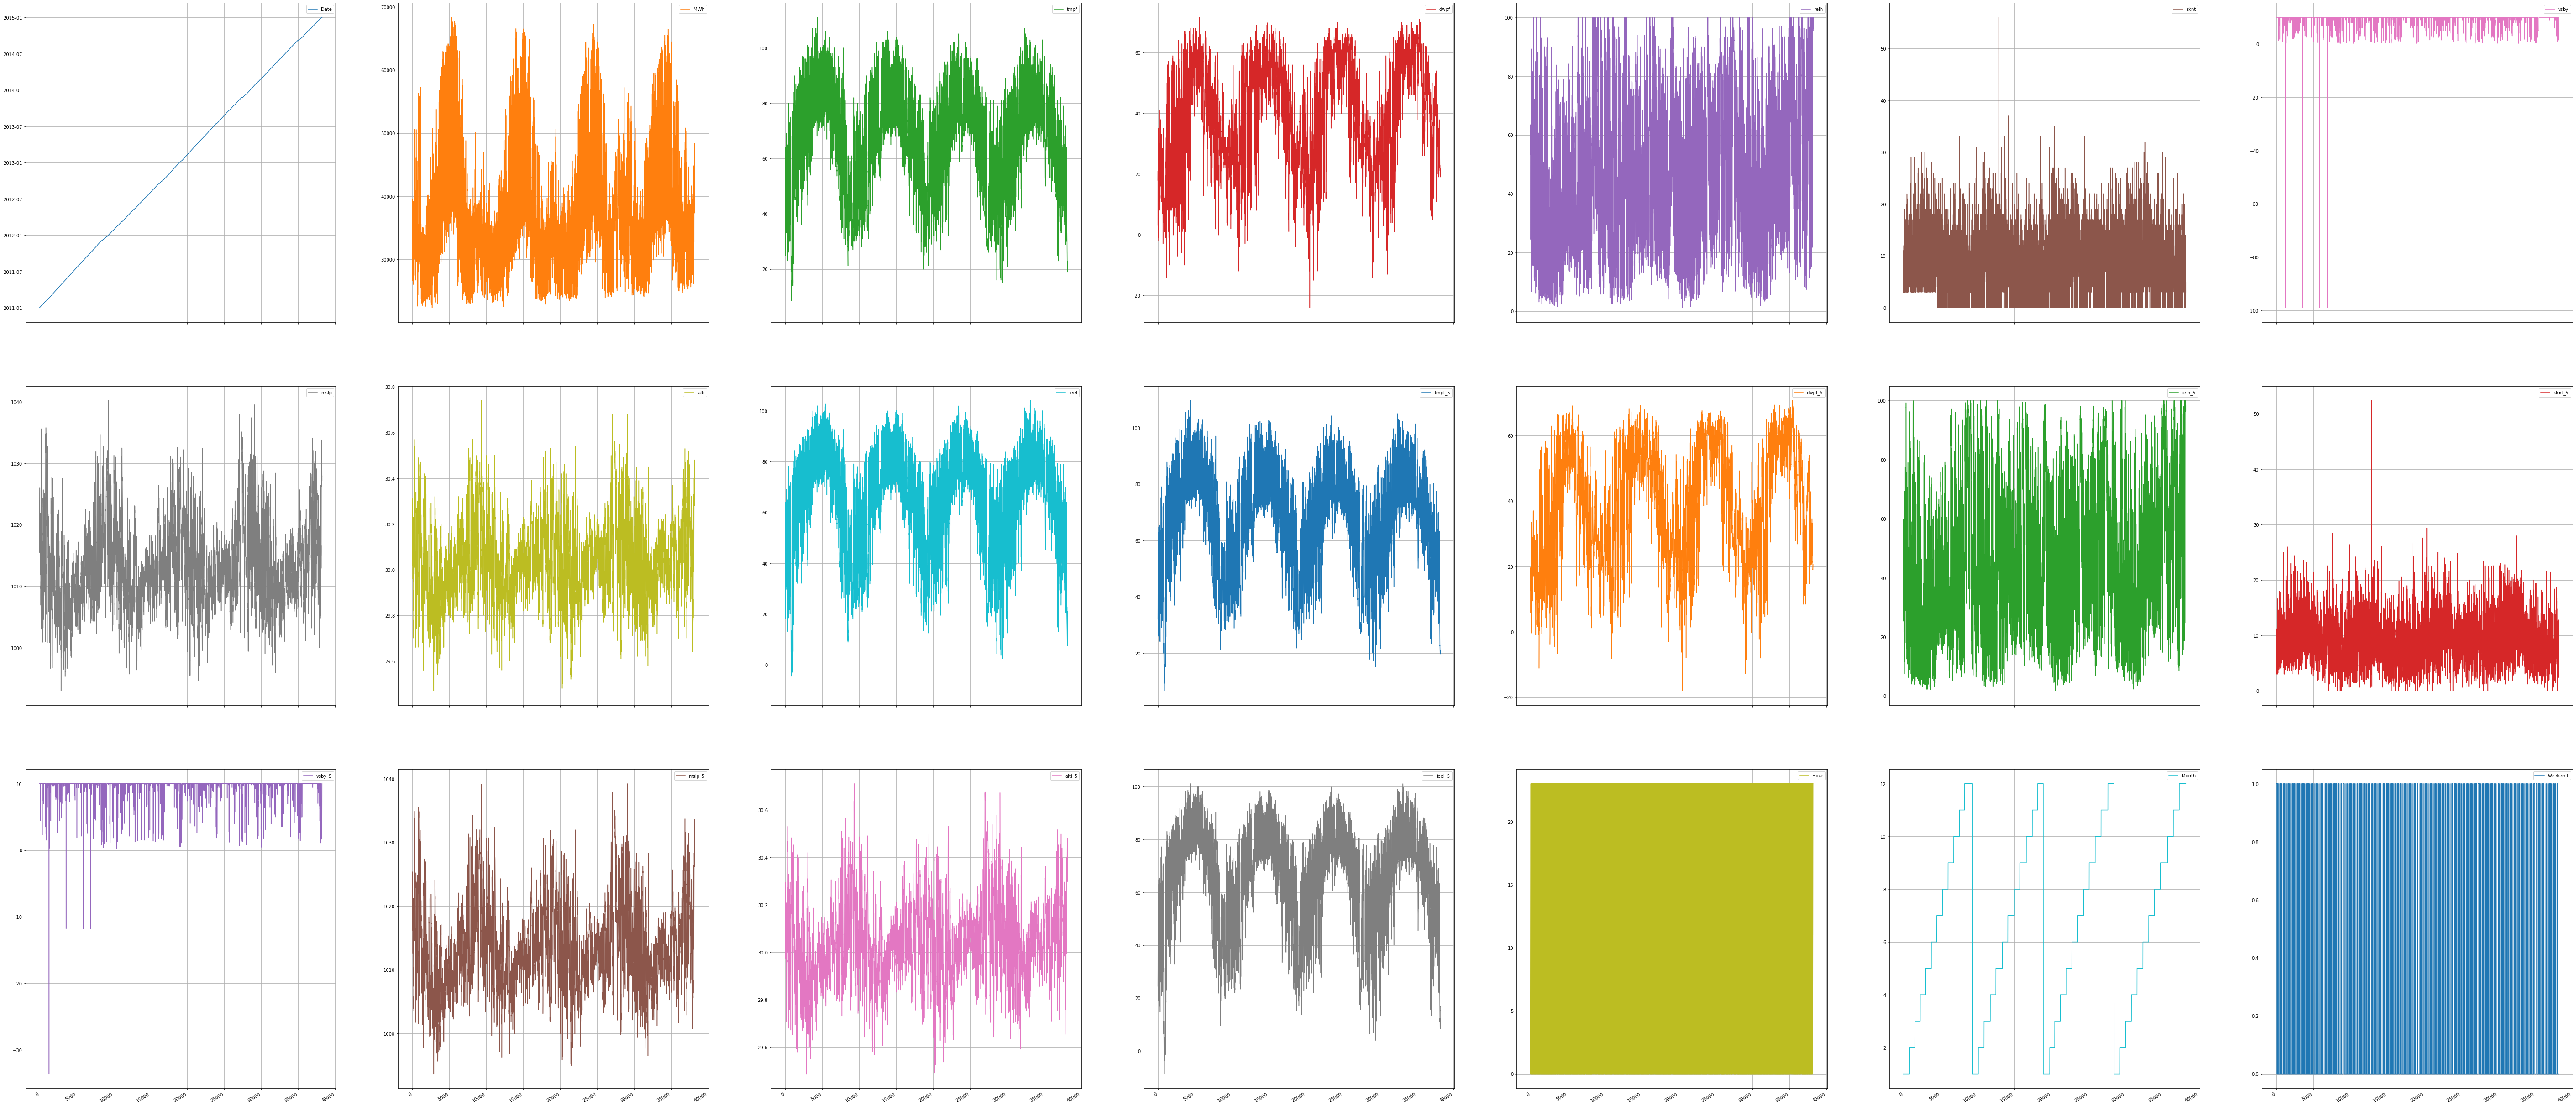

In [ ]:
# Look at the time series of each variable to see variation
ercot_data.plot(subplots=True,
        grid=True,
        layout=(6,7),
         figsize=(100,100))
plt.show()

# Plot 2

Checking the count of the variables of interest gives us the count. Below, we have explored the count of of part_of_day, Day, Month, tmpf, dwpf, relh, sknt, vsby, Hour and weekend. The plots for counts below show how the count varies each day, month and time of the day. Also, we observed that there were peaks and valleys in the counts of vsby, sknt, tmpf and relh.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


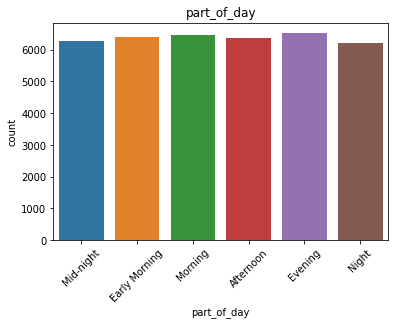

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


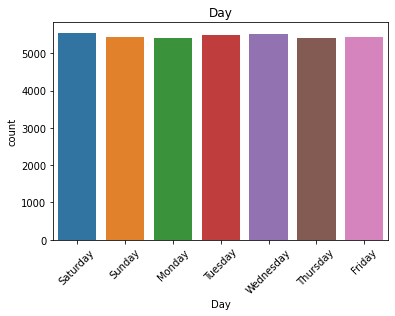

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


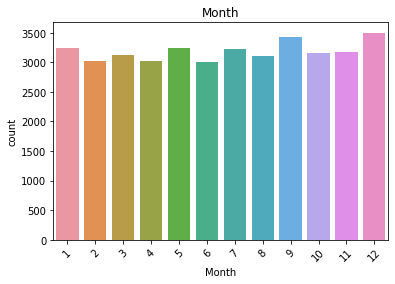

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


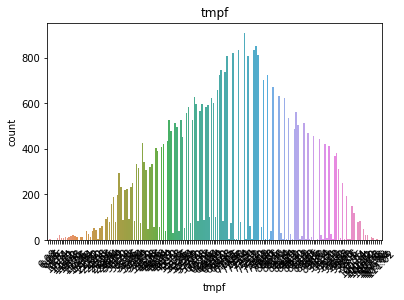

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


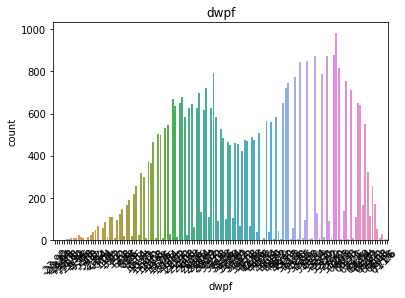

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


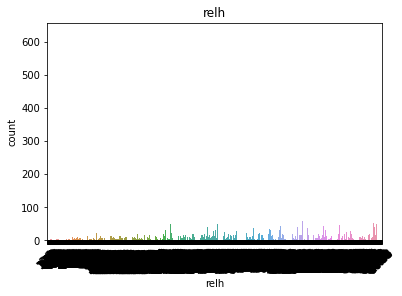

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


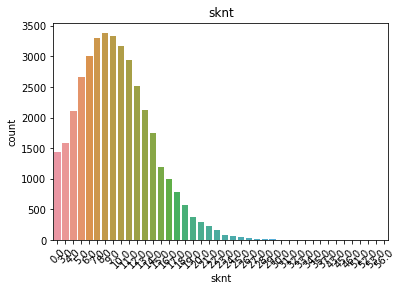

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


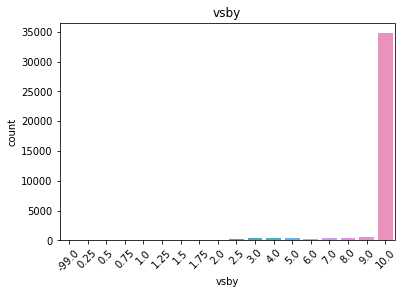

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


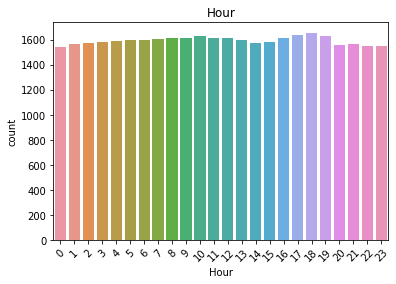

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


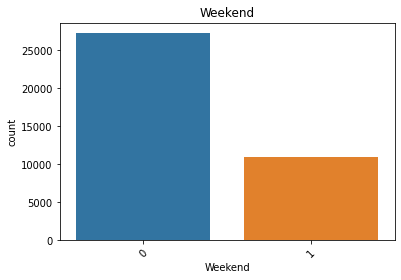

In [ ]:
# checking the count for Month, Day, part_of_day, tmpf, relh, sknt, vsby, Hour and weekend
for col in ['part_of_day', 'Day', 'Month', 'tmpf', 'dwpf', 'relh', 'sknt', 'vsby', 'Hour', 'Weekend']:
  sns.countplot(ercot_data[col])
  plt.title(col)
  plt.xticks(rotation=45)
  plt.show()

# Plot 3

Check the MWh by the part of day. This plot shows how MWh varies by which time it is during the day. We observe that though there are a few outliers during early morning and morning the other boxplots show a median value that has no outliers at all. We can see that the median for evening is around 41000 and for night it is nearly 40000 and so on.

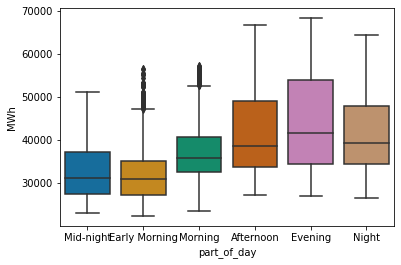

In [ ]:
# check the trend of MWh by part of day
sns.boxplot(y='MWh', x='part_of_day',
                 data=ercot_data,
                 palette="colorblind")
plt.show()

# Plot 4

As the plot shows, there is little to negligible variation in relative humidity by each day of the week.

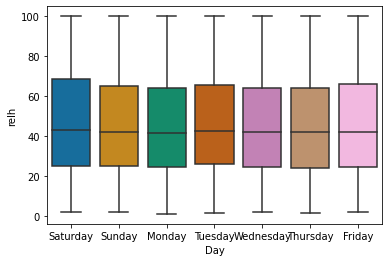

In [ ]:
# check the trend of relative humidity by each day
sns.boxplot(y='relh', x='Day',
                 data=ercot_data,
                 palette="colorblind")
plt.show()

# Plot 5

Subsetting the years 2011, 2012, 2013 and 2014 and check how our target variable 'MWh' varies by each year. The plot below dispaly the same. We observe that there is not much variation during those 4 years.

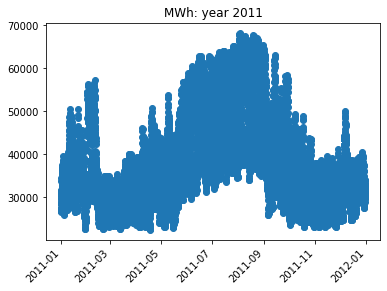

In [ ]:
# subset the years 2011 and check MWh
year2011 = ercot_data[(ercot_data['Date'] >= '2011-01-01') & (ercot_data['Date'] <= '2011-12-31')]
# show it as a scatterplot
fig, ax = plt.subplots()
ax.scatter(y=year2011["MWh"], x=year2011["Date"])
ax.set_title("MWh: year 2011")
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

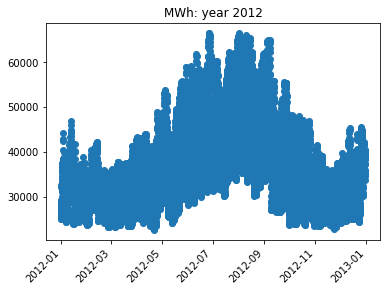

In [ ]:
# subset the years 2012 and check MWh
year2012 = ercot_data[(ercot_data['Date'] >= '2012-01-01') & (ercot_data['Date'] <= '2012-12-31')]
# show it as a scatterplot
fig, ax = plt.subplots()
ax.scatter(y=year2012["MWh"], x=year2012["Date"])
ax.set_title("MWh: year 2012")
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

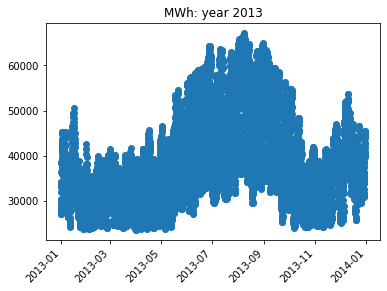

In [ ]:
# subset the years 2013 and check MWh
year2013 = ercot_data[(ercot_data['Date'] >= '2013-01-01') & (ercot_data['Date'] <= '2013-12-31')]
# show it as a scatterplot
fig, ax = plt.subplots()
ax.scatter(y=year2013["MWh"], x=year2013["Date"])
ax.set_title("MWh: year 2013")
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

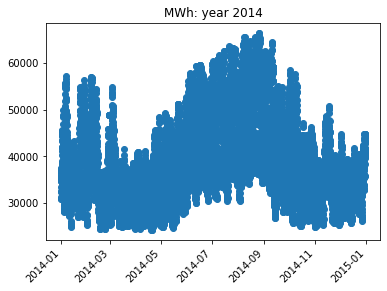

In [ ]:
# subset the years 2014 and check MWh
year2014 = ercot_data[(ercot_data['Date'] >= '2014-01-01') & (ercot_data['Date'] <= '2014-12-31')]
# show it as a scatterplot
fig, ax = plt.subplots()
ax.scatter(y=year2014["MWh"], x=year2014["Date"])
ax.set_title("MWh: year 2014")
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
)
plt.show()

# Plot 6

We checked the distribution of our target variable. As we observe that the frequency of occurance of highest MWh is more than 1600 and its value lies at around 34000.

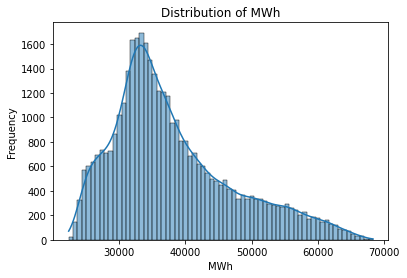

In [ ]:
plt.title("Distribution of MWh")
plt.xlabel("MWh")
plt.ylabel("Frequency")
sns.histplot(data=ercot_data, x="MWh", kde=True)

# Plot 7

The distribution of wind speed on knots shows that the highest frequency occurs at 3500. There are few peaks and valleys as seen below.

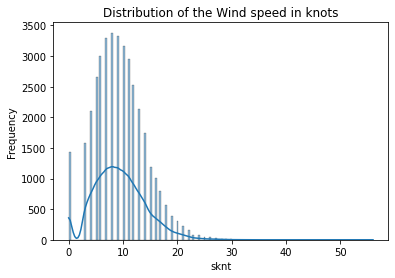

In [ ]:
plt.title("Distribution of the Wind speed in knots")
plt.xlabel("sknt")
plt.ylabel("Frequency")
sns.histplot(data=ercot_data, x="sknt", kde=True)

The plot below shows the distribution of Dew point temperature

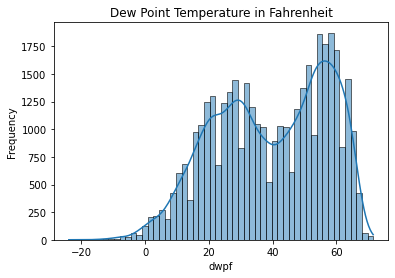

In [ ]:
plt.title("Dew Point Temperature in Fahrenheit")
plt.xlabel("dwpf")
plt.ylabel("Frequency")
sns.histplot(data=ercot_data, x="dwpf", kde=True)

# Plot 8

Air temperature is shown for each month and further subdivided into all 7 days of the week. This plot shows very outliers and most of the data is within the range.

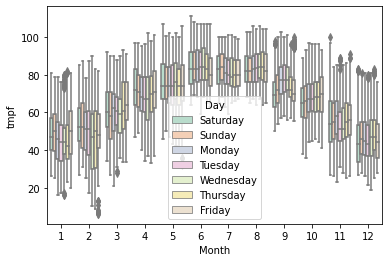

In [ ]:
# Air temperature for each day grouped by month
sns.boxplot(y='tmpf', x='Month',
                  data=ercot_data,
                  palette="Pastel2",
                  hue='Day')

# Plot 9

The plot below shows the time series plot of the target variable 'MWh' subdivided by the dates from the years 2011 to 2014.

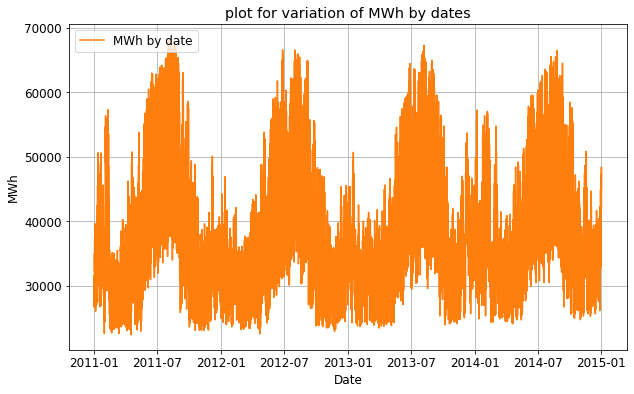

In [ ]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(ercot_data.Date, ercot_data.MWh, color='tab:orange', label='MWh by date')

# Same as above
ax.set_xlabel('Date')
ax.set_ylabel('MWh')
ax.set_title('plot for variation of MWh by dates')
ax.grid(True)
ax.legend(loc='upper left');

# ***Modeling***

## Data Preparation for Modeling

In [ ]:
# Import the standard modules required
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# read train and test data
# The train and test data was saved to csv after the initial preprocessing and feature engineering was complete.
# This was done to avoid re-running all the code prior.
ercot_data = pd.read_csv("ercot_data_train_1.csv", index_col=False)
ercot_data_test = pd.read_csv("ercot_data_test_1.csv", index_col=False)

In [ ]:
# Look at the the top 5 rows of ercot_data which is our train data
ercot_data.head() #NAs should be replaced

Unnamed: 0                 Date           MWh  ...  Month       Day  Weekend
0           0  2011-01-01 00:00:00  28496.388850  ...      1  Saturday        1
1           1  2011-01-01 01:00:00  27662.443480  ...      1  Saturday        1
2           2  2011-01-01 02:00:00  27250.044715  ...      1  Saturday        1
3           3  2011-01-01 03:00:00  26783.226081  ...      1  Saturday        1
4           4  2011-01-01 04:00:00  26676.468490  ...      1  Saturday        1

[5 rows x 25 columns]

In [ ]:
# Look at the the top 5 rows of ercot_data_test
ercot_data_test.head() #NAs should be replaced

Unnamed: 0                 Date           MWh  ...  Month       Day  Weekend
0           0  2015-01-01 00:00:00  40707.660350  ...      1  Thursday        0
1           1  2015-01-01 00:00:00  40707.660350  ...      1  Thursday        0
2           2  2015-01-01 00:00:00  40707.660350  ...      1  Thursday        0
3           3  2015-01-01 01:00:00  39624.861027  ...      1  Thursday        0
4           4  2015-01-01 02:00:00  39013.544802  ...      1  Thursday        0

[5 rows x 25 columns]

In [ ]:
# remove the additional index column from train data
del ercot_data['Unnamed: 0']

In [ ]:
# remove the additional index column from test data
del ercot_data_test['Unnamed: 0']

In [ ]:
# lets look at the summary statistics of the train data
ercot_data.describe()

MWh          tmpf  ...         Month       Weekend
count  38223.000000  38223.000000  ...  38223.000000  38223.000000
mean   38058.928077     66.063430  ...      6.582293      0.287078
std     9194.780779     18.495579  ...      3.476973      0.452404
min    22366.014254      6.080000  ...      1.000000      0.000000
25%    31694.576620     53.060000  ...      4.000000      0.000000
50%    35767.088837     68.000000  ...      7.000000      0.000000
75%    42939.798960     80.060000  ...     10.000000      1.000000
max    68317.669844    111.020000  ...     12.000000      1.000000

[8 rows x 20 columns]

In [ ]:
# summary statistics on the test data
ercot_data_test.describe()

MWh          tmpf  ...         Month       Weekend
count  10520.000000  10520.000000  ...  10520.000000  10520.000000
mean   39823.301730     62.694996  ...      6.319106      0.285551
std     9031.310668     18.926748  ...      3.525979      0.451698
min    24337.467368     21.020000  ...      1.000000      0.000000
25%    33606.402138     48.920000  ...      3.000000      0.000000
50%    37806.661941     64.940000  ...      6.000000      0.000000
75%    44638.603002     77.000000  ...     10.000000      1.000000
max    69620.407614    102.920000  ...     12.000000      1.000000

[8 rows x 20 columns]

In [ ]:
# Replacing NAs with Zero in Training Data
ercot_data.replace(np.nan, 0, inplace=True) # NA's are replaced with Zero

In [ ]:
# Lets look at the head of the train data. NA's are replaced with Zero. Looks good.
ercot_data.head()

Date           MWh   tmpf  ...  Month       Day  Weekend
0  2011-01-01 00:00:00  28496.388850  32.00  ...      1  Saturday        1
1  2011-01-01 01:00:00  27662.443480  33.08  ...      1  Saturday        1
2  2011-01-01 02:00:00  27250.044715  33.08  ...      1  Saturday        1
3  2011-01-01 03:00:00  26783.226081  32.00  ...      1  Saturday        1
4  2011-01-01 04:00:00  26676.468490  30.02  ...      1  Saturday        1

[5 rows x 24 columns]

In [ ]:
# Replacing NAs with Zero in the Test Data
ercot_data_test.replace(np.nan, 0, inplace=True)

In [ ]:
ercot_data_test.head() # NA's are replaced with Zero

Date           MWh   tmpf  ...  Month       Day  Weekend
0  2015-01-01 00:00:00  40707.660350  21.02  ...      1  Thursday        0
1  2015-01-01 00:00:00  40707.660350  21.02  ...      1  Thursday        0
2  2015-01-01 00:00:00  40707.660350  21.02  ...      1  Thursday        0
3  2015-01-01 01:00:00  39624.861027  21.92  ...      1  Thursday        0
4  2015-01-01 02:00:00  39013.544802  21.92  ...      1  Thursday        0

[5 rows x 24 columns]

In [ ]:
# Label encoding categorical columns in train and test data
# For our reference: train data is ercot_data now saved as df, test data is ercot_data_test

In [ ]:
df = ercot_data
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode 'part of day'.
df['part_of_day']= label_encoder.fit_transform(df['part_of_day'])

# Encode 'day'.
df['Day']= label_encoder.fit_transform(df['Day'])

# Encode 'skyc1'
df['skyc1']= label_encoder.fit_transform(df['skyc1'])

In [ ]:
# Moving target variable MWh to the last, this helps with split_sequences() code later
df.insert(len(df.columns)-1, 'MWh', df.pop('MWh'))

In [ ]:
# Checking the train dataframe, looks good!
df.head()

Date   tmpf   dwpf   relh  ...  Month  Day  Weekend           MWh
0  2011-01-01 00:00:00  32.00  17.96  55.72  ...      1    2        1  28496.388850
1  2011-01-01 01:00:00  33.08  19.04  55.89  ...      1    2        1  27662.443480
2  2011-01-01 02:00:00  33.08  17.96  53.36  ...      1    2        1  27250.044715
3  2011-01-01 03:00:00  32.00  19.04  58.37  ...      1    2        1  26783.226081
4  2011-01-01 04:00:00  30.02  19.04  63.24  ...      1    2        1  26676.468490

[5 rows x 24 columns]

In [ ]:
# Drop "Date" column from the train data df
df.drop(['Date'], inplace=True, axis=1)

In [ ]:
df.head() # Date column is removed

tmpf   dwpf   relh  sknt  ...  Month  Day  Weekend           MWh
0  32.00  17.96  55.72   8.0  ...      1    2        1  28496.388850
1  33.08  19.04  55.89   7.0  ...      1    2        1  27662.443480
2  33.08  17.96  53.36   9.0  ...      1    2        1  27250.044715
3  32.00  19.04  58.37   7.0  ...      1    2        1  26783.226081
4  30.02  19.04  63.24   7.0  ...      1    2        1  26676.468490

[5 rows x 23 columns]

In [ ]:
# Lets look at the correlations, this was done to understand the association of the variables with the atrget variable
df.corr()

tmpf      dwpf      relh  ...       Day   Weekend       MWh
tmpf         1.000000  0.453107 -0.501309  ... -0.016668  0.006598  0.507672
dwpf         0.453107  1.000000  0.472182  ... -0.014306  0.013578  0.301505
relh        -0.501309  0.472182  1.000000  ... -0.002656  0.015504 -0.182045
sknt         0.181515  0.080327 -0.113868  ...  0.005639 -0.004765  0.073696
vsby         0.220501 -0.012755 -0.322862  ...  0.005182 -0.018317  0.002955
mslp        -0.676653 -0.254731  0.384206  ...  0.013619 -0.005653 -0.153633
alti        -0.557400 -0.143423  0.369174  ...  0.014952 -0.009030 -0.091302
skyc1       -0.178943  0.058070  0.279392  ...  0.003885  0.011637  0.043911
feel         0.991082  0.494263 -0.473082  ... -0.021877  0.009779  0.457054
tmpf_5       0.968749  0.474320 -0.459250  ... -0.016247  0.006568  0.488982
dwpf_5       0.473775  0.978141  0.446456  ... -0.013802  0.014196  0.313822
relh_5      -0.465032  0.450761  0.947626  ... -0.002808  0.016146 -0.148812
sknt_5       0.172269  0.087465 -0.094265  ...  0.004614 -0.006700  0.040650
vsby_5       0.274611 -0.011944 -0.396032  ...  0.004991 -0.026262 -0.002827
mslp_5      -0.336178 -0.136417  0.187254  ...  0.011240 -0.015921 -0.063219
alti_5      -0.234274 -0.065127  0.156132  ...  0.011212 -0.017775 -0.021106
feel_5       0.962543  0.511841 -0.433577  ... -0.021595  0.009805  0.438656
Hour         0.254084 -0.072809 -0.286777  ...  0.000444 -0.005157  0.454285
part_of_day -0.099970  0.039729  0.093333  ... -0.001395  0.001422  0.015814
Month        0.065193  0.307161  0.231186  ... -0.015385  0.019069  0.110562
Day         -0.016668 -0.014306 -0.002656  ...  1.000000 -0.162466  0.040425
Weekend      0.006598  0.013578  0.015504  ... -0.162466  1.000000 -0.129330
MWh          0.507672  0.301505 -0.182045  ...  0.040425 -0.129330  1.000000

[23 rows x 23 columns]

**Intuition behind Variable Selection for Modeling:**

* The variables that help asses the weather at any time are temperature(tmpf), humidity(relh), temperature(tmpf), dew point(dwpf), atmospheric pressure(mslp) and cloudiness (given by skc1).

* tmpf_5 and dwpf_5 (rolling averages) will be taken in the model. dwpf_5 shows better correlation with the target variable.

* Additionally we plan to include "vsby", "feel" and "hour". "Vsby" describes the visibility in miles, also helps support the cloudiness and presence of fog that can alter or affect the energy usage.

* We included the "feel" and "hour" variable as these variables showed some positive correlation (~0.45) with the target variable. This is also intuitive, as based on how hot or cold the weather is the energy usage varies and "hour" is important as in general afternoons can be more warmer than nights. So usage of air conditioning can be more in the afternoons than nights.

In [ ]:
# Subset the required columns/variables for model building
df_subset = df[['skyc1','relh','vsby','mslp','tmpf_5','dwpf_5','feel','Hour', 'MWh']]

In [ ]:
df_subset.head()

skyc1   relh  vsby    mslp  tmpf_5  dwpf_5   feel  Hour           MWh
0      2  55.72  10.0  1015.5   0.000   0.000  24.11     0  28496.388850
1      2  55.89  10.0  1015.6   0.000   0.000  26.10     1  27662.443480
2      2  53.36  10.0  1016.2   0.000   0.000  24.86     2  27250.044715
3      2  58.37  10.0  1016.6   0.000   0.000  24.78     3  26783.226081
4      2  63.24  10.0  1017.2  32.036  18.608  22.37     4  26676.468490

In [ ]:
# prep data for modeling (multivariate)
# split train data into indepednet variable and target variable (X, y respectively)

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [ ]:
n_steps = 3
raw_seq = np.array(df_subset) #data is stored as a numpy array
X, y = split_sequences(raw_seq, n_steps)

In [ ]:
print(X.shape) # Train data
print(y.shape) # y_train

(38221, 3, 8)
(38221,)


In [ ]:
#X is our X_train Data
#y is our y_train data (target variable for train data)

In [ ]:
# label encode columns in test data
# Encode 'part of day'.
ercot_data_test['part_of_day']= label_encoder.fit_transform(ercot_data_test['part_of_day'])

# Encode 'day'.
ercot_data_test['Day']= label_encoder.fit_transform(ercot_data_test['Day'])

# Encode 'skyc1'
ercot_data_test['skyc1']= label_encoder.fit_transform(ercot_data_test['skyc1'])


In [ ]:
# Moving target variable MWh to the last in the test data
ercot_data_test.insert(len(ercot_data_test.columns)-1, 'MWh', ercot_data_test.pop('MWh'))

In [ ]:
ercot_data_test.head() # Looks good.

Date   tmpf   dwpf    relh  ...  Month  Day  Weekend           MWh
0  2015-01-01 00:00:00  21.02  21.02  100.00  ...      1    4        0  40707.660350
1  2015-01-01 00:00:00  21.02  21.02  100.00  ...      1    4        0  40707.660350
2  2015-01-01 00:00:00  21.02  21.02  100.00  ...      1    4        0  40707.660350
3  2015-01-01 01:00:00  21.92  21.02   96.26  ...      1    4        0  39624.861027
4  2015-01-01 02:00:00  21.92  21.02   96.26  ...      1    4        0  39013.544802

[5 rows x 24 columns]

In [ ]:
# Consider the required independent variables into X_test
df_test = ercot_data_test[['skyc1','relh','vsby','mslp','tmpf_5','dwpf_5','feel','Hour', 'MWh']]

In [ ]:
df_test.head() # Looks good.

skyc1    relh  vsby    mslp  tmpf_5  dwpf_5   feel  Hour           MWh
0      3  100.00  10.0  1026.4    0.00    0.00  16.14     0  40707.660350
1      3  100.00   9.0  1026.4    0.00    0.00  21.02     0  40707.660350
2      3  100.00  10.0  1026.4    0.00    0.00  13.36     0  40707.660350
3      3   96.26   9.0  1026.0    0.00    0.00  17.17     1  39624.861027
4      3   96.26   8.0  1026.0   21.38   21.02  15.65     2  39013.544802

In [ ]:
# store X_test as numpy array
X_test = np.array(df_test)

In [ ]:
# Split into X_test and y_test
X_test, y_test = split_sequences(X_test, n_steps)

In [ ]:
X_test.shape

(10518, 3, 8)

In [ ]:
y_test.shape

(10518,)

In [ ]:
# Converting  data type to float32
X_test = np.asarray(X_test).astype(np.float32)

## Final Model

### Model-10

In [ ]:
# Model-10:
# GRU architecture
# uses skyc1, hour, feel, along with tmpf_5, dwpf_5 variables.
# activation function = linear
# drop out = 0.01
# adam optimizer
# Model MAE = 585!

In [ ]:
# Model-10
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model10 = Sequential()
model10.add(GRU(30, input_shape=(n_steps,n_features), return_sequences = True, activation='linear', recurrent_dropout=0.01))
model10.add(GRU(15, activation = "linear", recurrent_dropout=0.01))
model10.add(Dense(1))
model10.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model10.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model10.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 3, 30)             3600      
_________________________________________________________________
gru_12 (GRU)                 (None, 15)                2115      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 16        
Total params: 5,731
Trainable params: 5,731
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6116/6116 [==============================] - 56s 8ms/step - loss: 110581845.8326 - mae: 5247.1421 - val_loss: 6994308.0000 - val_mae: 2310.6863
Epoch 2/100
6116/6116 [==============================] - 51s 8ms/step - loss: 3135722.7474 - mae: 1365.7145 - val_loss: 1162212.2500 - val_mae: 850.9146
Epoch 3/100
6116/6116 [==============================] - 51s 8ms/step - 

MAE:  585.1413747416564


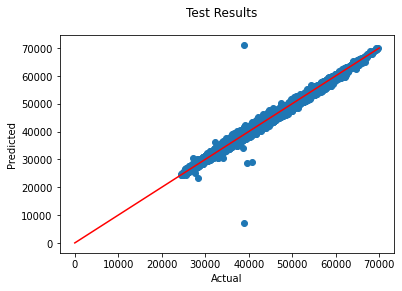

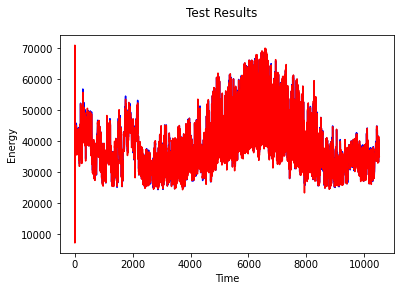

In [ ]:
# make a prediction on test data
M10_pred = model10.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M10_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M10_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the test data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M10_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

**Model-10 showed the least MAE of 585.14 on unseen Test Data - We report this as our best model.**

In [ ]:
# MAE by month and day for 2015

In [ ]:
# Take the predictions and add to the the ercot_test_data
# Extract month and day and from the data
# calculate MAE per month and day
# make a plot

# ***Results***

In [ ]:
# Best model(Model-10) predictions
M10_pred

array([[28908.445],
       [28850.307],
       [70997.71 ],
       ...,
       [35574.844],
       [34920.63 ],
       [34935.887]], dtype=float32)

In [ ]:
# Convert the array of Model-10 predictions to a dataframe
Predictions = pd.DataFrame(M10_pred)

In [ ]:
# consider our test data and save it to a new dataframe named "Actual Data"
Actual_data = ercot_data_test

In [ ]:
# Add the Model-10 predictions to the Actual Data
Actual_data["Predictions"] = Predictions

In [ ]:
# This is our complete test data with Predictions, that we will use for the analysis and results section
Actual_data.head()

Date  HE   tmpf  ...  Weekend           MWh   Predictions
0  2015-01-01 00:00:00   0  21.02  ...        0  40707.660350  28908.445312
1  2015-01-01 00:00:00   0  21.02  ...        0  40707.660350  28850.306641
2  2015-01-01 00:00:00   0  21.02  ...        0  40707.660350  70997.710938
3  2015-01-01 01:00:00   1  21.92  ...        0  39624.861027   7116.242676
4  2015-01-01 02:00:00   2  21.92  ...        0  39013.544802  38527.222656

[5 rows x 26 columns]

In [ ]:
# The actual data was saved to Csv, to re-use it later, incase we run into runtime issues or close the current file.
Actual_data.to_csv("Final_Predictions_Data.csv")

In [ ]:
# Time series plot of actual vs predicted for january 2015 - July 2015

In [ ]:
# Read the complete test data with predictions
Actual_data = pd.read_csv("Final_Predictions_Data.csv")

In [ ]:
# Lets look at the head
Actual_data.head()

Unnamed: 0           Date  HE   tmpf  ...  Day  Weekend          MWh  Predictions
0           0  1/1/2015 0:00   0  21.02  ...    4        0  40707.66035   28908.4450
1           1  1/1/2015 0:00   0  21.02  ...    4        0  40707.66035   28850.3070
2           2  1/1/2015 0:00   0  21.02  ...    4        0  40707.66035   70997.7100
3           3  1/1/2015 1:00   1  21.92  ...    4        0  39624.86103    7116.2427
4           4  1/1/2015 2:00   2  21.92  ...    4        0  39013.54480   38527.2230

[5 rows x 27 columns]

In [ ]:
# Remove the additional Index column
del Actual_data['Unnamed: 0']

In [ ]:
# Convert the "Date" column to a datetime format
Actual_data['Date'] = pd.to_datetime(Actual_data.Date)

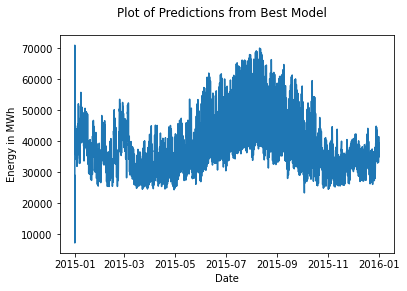

In [ ]:
# Look at a plot of the Predictions (simple plot)
plt.plot(Actual_data['Date'],Actual_data['Predictions'])
plt.suptitle('Plot of Predictions from Best Model')
plt.xlabel('Date')
plt.ylabel('Energy in MWh')
plt.show()

## Scatter Plot of Actual Vs. Predicted (January 2015 - July 2015)

In [ ]:
# Extract data from January 2015 to July 2015 to generate the Actuals Vs Predicted plot for this time period.
data_Jan_July = Actual_data.loc[(Actual_data['Date'] >= '2015-01-01') & (Actual_data['Date'] < '2015-08-01')]
data_Jan_July.tail() # Data till July 31rst is present.

Date  HE   tmpf  ...  Weekend          MWh  Predictions
6323 2015-07-31 19:00:00  19  96.08  ...        0  61821.82557    56104.277
6324 2015-07-31 20:00:00  20  93.02  ...        0  58762.43878    53294.230
6325 2015-07-31 21:00:00  21  91.04  ...        0  56565.23612    49424.820
6326 2015-07-31 22:00:00  22  87.98  ...        0  54301.69309    45490.633
6327 2015-07-31 23:00:00  23  84.92  ...        0  50670.29699    42706.836

[5 rows x 26 columns]

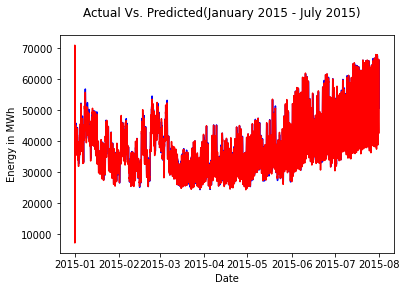

In [ ]:
# Time series plot for actual vs predicted January 2015 - July 2015
plt.plot(data_Jan_July.Date, data_Jan_July.MWh, color='blue') # actual data
plt.plot(data_Jan_July.Date, data_Jan_July.Predictions, color='red') # predicted data
plt.suptitle('Actual Vs. Predicted(January 2015 - July 2015)')
plt.xlabel('Date')
plt.ylabel('Energy in MWh')
plt.show()

**Inference:**
1. The predicted values overlay well over the Actual Values. Indicating low prediction errors in the data.
2. The energy consumption is above 20,000 MWh and below 70,000MWh
3. The month of March shows a slight spike in the Energy consumption, which starts to increase gradually from June onwards.

## Scatter Plot of Actual Vs. Predicted (January 2015 - December 2015)

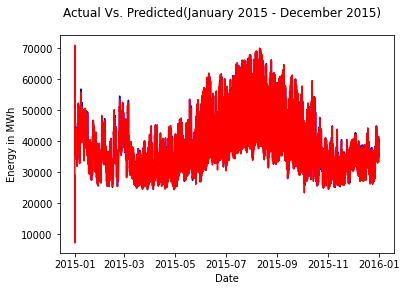

In [ ]:
# Time series plot for actual vs predicted (Complete Data)
plt.plot(Actual_data.Date, Actual_data.MWh, color='blue') # actual data
plt.plot(Actual_data.Date, Actual_data.Predictions, color='red') # predicted data
plt.suptitle('Actual Vs. Predicted(January 2015 - December 2015)')
plt.xlabel('Date')
plt.ylabel('Energy in MWh')
plt.show()

**Inference:**
1. The predicted values overlay very well over the actual values, indicating low prediction errros from the model.
2. As mentioned above, the period after July shows an increase in Energy demand till September, after which it reduces. This period is Summer time, shows more energy consumption.
3. Summer Months - July to August see the maximum energy demand/consumption.
4. The overall energy demand for the State of Texas is between 25,000 MWh to 70,000MWh (at peak).

# ***Analysis***

## Density Plot of Residuals

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # distplot() function gives a depreciation error, to ignore that using this "ignore warnings" function.
import seaborn as sns

In [ ]:
# Did n_steps of 3, therefore the last two values are not predicted, as there were only 2 rows left and not 3.
# Therefore, removing the last two rows with NA values as this interrupts the plots
Actual_data = Actual_data.iloc[:-2]

In [ ]:
# Calculate the Residuals: Predicted Values - True Values
Actual_data["Residuals"] =  Actual_data['Predictions'] - Actual_data['MWh']

In [ ]:
Actual_data.head()

Date  HE   tmpf  ...          MWh  Predictions    Residuals
0 2015-01-01 00:00:00   0  21.02  ...  40707.66035   28908.4450 -11799.21535
1 2015-01-01 00:00:00   0  21.02  ...  40707.66035   28850.3070 -11857.35335
2 2015-01-01 00:00:00   0  21.02  ...  40707.66035   70997.7100  30290.04965
3 2015-01-01 01:00:00   1  21.92  ...  39624.86103    7116.2427 -32508.61833
4 2015-01-01 02:00:00   2  21.92  ...  39013.54480   38527.2230   -486.32180

[5 rows x 27 columns]

Text(0, 0.5, 'Density')

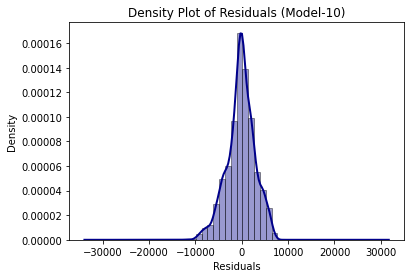

In [ ]:
# Density Plot and Histogram of the Residuals
sns.distplot(Actual_data['Residuals'], hist=True, kde=True,
             color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Density Plot of Residuals (Model-10)')
plt.xlabel('Residuals')
plt.ylabel('Density')

**Inference:**

1. The residuals are equally distributed around 0. They appear normal. This indiactes that the model is able to generalize well, it does not over predict or under predict the target variable.

2. This proves that the model is not biased to either side, and therefore, we can conclude that the model generalizes well.

## Density Plot of MAE by Hour

In [ ]:
# Calculate MAE by Row - to get it per hour in a day
# First calculate the absolute errors abs(True value - Predicted Value)
# Then take the mean

# Absolute Error
Actual_data["Absolute_Error"] = abs(Actual_data["MWh"]- Actual_data['Predictions'])
# Mean of the Absolute errors
Actual_data['MAE_By_Hour'] = Actual_data[['Absolute_Error']]/Actual_data.shape[0]

# Check the data
Actual_data.head() # Looks good

Date  HE   tmpf  ...    Residuals  Absolute_Error  MAE_By_Hour
0 2015-01-01 00:00:00   0  21.02  ... -11799.21535     11799.21535     1.121812
1 2015-01-01 00:00:00   0  21.02  ... -11857.35335     11857.35335     1.127339
2 2015-01-01 00:00:00   0  21.02  ...  30290.04965     30290.04965     2.879830
3 2015-01-01 01:00:00   1  21.92  ... -32508.61833     32508.61833     3.090760
4 2015-01-01 02:00:00   2  21.92  ...   -486.32180       486.32180     0.046237

[5 rows x 29 columns]

In [ ]:
# Checking if calculations of MAE by Hour are correct.
# MAE by formula
mae = mean_absolute_error(Actual_data['MWh'], Actual_data['Predictions'])
mae # Its 2316.13

2316.1317623911386

In [ ]:
# Let us try and verify it, lets take the mean of the "Absolute Error" column we created. Since MAE is Mean Absolute Error
Actual_data['Absolute_Error'].mean() # Verifies, its 2316: Exactly same as what we calculated using the mean_absolute_error() python function

2316.1317623911395

In [ ]:
# Lets check per Hour
# Since we divided per hour absolute error by the no. of observations, adding up all these values should give us 2316
sum(Actual_data['MAE_By_Hour'])  # Model run shows a MAE of ~600, this could be the average across 40 epochs and therefore assuming it was much lower (not really sure)

2316.1317623911355

Text(0, 0.5, 'Density')

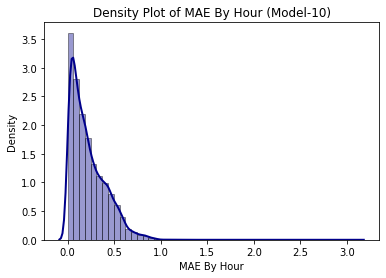

In [ ]:
# Density Plot for MAE by Hour

sns.distplot(Actual_data['MAE_By_Hour'], hist=True, kde=True, # gaussian kernel density plot
             color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Density Plot of MAE By Hour (Model-10)')
plt.xlabel('MAE By Hour')
plt.ylabel('Density')

**Inference:**

1. The Mean Absolute Error by hour (by row) for all the observations in the test data show a positive skew.
2. This means that for bulk of the data the MAE is closer to 0 and on the lower end, which is good.  
3. Few observations showed predictions that have higher MAE values, falling in the right tail.
4. Overall, this means that the model is able to predict well hourly, with low absolute errors.

## Comparison of MAE by Month

In [ ]:
Actual_data["Month"] = Actual_data['Date'].dt.month

In [ ]:
Actual_data["Day"] = Actual_data['Date'].dt.day

In [ ]:
# MAE by Month

In [ ]:
Actual_data.head()

Date  HE   tmpf  ...    Residuals  Absolute_Error  MAE_By_Hour
0 2015-01-01 00:00:00   0  21.02  ... -11799.21535     11799.21535     1.121812
1 2015-01-01 00:00:00   0  21.02  ... -11857.35335     11857.35335     1.127339
2 2015-01-01 00:00:00   0  21.02  ...  30290.04965     30290.04965     2.879830
3 2015-01-01 01:00:00   1  21.92  ... -32508.61833     32508.61833     3.090760
4 2015-01-01 02:00:00   2  21.92  ...   -486.32180       486.32180     0.046237

[5 rows x 29 columns]

In [ ]:
# Extract Data by Month
Jan=Actual_data.loc[Actual_data['Month'] == 1]
Feb=Actual_data.loc[Actual_data['Month'] == 2]
March=Actual_data.loc[Actual_data['Month'] == 3]
April=Actual_data.loc[Actual_data['Month'] == 4]
May=Actual_data.loc[Actual_data['Month'] == 5]
June=Actual_data.loc[Actual_data['Month'] == 6]
July=Actual_data.loc[Actual_data['Month'] == 7]
Aug=Actual_data.loc[Actual_data['Month'] == 8]
Sept=Actual_data.loc[Actual_data['Month'] == 9]
Oct=Actual_data.loc[Actual_data['Month'] == 10]
Nov=Actual_data.loc[Actual_data['Month'] == 11]
Dec=Actual_data.loc[Actual_data['Month'] == 12]

In [ ]:
# Extract Actuals and Predicted Values by Month
actual_Jan= np.array(Jan['MWh'])
pred_Jan = np.array(Jan['Predictions'])
actual_Feb= np.array(Feb['MWh'])
pred_Feb = np.array(Feb['Predictions'])
actual_Mar= np.array(March['MWh'])
pred_Mar = np.array(March['Predictions'])
actual_Apr= np.array(April['MWh'])
pred_Apr = np.array(April['Predictions'])
actual_May= np.array(May['MWh'])
pred_May = np.array(May['Predictions'])
actual_June= np.array(June['MWh'])
pred_June = np.array(June['Predictions'])
actual_July= np.array(July['MWh'])
pred_July = np.array(July['Predictions'])
actual_Aug= np.array(Aug['MWh'])
pred_Aug = np.array(Aug['Predictions'])
actual_Sept= np.array(Sept['MWh'])
pred_Sept = np.array(Sept['Predictions'])
actual_Oct= np.array(Oct['MWh'])
pred_Oct = np.array(Oct['Predictions'])
actual_Nov= np.array(Nov['MWh'])
pred_Nov = np.array(Nov['Predictions'])
actual_Dec= np.array(Dec['MWh'])
pred_Dec = np.array(Dec['Predictions'])

In [ ]:
# Calculate MAE by Month
Jan_MAE=mean_absolute_error(actual_Jan, pred_Jan)
feb_MAE=mean_absolute_error(actual_Feb, pred_Feb)
Mar_MAE=mean_absolute_error(actual_Mar, pred_Mar)
Apr_MAE=mean_absolute_error(actual_Apr, pred_Apr)
May_MAE=mean_absolute_error(actual_May, pred_May)
Jun_MAE=mean_absolute_error(actual_June, pred_June)
July_MAE=mean_absolute_error(actual_July, pred_July)
Aug_MAE=mean_absolute_error(actual_Aug, pred_Aug)
Sept_MAE=mean_absolute_error(actual_Sept, pred_Sept)
Oct_MAE=mean_absolute_error(actual_Oct, pred_Oct)
Nov_MAE=mean_absolute_error(actual_Nov, pred_Nov)
Dec_MAE=mean_absolute_error(actual_Dec, pred_Dec)

In [ ]:
# Create a list of Months and the corressponding MAE values
names = ['Jan','Feb','Mar',"Apr",'May','June','July','Aug','Sept','Oct','Nov','Dec']
MAE = [round(Jan_MAE,3),round(feb_MAE,3),round(Mar_MAE,3),round(Apr_MAE,3),round(May_MAE,3), round(Jun_MAE,3),
       round(July_MAE,3),round(Aug_MAE,3),round(Sept_MAE,3),round(Oct_MAE,3),round(Nov_MAE,3), round(Dec_MAE,3)]

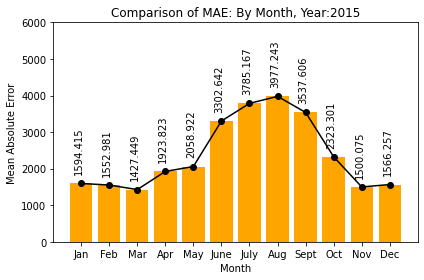

In [ ]:
# Ploting a bar chart of MAE by Month
plt.bar(names, MAE, color = 'Orange')
plt.plot(names, MAE, '-ok')
plt.title('Comparison of MAE: By Month, Year:2015')
plt.xlabel('Month')
plt.ylabel('Mean Absolute Error')
plt.ylim(0,6000)
for index,data in enumerate(MAE):
    plt.text(x=index-0.25, y = data+300, s=f"{data}", rotation=90, fontdict=dict(fontsize=10))
plt.tight_layout()
plt.show()

**Inference:**

1. The MAE by month shows how the model predicted when the data is aggregated over months.
2. June to September show higher variability in predictions, with larger MAE values.
3. These months contribute to the Summer time with hot humid weather in Texas, that can lead to more usage of air conditioning and therefore more energy consumption.
4. This also indicates that the forecast on an average is varying and is slightly different from the actual values in the Summer Months.
5. Looking at the Confidence intervals and the Prediction interval for our predictions within the period of interest, can help us establish a range of acceptable values that can help forecast energy demand better and more robustly.


## Comparison of MAE by Day

1. This analysis was done only for the months of January, July and December from the test data.
2. As noticed above, we saw a high MAE/variability in the month of July and after(till September).
3. Therefore, we wanted to look at how the behavior is in the starting of the year, middle of the year and at the end.
4. Therefore, the below plots for January, July and December are shown.  

### MAE By Day in January

In [ ]:
# Avg by day and extract the Actuals vs Predicted

In [ ]:
# Extract Data by Day in Jan
Day = [pd.DataFrame(y) for x, y in Jan.groupby('Day', as_index=False)]

In [ ]:
Day[0] # Jan 1rst
Day[1] # Jan 2nd
Day[30] # Jan 31rst .. works!

Date  HE   tmpf  ...   Residuals  Absolute_Error  MAE_By_Hour
1029 2015-01-31 00:00:00   0  46.04  ...  -975.69676       975.69676     0.092764
1030 2015-01-31 00:00:00   0  46.04  ... -1216.69076      1216.69076     0.115677
1031 2015-01-31 01:00:00   1  46.04  ...  -510.81412       510.81412     0.048566
1032 2015-01-31 01:00:00   1  46.04  ...   -60.53212        60.53212     0.005755
1033 2015-01-31 02:00:00   2  46.04  ...  -100.95901       100.95901     0.009599
1034 2015-01-31 02:00:00   2  46.04  ...   248.43899       248.43899     0.023620
1035 2015-01-31 03:00:00   3  46.04  ...   638.48900       638.48900     0.060704
1036 2015-01-31 04:00:00   4  46.94  ...  1557.09783      1557.09783     0.148041
1037 2015-01-31 05:00:00   5  46.04  ...  1304.49183      1304.49183     0.124025
1038 2015-01-31 06:00:00   6  46.04  ...  1631.55905      1631.55905     0.155121
1039 2015-01-31 06:00:00   6  46.04  ...  3186.86705      3186.86705     0.302992
1040 2015-01-31 07:00:00   7  46.04  ...  3115.42388      3115.42388     0.296199
1041 2015-01-31 08:00:00   8  46.04  ...  1761.27835      1761.27835     0.167454
1042 2015-01-31 09:00:00   9  46.94  ...  1898.09127      1898.09127     0.180461
1043 2015-01-31 09:00:00   9  46.94  ...  1902.98127      1902.98127     0.180926
1044 2015-01-31 10:00:00  10  46.94  ...   471.20352       471.20352     0.044800
1045 2015-01-31 10:00:00  10  46.94  ...   274.66952       274.66952     0.026114
1046 2015-01-31 10:00:00  10  48.02  ...   594.59952       594.59952     0.056532
1047 2015-01-31 11:00:00  11  48.92  ...  -130.01666       130.01666     0.012361
1048 2015-01-31 11:00:00  11  50.00  ...  -491.27066       491.27066     0.046708
1049 2015-01-31 11:00:00  11  50.00  ...  -390.36066       390.36066     0.037114
1050 2015-01-31 12:00:00  12  55.04  ...  -646.58307       646.58307     0.061474
1051 2015-01-31 12:00:00  12  53.96  ... -1378.21607      1378.21607     0.131034
1052 2015-01-31 13:00:00  13  59.00  ... -1336.01603      1336.01603     0.127022
1053 2015-01-31 14:00:00  14  62.06  ...  -674.05084       674.05084     0.064085
1054 2015-01-31 15:00:00  15  66.92  ...  -642.62976       642.62976     0.061098
1055 2015-01-31 16:00:00  16  62.96  ...   168.65283       168.65283     0.016035
1056 2015-01-31 17:00:00  17  60.08  ...  1210.39209      1210.39209     0.115078
1057 2015-01-31 18:00:00  18  60.08  ...   703.68540       703.68540     0.066903
1058 2015-01-31 19:00:00  19  53.96  ...  -187.53818       187.53818     0.017830
1059 2015-01-31 20:00:00  20  53.96  ...   359.21800       359.21800     0.034153
1060 2015-01-31 20:00:00  20  51.98  ...   201.62400       201.62400     0.019169
1061 2015-01-31 20:00:00  20  51.98  ...  -648.51700       648.51700     0.061658
1062 2015-01-31 20:00:00  20  51.98  ...  -727.25100       727.25100     0.069143
1063 2015-01-31 20:00:00  20  51.98  ...  -912.63900       912.63900     0.086769
1064 2015-01-31 21:00:00  21  51.98  ...  -354.10466       354.10466     0.033667
1065 2015-01-31 21:00:00  21  51.98  ...  -471.13166       471.13166     0.044793
1066 2015-01-31 21:00:00  21  51.98  ... -1273.31966      1273.31966     0.121061
1067 2015-01-31 21:00:00  21  51.08  ... -1988.98166      1988.98166     0.189103
1068 2015-01-31 22:00:00  22  51.08  ... -3494.72003      3494.72003     0.332261
1069 2015-01-31 23:00:00  23  48.92  ... -3351.99979      3351.99979     0.318692

[41 rows x 29 columns]

In [ ]:
# Calculating MAE by Day in Jan
Jan1 = mean_absolute_error(Day[0].MWh, Day[0].Predictions)
Jan2 = mean_absolute_error(Day[1].MWh, Day[1].Predictions)
Jan3 = mean_absolute_error(Day[2].MWh, Day[2].Predictions)
Jan4 = mean_absolute_error(Day[3].MWh, Day[3].Predictions)
Jan5 = mean_absolute_error(Day[4].MWh, Day[4].Predictions)
Jan6 = mean_absolute_error(Day[5].MWh, Day[5].Predictions)
Jan7 = mean_absolute_error(Day[6].MWh, Day[6].Predictions)
Jan8 = mean_absolute_error(Day[7].MWh, Day[7].Predictions)
Jan9 = mean_absolute_error(Day[8].MWh, Day[8].Predictions)
Jan10 = mean_absolute_error(Day[9].MWh, Day[9].Predictions)
Jan11 = mean_absolute_error(Day[10].MWh, Day[10].Predictions)
Jan12 = mean_absolute_error(Day[11].MWh, Day[11].Predictions)
Jan13 = mean_absolute_error(Day[12].MWh, Day[12].Predictions)
Jan14 = mean_absolute_error(Day[13].MWh, Day[13].Predictions)
Jan15 = mean_absolute_error(Day[14].MWh, Day[14].Predictions)
Jan16 = mean_absolute_error(Day[15].MWh, Day[15].Predictions)
Jan17 = mean_absolute_error(Day[16].MWh, Day[16].Predictions)
Jan18 = mean_absolute_error(Day[17].MWh, Day[17].Predictions)
Jan19 = mean_absolute_error(Day[18].MWh, Day[18].Predictions)
Jan20 = mean_absolute_error(Day[19].MWh, Day[19].Predictions)
Jan21 = mean_absolute_error(Day[20].MWh, Day[20].Predictions)
Jan22 = mean_absolute_error(Day[21].MWh, Day[21].Predictions)
Jan23 = mean_absolute_error(Day[22].MWh, Day[22].Predictions)
Jan24 = mean_absolute_error(Day[23].MWh, Day[23].Predictions)
Jan25 = mean_absolute_error(Day[24].MWh, Day[24].Predictions)
Jan26 = mean_absolute_error(Day[25].MWh, Day[25].Predictions)
Jan27 = mean_absolute_error(Day[26].MWh, Day[26].Predictions)
Jan28 = mean_absolute_error(Day[27].MWh, Day[27].Predictions)
Jan29 = mean_absolute_error(Day[28].MWh, Day[28].Predictions)
Jan30 = mean_absolute_error(Day[29].MWh, Day[29].Predictions)
Jan31 = mean_absolute_error(Day[30].MWh, Day[30].Predictions)

In [ ]:
# Create a list of Days in January and the corressponding MAE values
names = ['Jan1','Jan2','Jan3',"Jan4",'Jan5','Jan6','Jan7','Jan8','Jan9','Jan10','Jan11','Jan12','Jan13','Jan14','Jan15','Jan16','Jan17','Jan18','Jan19','Jan20','Jan21','Jan22','Jan23','Jan24','Jan25','Jan26','Jan27','Jan28','Jan29','Jan30','Jan31']
MAE = [round(Jan1,3),round(Jan2,3),round(Jan3,3),round(Jan4,3),round(Jan5,3), round(Jan6,3),
       round(Jan7,3),round(Jan8,3),round(Jan9,3),round(Jan10,3),round(Jan11,3), round(Jan12,3),
        round(Jan13,3),round(Jan14,3),round(Jan15,3),round(Jan16,3),round(Jan17,3), round(Jan18,3),
        round(Jan19,3),round(Jan20,3),round(Jan21,3),round(Jan22,3),round(Jan23,3), round(Jan24,3),
        round(Jan25,3),round(Jan26,3),round(Jan27,3),round(Jan28,3),round(Jan29,3), round(Jan30,3),round(Jan31,3)]


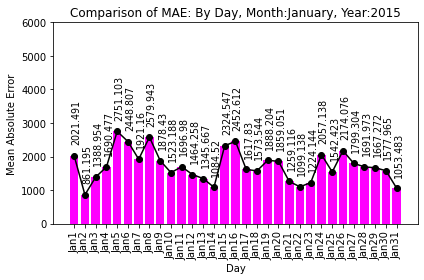

In [ ]:
# Ploting a bar chart of MAE by Day in January
plt.bar(names, MAE, color = 'Magenta')
plt.plot(names, MAE, '-ok')
plt.title('Comparison of MAE: By Day, Month:January, Year:2015')
plt.xlabel('Day')
plt.ylabel('Mean Absolute Error')
plt.ylim(0,6000)
plt.xticks(rotation=90)
for index,data in enumerate(MAE):
    plt.text(x=index-0.25, y = data+400, s=f"{data}", rotation=90, fontdict=dict(fontsize= 9.5))
plt.tight_layout()
plt.show()

**Inference:**
1. The MAE is below 2500 for the month of January.
2. The least MAE is 861 and the highest is 2751.
3. Overall this month shows lower prediction errors, but they vary by the day.  


### MAE By Day in July

In [ ]:
# MAE by Day in July

In [ ]:
# Extract Data by Day in July
Day = [pd.DataFrame(y) for x, y in July.groupby('Day', as_index=False)]

In [ ]:
Day[0] # July 1rst
Day[1] # July 2nd
Day[30] # July 31rst ..

Date  HE   tmpf  ...   Residuals  Absolute_Error  MAE_By_Hour
6304 2015-07-31 00:00:00   0  80.96  ... -6431.11475      6431.11475     0.611439
6305 2015-07-31 01:00:00   1  80.06  ... -5842.33137      5842.33137     0.555460
6306 2015-07-31 02:00:00   2  78.98  ... -4641.23006      4641.23006     0.441265
6307 2015-07-31 03:00:00   3  77.00  ... -2969.33451      2969.33451     0.282310
6308 2015-07-31 04:00:00   4  75.92  ...  -999.82668       999.82668     0.095059
6309 2015-07-31 05:00:00   5  73.04  ...   558.74981       558.74981     0.053123
6310 2015-07-31 06:00:00   6  73.04  ...  1139.75971      1139.75971     0.108363
6311 2015-07-31 07:00:00   7  73.04  ...  2106.47134      2106.47134     0.200273
6312 2015-07-31 08:00:00   8  73.04  ...  4681.14280      4681.14280     0.445060
6313 2015-07-31 09:00:00   9  80.06  ...  5777.55958      5777.55958     0.549302
6314 2015-07-31 10:00:00  10  82.94  ...  6175.29423      6175.29423     0.587117
6315 2015-07-31 11:00:00  11  87.98  ...  6394.98288      6394.98288     0.608004
6316 2015-07-31 12:00:00  12  89.96  ...  6170.73438      6170.73438     0.586683
6317 2015-07-31 13:00:00  13  93.92  ...  4986.21189      4986.21189     0.474065
6318 2015-07-31 14:00:00  14  93.92  ...  3033.25078      3033.25078     0.288387
6319 2015-07-31 15:00:00  15  96.08  ...   753.80042       753.80042     0.071668
6320 2015-07-31 16:00:00  16  95.00  ... -1127.83853      1127.83853     0.107229
6321 2015-07-31 17:00:00  17  96.98  ... -3464.46567      3464.46567     0.329384
6322 2015-07-31 18:00:00  18  96.08  ... -5262.93813      5262.93813     0.500374
6323 2015-07-31 19:00:00  19  96.08  ... -5717.54857      5717.54857     0.543597
6324 2015-07-31 20:00:00  20  93.02  ... -5468.20878      5468.20878     0.519891
6325 2015-07-31 21:00:00  21  91.04  ... -7140.41612      7140.41612     0.678876
6326 2015-07-31 22:00:00  22  87.98  ... -8811.06009      8811.06009     0.837713
6327 2015-07-31 23:00:00  23  84.92  ... -7963.46099      7963.46099     0.757127

[24 rows x 29 columns]

In [ ]:
# Calculating MAE by Day in July
July1 = mean_absolute_error(Day[0].MWh, Day[0].Predictions)
July2 = mean_absolute_error(Day[1].MWh, Day[1].Predictions)
July3 = mean_absolute_error(Day[2].MWh, Day[2].Predictions)
July4 = mean_absolute_error(Day[3].MWh, Day[3].Predictions)
July5 = mean_absolute_error(Day[4].MWh, Day[4].Predictions)
July6 = mean_absolute_error(Day[5].MWh, Day[5].Predictions)
July7 = mean_absolute_error(Day[6].MWh, Day[6].Predictions)
July8 = mean_absolute_error(Day[7].MWh, Day[7].Predictions)
July9 = mean_absolute_error(Day[8].MWh, Day[8].Predictions)
July10 = mean_absolute_error(Day[9].MWh, Day[9].Predictions)
July11 = mean_absolute_error(Day[10].MWh, Day[10].Predictions)
July12 = mean_absolute_error(Day[11].MWh, Day[11].Predictions)
July13 = mean_absolute_error(Day[12].MWh, Day[12].Predictions)
July14 = mean_absolute_error(Day[13].MWh, Day[13].Predictions)
July15 = mean_absolute_error(Day[14].MWh, Day[14].Predictions)
July16 = mean_absolute_error(Day[15].MWh, Day[15].Predictions)
July17 = mean_absolute_error(Day[16].MWh, Day[16].Predictions)
July18 = mean_absolute_error(Day[17].MWh, Day[17].Predictions)
July19 = mean_absolute_error(Day[18].MWh, Day[18].Predictions)
July20 = mean_absolute_error(Day[19].MWh, Day[19].Predictions)
July21 = mean_absolute_error(Day[20].MWh, Day[20].Predictions)
July22 = mean_absolute_error(Day[21].MWh, Day[21].Predictions)
July23 = mean_absolute_error(Day[22].MWh, Day[22].Predictions)
July24 = mean_absolute_error(Day[23].MWh, Day[23].Predictions)
July25 = mean_absolute_error(Day[24].MWh, Day[24].Predictions)
July26 = mean_absolute_error(Day[25].MWh, Day[25].Predictions)
July27 = mean_absolute_error(Day[26].MWh, Day[26].Predictions)
July28 = mean_absolute_error(Day[27].MWh, Day[27].Predictions)
July29 = mean_absolute_error(Day[28].MWh, Day[28].Predictions)
July30 = mean_absolute_error(Day[29].MWh, Day[29].Predictions)
July31 = mean_absolute_error(Day[30].MWh, Day[30].Predictions)

In [ ]:
# Create a list of Days in July and the corressponding MAE values
names = ['July1','July2','July3',"July4",'July5','July6','July7','July8','July9','July10','July11','July12','July13','July14','July15','July16','July17','July18','July19','July20','July21','July22','July23','July24','July25','July26','July27','July28','July29','July30','July31']
MAE = [round(July1,3),round(July2,3),round(July3,3),round(July4,3),round(July5,3), round(July6,3),
       round(July7,3),round(July8,3),round(July9,3),round(July10,3),round(July11,3), round(July12,3),
        round(July13,3),round(July14,3),round(July15,3),round(July16,3),round(July17,3), round(July18,3),
        round(July19,3),round(July20,3),round(July21,3),round(July22,3),round(July23,3), round(July24,3),
        round(July25,3),round(July26,3),round(July27,3),round(July28,3),round(July29,3), round(July30,3),round(July31,3)]

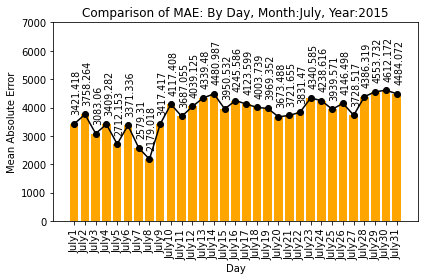

In [ ]:
# Ploting a bar chart of MAE by Day in July
plt.bar(names, MAE, color = 'Orange')
plt.plot(names, MAE, '-ok')
plt.title('Comparison of MAE: By Day, Month:July, Year:2015')
plt.xlabel('Day')
plt.ylabel('Mean Absolute Error')
plt.ylim(0,7000)
plt.xticks(rotation=90)
for index,data in enumerate(MAE):
    plt.text(x=index-0.25, y = data+400, s=f"{data}", rotation=90, fontdict=dict(fontsize= 9.5))
plt.tight_layout()
plt.show()

**Inference:**

1. July month shows higher MAE values. The highest is 4612.
2. From when the summer heat kicks in, the predictions are a bit off the actual values.
3. The range is between 2719 to 4612.
4. The middle of the month to the end do not show too much variation, all MAE values fall between 3900 to 4400.


### MAE By Day in December

In [ ]:
# MAE by Day for the Month of December

In [ ]:
# Extract Data by Day in December
Day = [pd.DataFrame(y) for x, y in Dec.groupby('Day', as_index=False)]

In [ ]:
# Calculating MAE by Day in December
Dec1 = mean_absolute_error(Day[0].MWh, Day[0].Predictions)
Dec2 = mean_absolute_error(Day[1].MWh, Day[1].Predictions)
Dec3 = mean_absolute_error(Day[2].MWh, Day[2].Predictions)
Dec4 = mean_absolute_error(Day[3].MWh, Day[3].Predictions)
Dec5 = mean_absolute_error(Day[4].MWh, Day[4].Predictions)
Dec6 = mean_absolute_error(Day[5].MWh, Day[5].Predictions)
Dec7 = mean_absolute_error(Day[6].MWh, Day[6].Predictions)
Dec8 = mean_absolute_error(Day[7].MWh, Day[7].Predictions)
Dec9 = mean_absolute_error(Day[8].MWh, Day[8].Predictions)
Dec10 = mean_absolute_error(Day[9].MWh, Day[9].Predictions)
Dec11 = mean_absolute_error(Day[10].MWh, Day[10].Predictions)
Dec12 = mean_absolute_error(Day[11].MWh, Day[11].Predictions)
Dec13 = mean_absolute_error(Day[12].MWh, Day[12].Predictions)
Dec14 = mean_absolute_error(Day[13].MWh, Day[13].Predictions)
Dec15 = mean_absolute_error(Day[14].MWh, Day[14].Predictions)
Dec16 = mean_absolute_error(Day[15].MWh, Day[15].Predictions)
Dec17 = mean_absolute_error(Day[16].MWh, Day[16].Predictions)
Dec18 = mean_absolute_error(Day[17].MWh, Day[17].Predictions)
Dec19 = mean_absolute_error(Day[18].MWh, Day[18].Predictions)
Dec20 = mean_absolute_error(Day[19].MWh, Day[19].Predictions)
Dec21 = mean_absolute_error(Day[20].MWh, Day[20].Predictions)
Dec22 = mean_absolute_error(Day[21].MWh, Day[21].Predictions)
Dec23 = mean_absolute_error(Day[22].MWh, Day[22].Predictions)
Dec24 = mean_absolute_error(Day[23].MWh, Day[23].Predictions)
Dec25 = mean_absolute_error(Day[24].MWh, Day[24].Predictions)
Dec26 = mean_absolute_error(Day[25].MWh, Day[25].Predictions)
Dec27 = mean_absolute_error(Day[26].MWh, Day[26].Predictions)
Dec28 = mean_absolute_error(Day[27].MWh, Day[27].Predictions)
Dec29 = mean_absolute_error(Day[28].MWh, Day[28].Predictions)
Dec30 = mean_absolute_error(Day[29].MWh, Day[29].Predictions)
Dec31 = mean_absolute_error(Day[30].MWh, Day[30].Predictions)

In [ ]:
# Create a list of Days in December and the corressponding MAE values
names = ['Dec1','Dec2','Dec3',"Dec4",'Dec5','Dec6','Dec7','Dec8','Dec9','Dec10','Dec11','Dec12','Dec13','Dec14','Dec15','Dec16','Dec17','Dec18','Dec19','Dec20','Dec21','Dec22','Dec23','Dec24','Dec25','Dec26','Dec27','Dec28','Dec29','Dec30','Dec31']
MAE = [round(Dec1,3),round(Dec2,3),round(Dec3,3),round(Dec4,3),round(Dec5,3), round(Dec6,3),
       round(Dec7,3),round(Dec8,3),round(Dec9,3),round(Dec10,3),round(Dec11,3), round(Dec12,3),
        round(Dec13,3),round(Dec14,3),round(Dec15,3),round(Dec16,3),round(Dec17,3), round(Dec18,3),
        round(Dec19,3),round(Dec20,3),round(Dec21,3),round(Dec22,3),round(Dec23,3), round(Dec24,3),
        round(Dec25,3),round(Dec26,3),round(Dec27,3),round(Dec28,3),round(Dec29,3), round(Dec30,3),round(Dec31,3)]

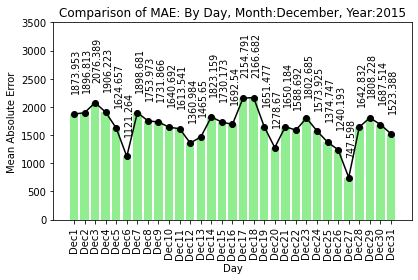

In [ ]:
# Ploting a bar chart of MAE by Day in December
plt.bar(names, MAE, color = 'Lightgreen')
plt.plot(names, MAE, '-ok')
plt.title('Comparison of MAE: By Day, Month:December, Year:2015')
plt.xlabel('Day')
plt.ylabel('Mean Absolute Error')
plt.ylim(0,3500)
plt.xticks(rotation=90)
for index,data in enumerate(MAE):
    plt.text(x=index-0.25, y = data+400, s=f"{data}", rotation=90, fontdict=dict(fontsize= 9.5))
plt.tight_layout()
plt.show()

**Inference:**

1. December month shows lowes MAE. Much lower than middle of the year prediction errors.
2. The maximum MAE is 2154, and the lowest is 747.
3. It was interesting to see how the average error fluctuates over the months and time period.
4. Summer months surely have the highest demand.


# ***Conclusion***

**Modeling Aspects:**

1. Our best Performing model, was model-10.

2. The architecture of the model included 2 stacked GRU layers with 30 and 15 hidden units, linear activation function and a drop  out of 0.01, with "Adam" Optimizer.  

3. The final epoch showed a validation (20% of the train data) MAE of ~ 602 and the test MAE was ~585. We used early stopping to prevent overfitting.

4. We included the 5 important weather variables in our input data as these 5 variables are the components that help describe the weather at any point. These variables are temperature(tmpf), humidity(relh), temperature(tmpf), dew point(dwpf), atmospheric pressure(mslp) and cloudiness (given by skc1).

5. We additionally included "vsby", "feel" and "hour". "Vsby" describes the visibility in miles, also helps support the cloudiness and presence of fog that can alter or affect the energy usage. We included the "feel" and "hour" variable as these variables showed some positive correlation (~0.45) with the target variable. This is also intuitive, as based on how hot or cold the weather is the energy usage varies and "hour" is important as in general afternoons can be more warmer than nights. So usage of air conditioning can be more in the afternoons than nights.

6. The model architecture was simple, and we think it did well because GRU consists of only two gates, a less complex architecture,  that help decide which information from the data to keep and pass on forward to make the predictions.

7. The simpler architecture when compared to LSTMs, and faster operation due to fewer gates, turned out to be the best fit for our data and generated predictions with the lowest MAE.

8. A linear activation function worked well as opposed to the non-linearity activation functions, reflecting the simplicity of the data and the relationships between the variables that are rather starightforward.

9. The analysis and results of the model showed that, the model predicted well, did not over predict or under predict and was able to genaralize the pattern in the energy demand. The erros over the summer months seemed to be higher, while the other months showed lower MAE values.

10. Model-10 also beats the baseline MAE of 1199. The baseline model considered the prediction for today as the actual value from the previous time step.  (Shown in the Appendix)

11. Our second best model was Model-1, with an MAE of 2519. This model had a  simple RNN layer, which gives more weightage to the last time step more than the earlier ones, due to the vanishing gradient issue.

12. Finally, though we could not reproduce Model-10 due to random weight initialization, if we could save the optimized weights from the model from next time or in the furture, then we believe Model-10 could be potentially used to forecast energy demand robustly.




**EDA Aspects:**

1. Each predictor variable and the target variable have different time series plots and their behavior with respect to the time i.e year/month/day has been observed to vary quite a lot
2. Count of the various predictor variables with respect to the month, day, part of the day showed how the these variables such as visibility, temperature, relative humidity are varying by each given day, month and part of the day. It shows the frequency of the variables.
3. We observed that the target variable’s (energy demand) variation during different parts of the day stayed mostly within the range and we did not observe any whiskers in the boxplots. However, there is slight modulation in the median values .
4. Subsetting the target (MWh - energy demand) gave us an idea about how energy demand has been changing for the years 2011, 2012, 2013 and 2014.
5. Looking into the distribution of the target variable and the predictors helped us to see how our data is distributed. While some are close to a normal distribution, few are skewed.


# ***References***


1) https://ehsdailyadvisor.blr.com/2021/03/power-crisis-in-texas-how-one-cold-week-decimated-the-states-energy-grid/

2) https://en.wikipedia.org/wiki/2021_Texas_power_crisis

3) https://www.texastribune.org/2021/03/18/power-outage-electric-grid-texas-house/

4) http://blogs.edf.org/energyexchange/2020/05/15/ercot-forecast-and-new-analysis-show-the-texas-grid-moving-away-from-fossil-fuels/

5) https://www.eia.gov/todayinenergy/detail.php?id=46836

6) https://www.texasmonthly.com/news-politics/ed-hirs-predicting-blackouts/

7) https://www.texastribune.org/2021/04/15/texas-ercot-blackouts-summer-climate/

8) https://www.vox.com/22308149/texas-blackout-power-outage-winter-uri-grid-ercot

9) https://www.bloomberg.com/news/articles/2021-04-13/texas-warns-of-tight-power-supplies-just-months-after-crisis

10) https://washingtonmonthly.com/2021/02/20/texas-blackout-of-2021-was-primarily-a-human-failure/

# ***APPENDIX***

## Model-1

In [ ]:
# Model-1

In [ ]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# RNN-specific modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Converting  data type to float32
X = np.asarray(X).astype(np.float32)

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model1 = Sequential()
model1.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse',metrics=['mae'])
model1.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model1.fit(X, y,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 30)                1380      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6116/6116 [==============================] - 12s 2ms/step - loss: 228680920.4133 - mae: 10070.1910 - val_loss: 41539236.0000 - val_mae: 5266.4248
Epoch 2/500
6116/6116 [==============================] - 10s 2ms/step - loss: 43403848.5284 - mae: 5189.3640 - val_loss: 25890248.0000 - val_mae: 3931.5598
Epoch 3/500
6116/6116 [==============================] - 11s 2ms/step - loss: 25792187.8058 - mae: 3995.1003 - val_loss: 20773714.0000 - val_mae: 3574.6772
Epoch 4/500
6116/6116 [=====================

MAE:  2519.7283991637705


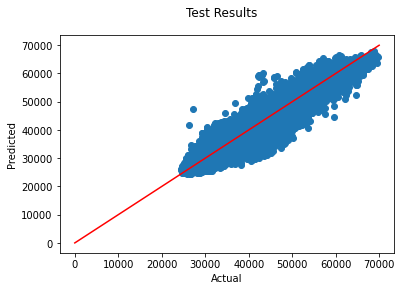

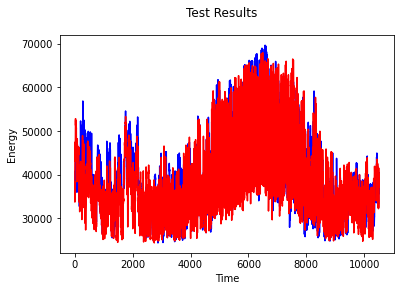

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction on test data
M1_pred = model1.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M1_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M1_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M1_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-2

In [ ]:
# Model-2

In [ ]:
# define model
model2 = Sequential()
model2.add(LSTM(30, input_shape=(n_steps,n_features), activation='relu', recurrent_dropout=0.2))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse',metrics=['mae'])
model2.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model2.fit(X, y,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30)                5520      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 31        
Total params: 5,551
Trainable params: 5,551
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6116/6116 [==============================] - 22s 3ms/step - loss: 261295426.1357 - mae: 11235.5483 - val_loss: 32918898.0000 - val_mae: 4708.6958
Epoch 2/500
6116/6116 [==============================] - 20s 3ms/step - loss: 59223876.2328 - mae: 6022.0079 - val_loss: 33693876.0000 - val_mae: 4427.6641
Epoch 3/500
6116/6116 [==============================] - 20s 3ms/step - loss: 46322192.2433 - mae: 5249.4250 - val_loss: 22028386.0000 - val_mae: 3601.1550
Epoch 4/500
6116/6116 [====================

MAE:  3461.5373941361177


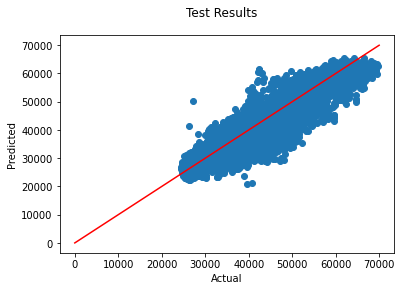

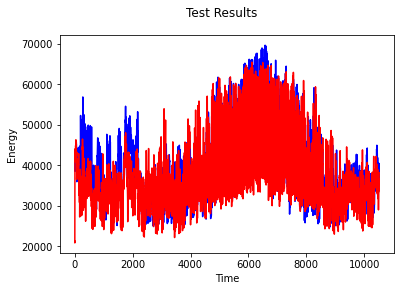

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction on test data
M2_pred = model2.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M2_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M2_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M2_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-3

In [ ]:
# Model-3

In [ ]:
# define model
model3 = Sequential()
model3.add(LSTM(300, input_shape=(n_steps,n_features), activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse',metrics=['mae'])
model3.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model3.fit(X, y,
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               379200    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 379,501
Trainable params: 379,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 61s 11ms/step - loss: 96441504.7885 - mae: 6024.3694 - val_loss: 22824250.0000 - val_mae: 3596.5010
Epoch 2/500
5351/5351 [==============================] - 56s 10ms/step - loss: 15204978.1276 - mae: 3024.7018 - val_loss: 31275406.0000 - val_mae: 4322.0894
Epoch 3/500
5351/5351 [==============================] - 56s 11ms/step - loss: 13766227.5056 - mae: 2855.5508 - val_loss: 19943468.0000 - val_mae: 3301.1375
Epoch 4/500
5351/5351 [================

MAE:  2609.976656328342


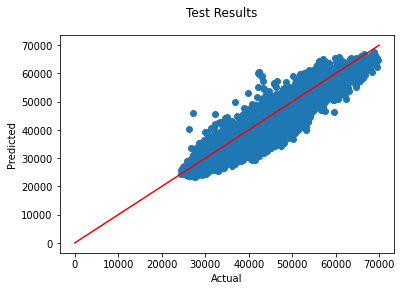

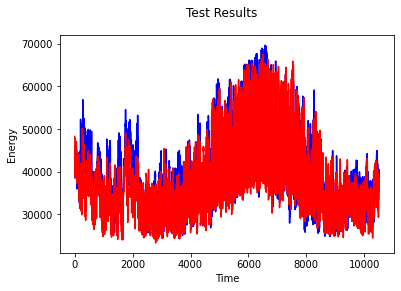

In [ ]:
# make a prediction on test data
M3_pred = model3.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M3_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M3_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M3_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-4

In [ ]:
# Model-4

In [ ]:
# standardize and Normalize the data
# Add drop out layers
# Weight regulazrition, learning rate and decay rate
# Look at the electricity data for one hour and look for patterns that can help with model building
# Grid Search for parameters
# Look back period = 24 , increase batch size
# check independent variable description

In [ ]:
# Normalize the data

In [ ]:
# Advanced Models

In [ ]:
# Uses only df_subset data with rolling averages, n steps = 10

In [ ]:
model4 = Sequential()
model4.add(LSTM(30, input_shape=(n_steps,n_features), activation='relu', recurrent_dropout=0.1))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse',metrics=['mae'])
model4.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model4.fit(X, y,
          epochs=100,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5350/5350 [==============================] - 32s 6ms/step - loss: 330793353.3739 - mae: 12078.5889 - val_loss: 30039138.0000 - val_mae: 4146.8140
Epoch 2/100
5350/5350 [==============================] - 31s 6ms/step - loss: 21568826.4145 - mae: 3591.6082 - val_loss: 31372780.0000 - val_mae: 4236.6270
Epoch 3/100
5350/5350 [==============================] - 30s 6ms/step - loss: 19301466.5367 - mae: 3394.8435 - val_loss: 30033680.0000 - val_mae: 4168.3486
Epoch 4/100
5350/5350 [=========================

MAE:  3510.353121766372


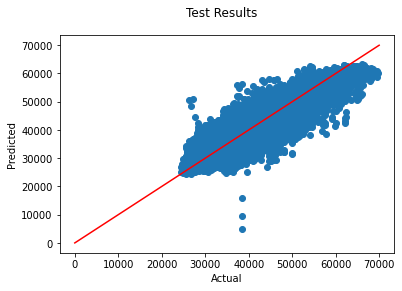

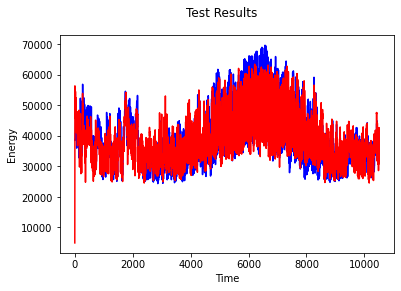

In [ ]:
# make a prediction on test data
M4_pred = model4.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M4_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M4_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M4_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-5

In [ ]:
# Model-5

In [ ]:
# Standardize the data

In [ ]:
# n_steps = 24, using all the variables in the data

In [ ]:
#from keras.layers import Bidirectional

model5 = Sequential()
model5.add(SimpleRNN(30, activation='relu'))
model5.add(Dense(1))
model5.compile(optimizer='adam', loss='mse',metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model5.fit(X, y,
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)


Epoch 1/100
6112/6112 [==============================] - 29s 5ms/step - loss: 99534622.3857 - mae: 6658.2989 - val_loss: 31165328.0000 - val_mae: 4138.5903
Epoch 2/100
6112/6112 [==============================] - 28s 5ms/step - loss: 35181801.4510 - mae: 4539.1285 - val_loss: 30758288.0000 - val_mae: 4320.1040
Epoch 3/100
6112/6112 [==============================] - 28s 5ms/step - loss: 30763840.0105 - mae: 4242.8692 - val_loss: 29654648.0000 - val_mae: 4114.0645
Epoch 4/100
6112/6112 [==============================] - 27s 4ms/step - loss: 29283035.7653 - mae: 4124.7974 - val_loss: 27870280.0000 - val_mae: 4038.7427
Epoch 5/100
6112/6112 [==============================] - 28s 5ms/step - loss: 27456360.3280 - mae: 3995.0942 - val_loss: 26615544.0000 - val_mae: 3920.9875
Epoch 6/100
6112/6112 [==============================] - 27s 4ms/step - loss: 26043906.4358 - mae: 3888.0227 - val_loss: 54051476.0000 - val_mae: 5872.4121
Epoch 7/100
6112/6112 [==============================] - 26s 4ms

MAE:  3855.765025834876


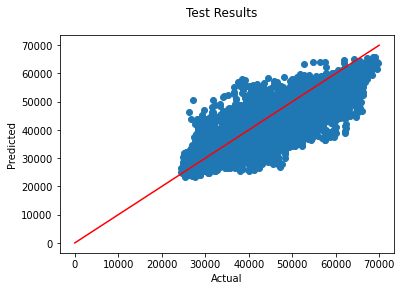

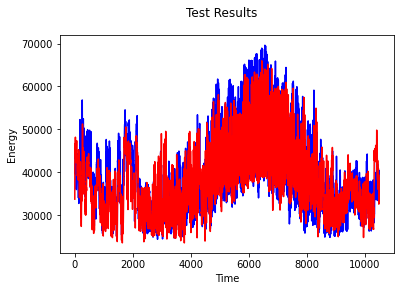

In [ ]:
# make a prediction on test data
M5_pred = model5.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M5_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M5_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M5_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-6

In [ ]:
ercot_data.corr(method = "pearson")

tmpf      dwpf      relh  ...       Day   Weekend       MWh
tmpf         1.000000  0.453107 -0.501309  ... -0.016668  0.006598  0.507672
dwpf         0.453107  1.000000  0.472182  ... -0.014306  0.013578  0.301505
relh        -0.501309  0.472182  1.000000  ... -0.002656  0.015504 -0.182045
sknt         0.181515  0.080327 -0.113868  ...  0.005639 -0.004765  0.073696
vsby         0.220501 -0.012755 -0.322862  ...  0.005182 -0.018317  0.002955
tmpf_5       0.968749  0.474320 -0.459250  ... -0.016247  0.006568  0.488982
dwpf_5       0.473775  0.978141  0.446456  ... -0.013802  0.014196  0.313822
relh_5      -0.465032  0.450761  0.947626  ... -0.002808  0.016146 -0.148812
sknt_5       0.172269  0.087465 -0.094265  ...  0.004614 -0.006700  0.040650
vsby_5       0.274611 -0.011944 -0.396032  ...  0.004991 -0.026262 -0.002827
Hour         0.254084 -0.072809 -0.286777  ...  0.000444 -0.005157  0.454285
part_of_day -0.099970  0.039729  0.093333  ... -0.001395  0.001422  0.015814
Month        0.065193  0.307161  0.231186  ... -0.015385  0.019069  0.110562
Day         -0.016668 -0.014306 -0.002656  ...  1.000000 -0.162466  0.040425
Weekend      0.006598  0.013578  0.015504  ... -0.162466  1.000000 -0.129330
MWh          0.507672  0.301505 -0.182045  ...  0.040425 -0.129330  1.000000

[16 rows x 16 columns]

In [ ]:
trial = ercot_data

In [ ]:
trial.head()

tmpf   dwpf   relh  sknt  ...  Month  Day  Weekend           MWh
0  32.00  17.96  55.72   8.0  ...      1    2        1  28496.388850
1  33.08  19.04  55.89   7.0  ...      1    2        1  27662.443480
2  33.08  17.96  53.36   9.0  ...      1    2        1  27250.044715
3  32.00  19.04  58.37   7.0  ...      1    2        1  26783.226081
4  30.02  19.04  63.24   7.0  ...      1    2        1  26676.468490

[5 rows x 16 columns]

In [ ]:
trial['energy_5'] = ercot_data.iloc[:,15].rolling(window=5).mean()

In [ ]:
trial['energy_10'] =  ercot_data.iloc[:,15].rolling(window=10).mean()

In [ ]:
trial['energy_24'] =  ercot_data.iloc[:,15].rolling(window=24).mean()

In [ ]:
trial.head(10)

tmpf   dwpf   relh  ...      energy_5     energy_10  energy_24
0  32.00  17.96  55.72  ...           NaN           NaN        NaN
1  33.08  19.04  55.89  ...           NaN           NaN        NaN
2  33.08  17.96  53.36  ...           NaN           NaN        NaN
3  32.00  19.04  58.37  ...           NaN           NaN        NaN
4  30.02  19.04  63.24  ...  27373.714323           NaN        NaN
5  32.00  21.02  63.51  ...  27048.197061           NaN        NaN
6  33.08  21.02  60.81  ...  27043.859377           NaN        NaN
7  33.08  17.96  53.36  ...  27347.626209           NaN        NaN
8  33.98  14.00  43.34  ...  27907.088014           NaN        NaN
9  35.06   6.98  30.35  ...  28662.766371  28018.240347        NaN

[10 rows x 19 columns]

In [ ]:
trial.corr(method = "pearson") # energy_5 is most correlated to MWh followed by Energy_10 and energy_24

tmpf      dwpf      relh  ...  energy_5  energy_10  energy_24
tmpf         1.000000  0.453107 -0.501309  ...  0.492083   0.423482   0.416590
dwpf         0.453107  1.000000  0.472182  ...  0.328905   0.395362   0.496166
relh        -0.501309  0.472182  1.000000  ... -0.154155  -0.046373   0.054513
sknt         0.181515  0.080327 -0.113868  ...  0.104771   0.098206   0.019304
vsby         0.220501 -0.012755 -0.322862  ...  0.009690   0.016568   0.015572
tmpf_5       0.968749  0.474320 -0.459250  ...  0.513456   0.487822   0.428031
dwpf_5       0.473775  0.978141  0.446456  ...  0.324729   0.378155   0.501410
relh_5      -0.465032  0.450761  0.947626  ... -0.167754  -0.108931   0.051604
sknt_5       0.172269  0.087465 -0.094265  ...  0.085521   0.110030   0.028323
vsby_5       0.274611 -0.011944 -0.396032  ...  0.006826   0.016695   0.022498
Hour         0.254084 -0.072809 -0.286777  ...  0.395258   0.222620   0.011808
part_of_day -0.099970  0.039729  0.093333  ...  0.108876   0.146815   0.024574
Month        0.065193  0.307161  0.231186  ...  0.114935   0.125076   0.150236
Day         -0.016668 -0.014306 -0.002656  ...  0.041204   0.045242   0.060096
Weekend      0.006598  0.013578  0.015504  ... -0.132408  -0.137634  -0.127355
MWh          0.507672  0.301505 -0.182045  ...  0.941505   0.787541   0.721290
energy_5     0.492083  0.328905 -0.154155  ...  1.000000   0.928336   0.762676
energy_10    0.423482  0.395362 -0.046373  ...  0.928336   1.000000   0.841770
energy_24    0.416590  0.496166  0.054513  ...  0.762676   0.841770   1.000000

[19 rows x 19 columns]

In [ ]:
trial.replace(np.nan, 0, inplace=True)

In [ ]:

trial.insert(len(trial.columns)-1, 'MWh', trial.pop('MWh'))

In [ ]:
trial.head()

tmpf   dwpf   relh  sknt  ...      energy_5  energy_10  energy_24           MWh
0  32.00  17.96  55.72   8.0  ...      0.000000        0.0        0.0  28496.388850
1  33.08  19.04  55.89   7.0  ...      0.000000        0.0        0.0  27662.443480
2  33.08  17.96  53.36   9.0  ...      0.000000        0.0        0.0  27250.044715
3  32.00  19.04  58.37   7.0  ...      0.000000        0.0        0.0  26783.226081
4  30.02  19.04  63.24   7.0  ...  27373.714323        0.0        0.0  26676.468490

[5 rows x 19 columns]

In [ ]:
# Rolling Averges per yer
df.Date

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
38218    2014-12-31 22:00:00
38219    2014-12-31 22:00:00
38220    2014-12-31 23:00:00
38221    2014-12-31 23:00:00
38222    2014-12-31 23:00:00
Name: Date, Length: 38223, dtype: object

In [ ]:
# Calculate Energy Demand from Previous Years
df['Date'] = pd.to_datetime(df['Date'], errors = "coerce")
df.dtypes

Date           datetime64[ns]
tmpf                  float64
dwpf                  float64
relh                  float64
sknt                  float64
vsby                  float64
tmpf_5                float64
dwpf_5                float64
relh_5                float64
sknt_5                float64
vsby_5                float64
Hour                    int64
part_of_day             int64
Month                   int64
Day                     int64
Weekend                 int64
MWh                   float64
Year           datetime64[ns]
dtype: object

In [ ]:
df['Year'] = df['Date'].dt.year

In [ ]:
df.head()

Date   tmpf   dwpf   relh  ...  Day  Weekend           MWh  Year
0 2011-01-01 00:00:00  32.00  17.96  55.72  ...    2        1  28496.388850  2011
1 2011-01-01 01:00:00  33.08  19.04  55.89  ...    2        1  27662.443480  2011
2 2011-01-01 02:00:00  33.08  17.96  53.36  ...    2        1  27250.044715  2011
3 2011-01-01 03:00:00  32.00  19.04  58.37  ...    2        1  26783.226081  2011
4 2011-01-01 04:00:00  30.02  19.04  63.24  ...    2        1  26676.468490  2011

[5 rows x 18 columns]

In [ ]:
# Rolling averages based on year to add to test data
year_2011 = df.loc[df['Year'] == 2011]
year_2012 = df.loc[df['Year'] == 2012]
year_2013 = df.loc[df['Year'] == 2013]
year_2014 = df.loc[df['Year'] == 2014]

#trial['energy_5'] = ercot_data.iloc[:,15].rolling(window=5).mean()

In [ ]:
year_2011.shape

(9299, 18)

In [ ]:
year_2012.shape

(9626, 18)

In [ ]:
year_2013.shape

(9589, 18)

In [ ]:
year_2014.shape

(9709, 18)

In [ ]:
# Rolling average per year for all the years
year_2011['energy_5'] = year_2011.iloc[:,16].rolling(window=5).mean()
year_2012['energy_5'] = year_2012.iloc[:,16].rolling(window=5).mean()
year_2013['energy_5'] = year_2013.iloc[:,16].rolling(window=5).mean()
year_2014['energy_5'] = year_2014.iloc[:,16].rolling(window=5).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
year_2011 = year_2011.reset_index(drop=True)
year_2011

Date   tmpf   dwpf  ...           MWh  Year      energy_5
0    2011-01-01 00:00:00  32.00  17.96  ...  28496.388850  2011           NaN
1    2011-01-01 01:00:00  33.08  19.04  ...  27662.443480  2011           NaN
2    2011-01-01 02:00:00  33.08  17.96  ...  27250.044715  2011           NaN
3    2011-01-01 03:00:00  32.00  19.04  ...  26783.226081  2011           NaN
4    2011-01-01 04:00:00  30.02  19.04  ...  26676.468490  2011  27373.714323
...                  ...    ...    ...  ...           ...   ...           ...
9294 2011-12-31 19:00:00  66.02  19.94  ...  32482.119728  2011  29922.484376
9295 2011-12-31 20:00:00  64.04  19.94  ...  31727.376187  2011  30477.878344
9296 2011-12-31 21:00:00  62.06  21.02  ...  30593.699201  2011  30825.841534
9297 2011-12-31 22:00:00  55.94  21.92  ...  29454.284058  2011  30918.369193
9298 2011-12-31 23:00:00  53.96  23.00  ...  28292.615393  2011  30510.018913

[9299 rows x 19 columns]

In [ ]:
year_2012 = year_2012.reset_index(drop=True)
year_2013 = year_2013.reset_index(drop=True)
year_2014 = year_2014.reset_index(drop=True)

In [ ]:
trial2 = ercot_data_test

In [ ]:
trial2['2011_Avg_Demand'] = year_2011['energy_5']

In [ ]:
trial2['2012_Avg_Demand'] = year_2012['energy_5']

In [ ]:
trial2['2013_Avg_Demand'] = year_2013['energy_5']

In [ ]:
trial2['2014_Avg_Demand'] = year_2014['energy_5']

In [ ]:
# Replace NaNs with avg of the column
trial2['2011_Avg_Demand'].replace(np.nan, trial2['2011_Avg_Demand'].mean(), inplace=True)
trial2['2012_Avg_Demand'].replace(np.nan, trial2['2012_Avg_Demand'].mean(), inplace=True)
trial2['2013_Avg_Demand'].replace(np.nan, trial2['2013_Avg_Demand'].mean(), inplace=True)
trial2['2014_Avg_Demand'].replace(np.nan, trial2['2014_Avg_Demand'].mean(), inplace=True)

In [ ]:
del trial2['Unnamed: 0']

In [ ]:
trial2

Date           MWh  ...  2013_Avg_Demand  2014_Avg_Demand
0      2015-01-01 00:00:00  40707.660350  ...              NaN              NaN
1      2015-01-01 00:00:00  40707.660350  ...              NaN              NaN
2      2015-01-01 00:00:00  40707.660350  ...              NaN              NaN
3      2015-01-01 01:00:00  39624.861027  ...              NaN              NaN
4      2015-01-01 02:00:00  39013.544802  ...     28166.309147     35706.164707
...                    ...           ...  ...              ...              ...
10515  2015-12-31 22:00:00  36929.975190  ...              NaN              NaN
10516  2015-12-31 22:00:00  36929.975190  ...              NaN              NaN
10517  2015-12-31 22:00:00  36929.975190  ...              NaN              NaN
10518  2015-12-31 23:00:00  35660.210526  ...              NaN              NaN
10519  2015-12-31 23:00:00  35660.210526  ...              NaN              NaN

[10520 rows x 21 columns]

In [ ]:
# drop duplicate entries
trial2 = trial2.drop_duplicates('Date')

In [ ]:
# reset index
trial2 = trial2.reset_index(drop=True)

In [ ]:
trial2

Date           MWh  ...  2013_Avg_Demand  2014_Avg_Demand
0     2015-01-01 00:00:00  40707.660350  ...              NaN              NaN
1     2015-01-01 01:00:00  39624.861027  ...              NaN              NaN
2     2015-01-01 02:00:00  39013.544802  ...     28166.309147     35706.164707
3     2015-01-01 03:00:00  38566.541927  ...     27479.895092     35602.473788
4     2015-01-01 04:00:00  38488.338511  ...     30729.856225     36783.891461
...                   ...           ...  ...              ...              ...
8692  2015-12-31 19:00:00  40330.522636  ...              NaN              NaN
8693  2015-12-31 20:00:00  39268.536567  ...              NaN              NaN
8694  2015-12-31 21:00:00  38075.677924  ...              NaN              NaN
8695  2015-12-31 22:00:00  36929.975190  ...              NaN              NaN
8696  2015-12-31 23:00:00  35660.210526  ...              NaN              NaN

[8697 rows x 21 columns]

In [ ]:
trial2.replace(np.nan, 0, inplace=True)

In [ ]:
trial2

Date           MWh  ...  2013_Avg_Demand  2014_Avg_Demand
0     2015-01-01 00:00:00  40707.660350  ...         0.000000         0.000000
1     2015-01-01 01:00:00  39624.861027  ...         0.000000         0.000000
2     2015-01-01 02:00:00  39013.544802  ...     28166.309147     35706.164707
3     2015-01-01 03:00:00  38566.541927  ...     27479.895092     35602.473788
4     2015-01-01 04:00:00  38488.338511  ...     30729.856225     36783.891461
...                   ...           ...  ...              ...              ...
8692  2015-12-31 19:00:00  40330.522636  ...         0.000000         0.000000
8693  2015-12-31 20:00:00  39268.536567  ...         0.000000         0.000000
8694  2015-12-31 21:00:00  38075.677924  ...         0.000000         0.000000
8695  2015-12-31 22:00:00  36929.975190  ...         0.000000         0.000000
8696  2015-12-31 23:00:00  35660.210526  ...         0.000000         0.000000

[8697 rows x 21 columns]

In [ ]:
# prep data for modeling (multivariate)
# split train data into indepednet variable and target variable (X, y respectively)

from numpy import array

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in np.arange(len(sequences)): # be careful of this line!
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [ ]:
n_steps = 3
raw_seq = np.array(trial) #make sure your data is stored as a numpy array!
X, y = split_sequences(raw_seq, n_steps)

In [ ]:
X.shape

(38221, 3, 18)

In [ ]:
y.shape

(38221,)

In [ ]:
# Model-6

In [ ]:
model6 = Sequential()
model6.add(SimpleRNN(30, activation='relu'))
model6.add(Dense(1))
model6.compile(optimizer='adam', loss='mse',metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model6.fit(X, y,
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Epoch 1/100
6116/6116 [==============================] - 16s 2ms/step - loss: 46195889.6946 - mae: 3516.3577 - val_loss: 1829966.8750 - val_mae: 1073.8320
Epoch 2/100
6116/6116 [==============================] - 15s 2ms/step - loss: 1474056.3341 - mae: 929.9196 - val_loss: 860022.9375 - val_mae: 763.2636
Epoch 3/100
6116/6116 [==============================] - 15s 2ms/step - loss: 863463.4452 - mae: 710.9560 - val_loss: 465606.5938 - val_mae: 524.1501
Epoch 4/100
6116/6116 [==============================] - 15s 2ms/step - loss: 694252.5011 - mae: 633.8168 - val_loss: 363056.6250 - val_mae: 460.5210
Epoch 5/100
6116/6116 [==============================] - 15s 2ms/step - loss: 626553.3009 - mae: 596.7813 - val_loss: 515954.9688 - val_mae: 571.6871
Epoch 6/100
6116/6116 [==============================] - 15s 2ms/step - loss: 559924.5322 - mae: 551.6722 - val_loss: 329745.6562 - val_mae: 444.7211
Epoch 7/100
6116/6116 [==============================] - 16s 3ms/step - loss: 543797.4974 - ma

In [ ]:
## Add average of MWh from 2011 - 2014 to test data

In [ ]:
# label encode columns in test data
# Encode 'part of day'.
trial2['part_of_day']= label_encoder.fit_transform(trial2['part_of_day'])

# Encode 'day'.
trial2['Day']= label_encoder.fit_transform(trial2['Day'])


In [ ]:
trial2.replace(np.nan, 0, inplace=True)

In [ ]:
# Moving target variable MWh to the last in the test data
trial2.insert(len(trial2.columns)-1, 'MWh', trial2.pop('MWh'))

In [ ]:
trial2

Date   tmpf  ...  2014_Avg_Demand           MWh
0     2015-01-01 00:00:00  21.02  ...         0.000000  40707.660350
1     2015-01-01 01:00:00  21.92  ...         0.000000  39624.861027
2     2015-01-01 02:00:00  21.92  ...     35706.164707  39013.544802
3     2015-01-01 03:00:00  21.92  ...     35602.473788  38566.541927
4     2015-01-01 04:00:00  21.92  ...     36783.891461  38488.338511
...                   ...    ...  ...              ...           ...
8692  2015-12-31 19:00:00  46.94  ...         0.000000  40330.522636
8693  2015-12-31 20:00:00  44.96  ...         0.000000  39268.536567
8694  2015-12-31 21:00:00  42.98  ...         0.000000  38075.677924
8695  2015-12-31 22:00:00  39.92  ...         0.000000  36929.975190
8696  2015-12-31 23:00:00  41.00  ...         0.000000  35660.210526

[8697 rows x 21 columns]

In [ ]:
del trial2['Date']

In [ ]:
del trial2['2011_Avg_Demand']

In [ ]:
trial2 # This is the test data

tmpf   dwpf    relh  ...  2013_Avg_Demand  2014_Avg_Demand           MWh
0     21.02  21.02  100.00  ...         0.000000         0.000000  40707.660350
1     21.92  21.02   96.26  ...         0.000000         0.000000  39624.861027
2     21.92  21.02   96.26  ...     28166.309147     35706.164707  39013.544802
3     21.92  21.92  100.00  ...     27479.895092     35602.473788  38566.541927
4     21.92  21.92  100.00  ...     30729.856225     36783.891461  38488.338511
...     ...    ...     ...  ...              ...              ...           ...
8692  46.94  35.96   65.43  ...         0.000000         0.000000  40330.522636
8693  44.96  37.04   73.59  ...         0.000000         0.000000  39268.536567
8694  42.98  37.04   79.38  ...         0.000000         0.000000  38075.677924
8695  39.92  37.94   92.56  ...         0.000000         0.000000  36929.975190
8696  41.00  39.02   92.59  ...         0.000000         0.000000  35660.210526

[8697 rows x 19 columns]

In [ ]:
trial # this is the train data

tmpf   dwpf    relh  ...     energy_10     energy_24           MWh
0      32.00  17.96   55.72  ...      0.000000      0.000000  28496.388850
1      33.08  19.04   55.89  ...      0.000000      0.000000  27662.443480
2      33.08  17.96   53.36  ...      0.000000      0.000000  27250.044715
3      32.00  19.04   58.37  ...      0.000000      0.000000  26783.226081
4      30.02  19.04   63.24  ...      0.000000      0.000000  26676.468490
...      ...    ...     ...  ...           ...           ...           ...
38218  21.02  19.94   95.51  ...  45762.516832  46211.545805  43800.794552
38219  21.02  19.94   95.51  ...  45642.143848  46134.627432  43800.794552
38220  21.02  21.02  100.00  ...  45347.221002  45984.979950  42055.295929
38221  21.20  21.20  100.00  ...  45062.196370  45791.838989  42055.295929
38222  21.02  21.02  100.00  ...  44777.171738  45598.698028  42055.295929

[38223 rows x 19 columns]

In [ ]:
trial2.corr(method = "pearson")

tmpf      dwpf  ...  2014_Avg_Demand       MWh
tmpf             1.000000  0.651019  ...         0.328316  0.532972
dwpf             0.651019  1.000000  ...         0.333630  0.338955
relh            -0.621707  0.154329  ...        -0.087448 -0.295275
sknt             0.163487  0.125780  ...         0.062527  0.053887
vsby             0.340697  0.114973  ...         0.098092  0.024585
tmpf_5           0.969171  0.665955  ...         0.319733  0.509979
dwpf_5           0.669078  0.984717  ...         0.336312  0.352209
relh_5          -0.574504  0.140002  ...        -0.072576 -0.251416
sknt_5           0.143490  0.139023  ...         0.071739 -0.002751
vsby_5           0.363773  0.127035  ...         0.107839  0.012170
Hour             0.244704 -0.030672  ...         0.005822  0.457311
part_of_day     -0.112383  0.029405  ...        -0.024074  0.009741
Month            0.221386  0.187934  ...         0.016289  0.041487
Day              0.017721  0.007887  ...        -0.042127  0.021632
Weekend         -0.007584 -0.015886  ...         0.045833 -0.136952
2012_Avg_Demand  0.392199  0.409105  ...         0.447328  0.302018
2013_Avg_Demand  0.337204  0.322484  ...         0.388334  0.263212
2014_Avg_Demand  0.328316  0.333630  ...         1.000000  0.291140
MWh              0.532972  0.338955  ...         0.291140  1.000000

[19 rows x 19 columns]

In [ ]:
# store X_test as numpy array
X_test = np.array(trial2)

In [ ]:
# Slit test data into X and Y
X_test, y_test = split_sequences(X_test, n_steps=3)

In [ ]:
# Converting  data type to float32
X_test = np.asarray(X_test).astype(np.float32)

In [ ]:
X_test.shape

(8695, 3, 18)

In [ ]:
y_test.shape

(8695,)

MAE:  8606.909372458702


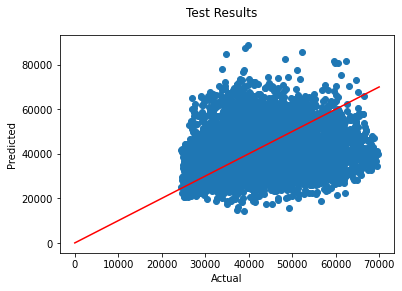

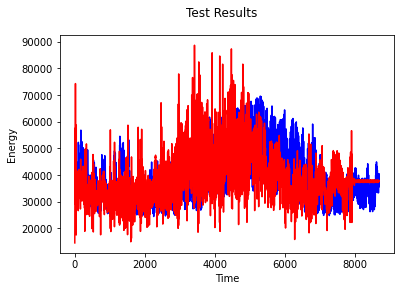

In [ ]:
# make a prediction on test data
M6_pred = model6.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M6_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M6_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M6_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-7

In [ ]:
# Model-7
# Considering only relevant features

In [ ]:
trial # Train data

tmpf   dwpf    relh  ...     energy_10     energy_24           MWh
0      32.00  17.96   55.72  ...      0.000000      0.000000  28496.388850
1      33.08  19.04   55.89  ...      0.000000      0.000000  27662.443480
2      33.08  17.96   53.36  ...      0.000000      0.000000  27250.044715
3      32.00  19.04   58.37  ...      0.000000      0.000000  26783.226081
4      30.02  19.04   63.24  ...      0.000000      0.000000  26676.468490
...      ...    ...     ...  ...           ...           ...           ...
38218  21.02  19.94   95.51  ...  45762.516832  46211.545805  43800.794552
38219  21.02  19.94   95.51  ...  45642.143848  46134.627432  43800.794552
38220  21.02  21.02  100.00  ...  45347.221002  45984.979950  42055.295929
38221  21.20  21.20  100.00  ...  45062.196370  45791.838989  42055.295929
38222  21.02  21.02  100.00  ...  44777.171738  45598.698028  42055.295929

[38223 rows x 19 columns]

In [ ]:
trial2 # Test Data

tmpf   dwpf    relh  ...  2013_Avg_Demand  2014_Avg_Demand           MWh
0     21.02  21.02  100.00  ...         0.000000         0.000000  40707.660350
1     21.92  21.02   96.26  ...         0.000000         0.000000  39624.861027
2     21.92  21.02   96.26  ...     28166.309147     35706.164707  39013.544802
3     21.92  21.92  100.00  ...     27479.895092     35602.473788  38566.541927
4     21.92  21.92  100.00  ...     30729.856225     36783.891461  38488.338511
...     ...    ...     ...  ...              ...              ...           ...
8692  46.94  35.96   65.43  ...         0.000000         0.000000  40330.522636
8693  44.96  37.04   73.59  ...         0.000000         0.000000  39268.536567
8694  42.98  37.04   79.38  ...         0.000000         0.000000  38075.677924
8695  39.92  37.94   92.56  ...         0.000000         0.000000  36929.975190
8696  41.00  39.02   92.59  ...         0.000000         0.000000  35660.210526

[8697 rows x 19 columns]

In [ ]:
trail3_train = trial[['tmpf_5','dwpf_5','energy_5','energy_10','energy_24','MWh']]

In [ ]:
trail3_test = trial2[['tmpf_5','dwpf_5','2012_Avg_Demand','2013_Avg_Demand','2014_Avg_Demand','MWh']]

In [ ]:
trail3_train.corr(method="pearson")

tmpf_5    dwpf_5  energy_5  energy_10  energy_24       MWh
tmpf_5     1.000000  0.477404  0.513456   0.487822   0.428031  0.488982
dwpf_5     0.477404  1.000000  0.324729   0.378155   0.501410  0.313822
energy_5   0.513456  0.324729  1.000000   0.928336   0.762676  0.941505
energy_10  0.487822  0.378155  0.928336   1.000000   0.841770  0.787541
energy_24  0.428031  0.501410  0.762676   0.841770   1.000000  0.721290
MWh        0.488982  0.313822  0.941505   0.787541   0.721290  1.000000

In [ ]:
trail3_test.corr(method="pearson")

tmpf_5    dwpf_5  ...  2014_Avg_Demand       MWh
tmpf_5           1.000000  0.675076  ...         0.394792  0.509979
dwpf_5           0.675076  1.000000  ...         0.480487  0.352209
2012_Avg_Demand  0.448056  0.528132  ...         0.756719  0.317704
2013_Avg_Demand  0.426130  0.474541  ...         0.737017  0.290883
2014_Avg_Demand  0.394792  0.480487  ...         1.000000  0.306211
MWh              0.509979  0.352209  ...         0.306211  1.000000

[6 rows x 6 columns]

In [ ]:
# store train as numpy array
train = np.array(trail3_train)

In [ ]:
n_steps = 3
raw_seq = np.array(train) #make sure your data is stored as a numpy array!
X, y = split_sequences(raw_seq, n_steps)

In [ ]:
# Converting  data type to float32
X = np.asarray(X).astype(np.float32)

In [ ]:
# store test as numpy array
test = np.array(trail3_test)

In [ ]:
# Slit test data into X and Y
X_test, y_test = split_sequences(test, n_steps=3)

In [ ]:
# Converting  data type to float32
X_test = np.asarray(X_test).astype(np.float32)

In [ ]:
X.shape

(38221, 3, 5)

In [ ]:
X_test.shape

(8695, 3, 5)

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model7 = Sequential()
model7.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu'))
model7.add(Dense(1))
model7.compile(optimizer='adam', loss='mse',metrics=['mae'])
model7.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model7.fit(X, y,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (None, 30)                1080      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 31        
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6116/6116 [==============================] - 16s 2ms/step - loss: 19100397.2775 - mae: 2641.6309 - val_loss: 2232610.7500 - val_mae: 1218.6090
Epoch 2/500
6116/6116 [==============================] - 15s 2ms/step - loss: 1664138.5328 - mae: 980.9188 - val_loss: 2158110.2500 - val_mae: 1224.7528
Epoch 3/500
6116/6116 [==============================] - 15s 3ms/step - loss: 1067719.7328 - mae: 795.8607 - val_loss: 1019605.0000 - val_mae: 839.1898
Epoch 4/500
6116/6116 [==============================

MAE:  12636.85222956914


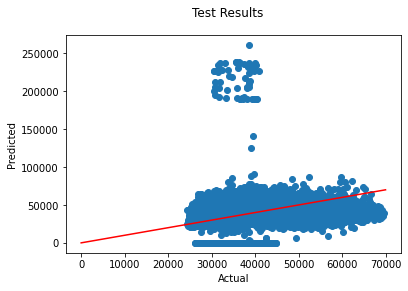

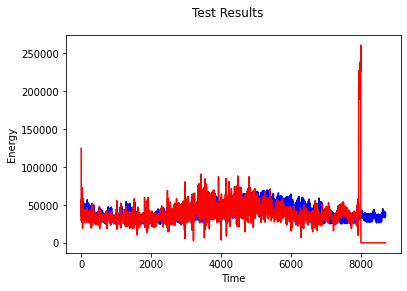

In [ ]:
# make a prediction on test data
M7_pred = model7.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M7_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M7_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M7_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-8

In [ ]:
# Model - 8

In [ ]:
trial

tmpf   dwpf    relh  ...     energy_10     energy_24           MWh
0      32.00  17.96   55.72  ...      0.000000      0.000000  28496.388850
1      33.08  19.04   55.89  ...      0.000000      0.000000  27662.443480
2      33.08  17.96   53.36  ...      0.000000      0.000000  27250.044715
3      32.00  19.04   58.37  ...      0.000000      0.000000  26783.226081
4      30.02  19.04   63.24  ...      0.000000      0.000000  26676.468490
...      ...    ...     ...  ...           ...           ...           ...
38218  21.02  19.94   95.51  ...  45762.516832  46211.545805  43800.794552
38219  21.02  19.94   95.51  ...  45642.143848  46134.627432  43800.794552
38220  21.02  21.02  100.00  ...  45347.221002  45984.979950  42055.295929
38221  21.20  21.20  100.00  ...  45062.196370  45791.838989  42055.295929
38222  21.02  21.02  100.00  ...  44777.171738  45598.698028  42055.295929

[38223 rows x 19 columns]

In [ ]:
trial2

tmpf   dwpf    relh  ...  2013_Avg_Demand  2014_Avg_Demand           MWh
0     21.02  21.02  100.00  ...         0.000000         0.000000  40707.660350
1     21.92  21.02   96.26  ...         0.000000         0.000000  39624.861027
2     21.92  21.02   96.26  ...     28166.309147     35706.164707  39013.544802
3     21.92  21.92  100.00  ...     27479.895092     35602.473788  38566.541927
4     21.92  21.92  100.00  ...     30729.856225     36783.891461  38488.338511
...     ...    ...     ...  ...              ...              ...           ...
8692  46.94  35.96   65.43  ...         0.000000         0.000000  40330.522636
8693  44.96  37.04   73.59  ...         0.000000         0.000000  39268.536567
8694  42.98  37.04   79.38  ...         0.000000         0.000000  38075.677924
8695  39.92  37.94   92.56  ...         0.000000         0.000000  36929.975190
8696  41.00  39.02   92.59  ...         0.000000         0.000000  35660.210526

[8697 rows x 19 columns]

In [ ]:
#trail4_train = trial[['tmpf','dwpf','relh','sknt','vsby','Hour','part_of_day','Month','Day','Weekend','MWh']]
trail4_train = trial[['tmpf','dwpf','relh','sknt','vsby','MWh']]

In [ ]:
#trail4_test = trial2[['tmpf','dwpf','relh','sknt','vsby','Hour','part_of_day','Month','Day','Weekend','MWh']]
trail4_test = trial2[['tmpf','dwpf','relh','sknt','vsby','MWh']]

In [ ]:
trail4_train

tmpf   dwpf    relh  sknt  vsby           MWh
0      32.00  17.96   55.72   8.0  10.0  28496.388850
1      33.08  19.04   55.89   7.0  10.0  27662.443480
2      33.08  17.96   53.36   9.0  10.0  27250.044715
3      32.00  19.04   58.37   7.0  10.0  26783.226081
4      30.02  19.04   63.24   7.0  10.0  26676.468490
...      ...    ...     ...   ...   ...           ...
38218  21.02  19.94   95.51   0.0  10.0  43800.794552
38219  21.02  19.94   95.51   3.0  10.0  43800.794552
38220  21.02  21.02  100.00   5.0  10.0  42055.295929
38221  21.20  21.20  100.00   3.0  10.0  42055.295929
38222  21.02  21.02  100.00   3.0  10.0  42055.295929

[38223 rows x 6 columns]

In [ ]:
trail4_test

tmpf   dwpf    relh  sknt   vsby           MWh
0     21.02  21.02  100.00   3.0  10.00  40707.660350
1     21.92  21.02   96.26   3.0   9.00  39624.861027
2     21.92  21.02   96.26   4.0   8.00  39013.544802
3     21.92  21.92  100.00   3.0   2.50  38566.541927
4     21.92  21.92  100.00   5.0   1.75  38488.338511
...     ...    ...     ...   ...    ...           ...
8692  46.94  35.96   65.43   6.0  10.00  40330.522636
8693  44.96  37.04   73.59   5.0  10.00  39268.536567
8694  42.98  37.04   79.38   4.0  10.00  38075.677924
8695  39.92  37.94   92.56   6.0   7.00  36929.975190
8696  41.00  39.02   92.59   7.0   7.00  35660.210526

[8697 rows x 6 columns]

In [ ]:
trail4_train.corr(method = "pearson")

tmpf      dwpf      relh      sknt      vsby       MWh
tmpf  1.000000  0.453107 -0.501309  0.181515  0.220501  0.507672
dwpf  0.453107  1.000000  0.472182  0.080327 -0.012755  0.301505
relh -0.501309  0.472182  1.000000 -0.113868 -0.322862 -0.182045
sknt  0.181515  0.080327 -0.113868  1.000000 -0.004992  0.073696
vsby  0.220501 -0.012755 -0.322862 -0.004992  1.000000  0.002955
MWh   0.507672  0.301505 -0.182045  0.073696  0.002955  1.000000

In [ ]:
#trail4_train['tmpf_5'] = trail4_train.iloc[:,0].rolling(window=504).mean()
trail4_train['dwpf_5'] = trail4_train.iloc[:,1].rolling(window=504).mean() # 3 week rolling average


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
trail4_test['dwpf_5'] = trail4_test.iloc[:,1].rolling(window=504).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
trail4_train.corr(method = "pearson")

tmpf      dwpf      relh      sknt      vsby       MWh    dwpf_5
tmpf    1.000000  0.453107 -0.501309  0.181515  0.220501  0.507672  0.557639
dwpf    0.453107  1.000000  0.472182  0.080327 -0.012755  0.301505  0.749428
relh   -0.501309  0.472182  1.000000 -0.113868 -0.322862 -0.182045  0.157692
sknt    0.181515  0.080327 -0.113868  1.000000 -0.004992  0.073696 -0.011374
vsby    0.220501 -0.012755 -0.322862 -0.004992  1.000000  0.002955  0.047035
MWh     0.507672  0.301505 -0.182045  0.073696  0.002955  1.000000  0.482740
dwpf_5  0.557639  0.749428  0.157692 -0.011374  0.047035  0.482740  1.000000

In [ ]:
trail4_test

tmpf   dwpf    relh  sknt   vsby           MWh     dwpf_5
0     21.02  21.02  100.00   3.0  10.00  40707.660350        NaN
1     21.92  21.02   96.26   3.0   9.00  39624.861027        NaN
2     21.92  21.02   96.26   4.0   8.00  39013.544802        NaN
3     21.92  21.92  100.00   3.0   2.50  38566.541927        NaN
4     21.92  21.92  100.00   5.0   1.75  38488.338511        NaN
...     ...    ...     ...   ...    ...           ...        ...
8692  46.94  35.96   65.43   6.0  10.00  40330.522636  29.662143
8693  44.96  37.04   73.59   5.0  10.00  39268.536567  29.666071
8694  42.98  37.04   79.38   4.0  10.00  38075.677924  29.670000
8695  39.92  37.94   92.56   6.0   7.00  36929.975190  29.681786
8696  41.00  39.02   92.59   7.0   7.00  35660.210526  29.695714

[8697 rows x 7 columns]

In [ ]:
# Moving target variable MWh to the last in the train data
trail4_train.insert(len(trail4_train.columns)-1, 'MWh', trail4_train.pop('MWh'))

In [ ]:
trail4_train.replace(np.nan, 0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
trail4_train

tmpf   dwpf    relh  sknt  vsby     dwpf_5           MWh
0      32.00  17.96   55.72   8.0  10.0   0.000000  28496.388850
1      33.08  19.04   55.89   7.0  10.0   0.000000  27662.443480
2      33.08  17.96   53.36   9.0  10.0   0.000000  27250.044715
3      32.00  19.04   58.37   7.0  10.0   0.000000  26783.226081
4      30.02  19.04   63.24   7.0  10.0   0.000000  26676.468490
...      ...    ...     ...   ...   ...        ...           ...
38218  21.02  19.94   95.51   0.0  10.0  29.042500  43800.794552
38219  21.02  19.94   95.51   3.0  10.0  29.032500  43800.794552
38220  21.02  21.02  100.00   5.0  10.0  29.026429  42055.295929
38221  21.20  21.20  100.00   3.0  10.0  29.018929  42055.295929
38222  21.02  21.02  100.00   3.0  10.0  29.011071  42055.295929

[38223 rows x 7 columns]

In [ ]:
# Normalize the variables

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
tmp = scaler.fit_transform(trail4_train.iloc[:,:-1])
#X_test = scaler.transform(X_test.iloc)

In [ ]:
tmp = pd.DataFrame(tmp)

In [ ]:
# Add the target variable back to tmp
tmp['MWh'] = trail4_train['MWh']

In [ ]:
trail4_train = tmp

In [ ]:
# store train as numpy array
trail4_train = np.array(trail4_train)

In [ ]:
n_steps = 3
raw_seq = np.array(trail4_train) #make sure your data is stored as a numpy array!
X, y = split_sequences(raw_seq, n_steps)

In [ ]:
# Converting  data type to float32
X = np.asarray(X).astype(np.float32)

In [ ]:
trail4_test

tmpf   dwpf    relh  sknt   vsby           MWh     dwpf_5
0     21.02  21.02  100.00   3.0  10.00  40707.660350        NaN
1     21.92  21.02   96.26   3.0   9.00  39624.861027        NaN
2     21.92  21.02   96.26   4.0   8.00  39013.544802        NaN
3     21.92  21.92  100.00   3.0   2.50  38566.541927        NaN
4     21.92  21.92  100.00   5.0   1.75  38488.338511        NaN
...     ...    ...     ...   ...    ...           ...        ...
8692  46.94  35.96   65.43   6.0  10.00  40330.522636  29.662143
8693  44.96  37.04   73.59   5.0  10.00  39268.536567  29.666071
8694  42.98  37.04   79.38   4.0  10.00  38075.677924  29.670000
8695  39.92  37.94   92.56   6.0   7.00  36929.975190  29.681786
8696  41.00  39.02   92.59   7.0   7.00  35660.210526  29.695714

[8697 rows x 7 columns]

In [ ]:
# Moving target variable MWh to the last in the test data
trail4_test.insert(len(trail4_test.columns)-1, 'MWh', trail4_test.pop('MWh'))

In [ ]:
trail4_test.replace(np.nan, 0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [ ]:
tmp_test = scaler.transform(trail4_test.iloc[:,:-1])

In [ ]:
tmp_test = pd.DataFrame(tmp_test)

In [ ]:
tmp_test['MWh'] = trail4_test['MWh']

In [ ]:
trail4_test = tmp_test

In [ ]:
trail4_test.head()

0         1        2         3         4    5           MWh
0  0.142367  0.470810  1.00000  0.053571  1.000000  0.0  40707.660350
1  0.150943  0.470810  0.96215  0.053571  0.990826  0.0  39624.861027
2  0.150943  0.470810  0.96215  0.071429  0.981651  0.0  39013.544802
3  0.150943  0.480226  1.00000  0.053571  0.931193  0.0  38566.541927
4  0.150943  0.480226  1.00000  0.089286  0.924312  0.0  38488.338511

In [ ]:
# store test as numpy array
trail4_test = np.array(trail4_test)

In [ ]:
n_steps = 3
raw_seq = np.array(trail4_test) #make sure your data is stored as a numpy array!
X_test, y_test = split_sequences(raw_seq, n_steps)

In [ ]:
# Converting  data type to float32
X_test = np.asarray(X_test).astype(np.float32)

In [ ]:
X_test.shape

(8695, 3, 6)

In [ ]:
X.shape

(38221, 3, 6)

In [ ]:
# Model-8
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model8 = Sequential()
model8.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu'))
model8.add(Dense(1))
model8.compile(optimizer='adam', loss='mse',metrics=['mae'])
model8.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model8.fit(X, y,
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 30)                1110      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 31        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6116/6116 [==============================] - 17s 3ms/step - loss: 434892221.8839 - mae: 14844.8435 - val_loss: 53481052.0000 - val_mae: 5895.4268
Epoch 2/100
6116/6116 [==============================] - 17s 3ms/step - loss: 64418769.8447 - mae: 6363.0624 - val_loss: 51732492.0000 - val_mae: 5833.9932
Epoch 3/100
6116/6116 [==============================] - 16s 3ms/step - loss: 62731180.3616 - mae: 6330.6960 - val_loss: 51543968.0000 - val_mae: 5809.0376
Epoch 4/100
6116/6116 [====================

MAE:  3932.2312813008402


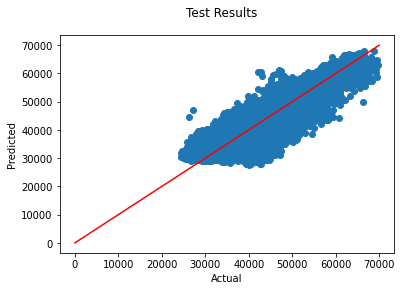

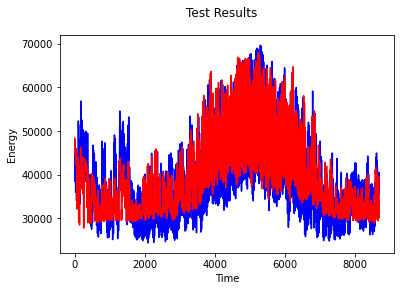

In [ ]:
# make a prediction on test data
M8_pred = model8.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M8_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M8_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M8_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-9

In [ ]:
#trail4_train = trial[['tmpf','dwpf','relh','sknt','vsby','Hour','part_of_day','Month','Day','Weekend','MWh']]
trail4_train = trial[['tmpf','dwpf','relh','sknt','vsby','MWh']]

In [ ]:
#trail4_test = trial2[['tmpf','dwpf','relh','sknt','vsby','Hour','part_of_day','Month','Day','Weekend','MWh']]
trail4_test = trial2[['tmpf','dwpf','relh','sknt','vsby','MWh']]

In [ ]:
trail4_train['dwpf_5'] = trail4_train.iloc[:,1].rolling(window=504).mean() # 3 week rolling average

In [ ]:
# Model-9
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model9 = Sequential()
#model9.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu', return_sequences = True, recurrent_dropout=0.01))
model9.add(GRU(15, input_shape=(n_steps,n_features), return_sequences = True, activation='linear', recurrent_dropout=0.01))
model9.add(LSTM(8,activation = "linear"))
model9.add(Dense(1))
model9.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model9.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model9.fit(X, y,
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 3, 15)             1035      
_________________________________________________________________
lstm_16 (LSTM)               (None, 8)                 768       
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 9         
Total params: 1,812
Trainable params: 1,812
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6116/6116 [==============================] - 44s 7ms/step - loss: 295631560.8985 - mae: 11778.7241 - val_loss: 51605752.0000 - val_mae: 5846.4575
Epoch 2/100
6116/6116 [==============================] - 40s 7ms/step - loss: 63086881.1849 - mae: 6316.0222 - val_loss: 50888716.0000 - val_mae: 5888.3408
Epoch 3/100
6116/6116 [==============================] - 42s 7ms/st

MAE:  3614.0861509249244


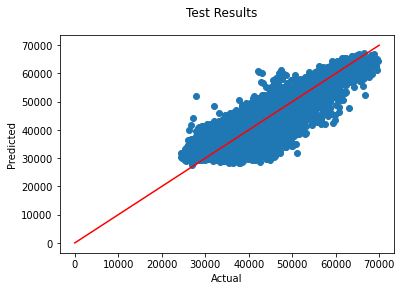

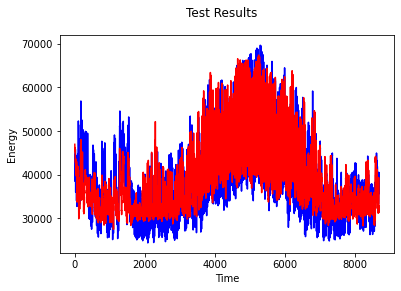

In [ ]:
# make a prediction on test data
M9_pred = model9.predict(X_test)# the pred

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M9_pred))

actual = y_test # the actual
plt.scatter(x=actual, y=M9_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 7000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M9_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-11

In [ ]:
# Define the model
# define model
model11 = Sequential()
# remember - convolution does elementwise multiplication and pooling!
model11.add(Conv1D(filters=128, # these are the new columns that will be created (YOU GET TO PICK THIS!)
                 kernel_size=2, # this dictates the size of the modified lookback (YOU GET TO PICK THIS!)
                 input_shape=(n_steps,n_features))) # notice how input shape goes in first layer
model11.add(MaxPooling1D(2))
model11.add(GRU(100, activation='relu', return_sequences=True))
model11.add(GRU(50, activation='relu'))
model11.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model11.compile(optimizer=opt, loss='mse',metrics=['mae'])
model11.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model11.fit(X, y,
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 2, 128)            5760      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
gru_26 (GRU)                 (None, 1, 100)            69000     
_________________________________________________________________
gru_27 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 97,611
Trainable params: 97,611
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6116/6116 [==============================] - 29s 4ms/step - loss: 450259352.9351 - mae: 15371.9708 - va

MAE:  2970.0590390221


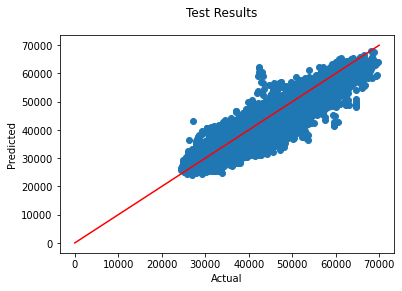

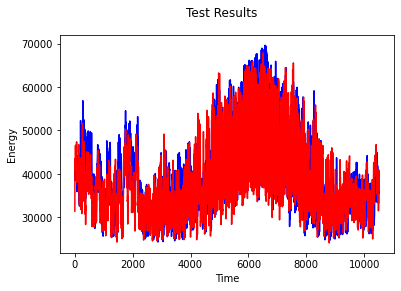

In [ ]:
# make a prediction on test data
M11_pred = model11.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M11_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M11_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M11_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-12

In [ ]:
# Model-12
from tensorflow import keras
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model12 = Sequential()
model12.add(GRU(200, input_shape=(n_steps,n_features), return_sequences = True, activation='relu', recurrent_dropout=0.01))
model12.add(GRU(100, return_sequences = True, activation = "relu", recurrent_dropout=0.01))
model12.add(GRU(50, activation = "relu", recurrent_dropout=0.001))
model12.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model12.compile(optimizer= opt, loss='mse',metrics=['mae'])
model12.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model12.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 3, 200)            134400    
_________________________________________________________________
gru_29 (GRU)                 (None, 3, 100)            90600     
_________________________________________________________________
gru_30 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 247,851
Trainable params: 247,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6116/6116 [==============================] - 140s 22ms/step - loss: 304233202.8223 - mae: 11749.5148 - val_loss: 24369048.0000 - val_mae: 3870.4089
Epoch 2/100
6116/6116 [==============================] - 129s 21ms/step - loss: 28163

MAE:  2951.8122984487645


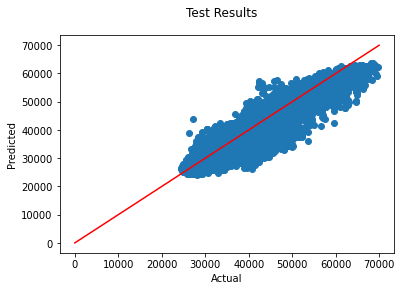

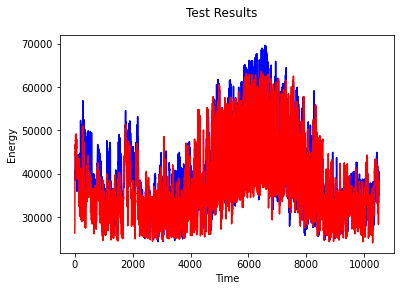

In [ ]:
# make a prediction on test data
M12_pred = model12.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M12_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M12_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M12_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M12_pred_df = pd.DataFrame(M12_pred)
M12_pred_df.to_csv("M12_predictions")

## Model-13

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model13 = Sequential()
model13.add(LSTM(100, input_shape=(n_steps,n_features), return_sequences = True, activation='relu', recurrent_dropout=0.5))
model13.add(LSTM(50, return_sequences = True, activation = "relu", recurrent_dropout=0.1))
model13.add(LSTM(25, activation = "relu", recurrent_dropout=0.1))
model13.add(Dense(1))
model13.compile(optimizer='adam', loss='mse',metrics=['mae'])
model13.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model13.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=1000,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            43600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 50)             30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 81,426
Trainable params: 81,426
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
5351/5351 [==============================] - 68s 12ms/step - loss: 180655423.2167 - mae: 9259.6995 - val_loss: 35538916.0000 - val_mae: 4608.0430
Epoch 2/1000
5351/5351 [==============================] - 62s 12ms/step - loss: 36577506.88

MAE:  3100.428553519055


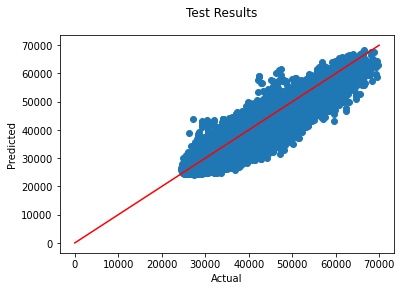

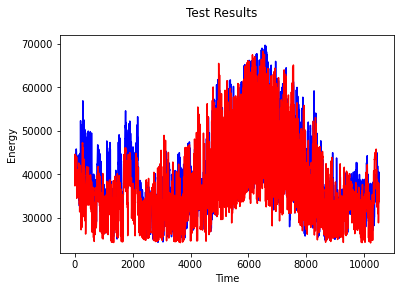

In [ ]:
# make a prediction on test data
M13_pred = model13.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M13_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M13_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M13_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M13_pred_df = pd.DataFrame(M13_pred)
M13_pred_df.to_csv("M13_predictions")

## Model-14

In [ ]:
# Model-14

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model14 = Sequential()
model14.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu'))
model14.add(Dense(1))
model14.compile(optimizer='adam', loss='mse',metrics=['mae'])
model14.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model14.fit(X, y,
          epochs=500,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 30)                1590      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 31        
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
6116/6116 [==============================] - 14s 2ms/step - loss: 174732529.7185 - mae: 9150.7278 - val_loss: 36385044.0000 - val_mae: 4648.8848
Epoch 2/500
6116/6116 [==============================] - 13s 2ms/step - loss: 31439000.6967 - mae: 4369.8502 - val_loss: 19345908.0000 - val_mae: 3363.7834
Epoch 3/500
6116/6116 [==============================] - 13s 2ms/step - loss: 20651407.2627 - mae: 3566.8079 - val_loss: 17721412.0000 - val_mae: 3238.9685
Epoch 4/500
6116/6116 [=====================

MAE:  2731.0531523052136


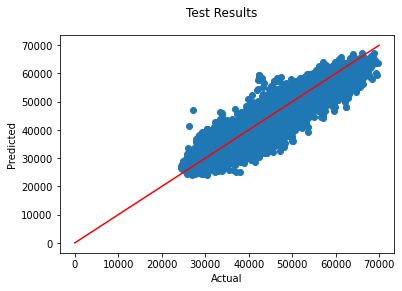

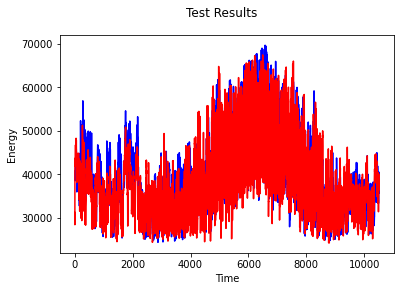

In [ ]:
# make a prediction on test data
M14_pred = model14.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M14_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M14_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M14_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M14_pred_df = pd.DataFrame(M14_pred)
M14_pred_df.to_csv("M14_predictions")

## Model-15

In [ ]:
# Model-15

n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model15 = Sequential()
model15.add(LSTM(30, input_shape=(n_steps,n_features), activation='relu'))
model15.add(Dense(1))
model15.compile(optimizer='adam', loss='mse',metrics=['mae'])
model15.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model15.fit(X, y,
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30)                6360      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 31        
Total params: 6,391
Trainable params: 6,391
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 17s 3ms/step - loss: 259034608.6682 - mae: 11010.2500 - val_loss: 65237420.0000 - val_mae: 6418.7778
Epoch 2/500
5351/5351 [==============================] - 16s 3ms/step - loss: 49433221.4761 - mae: 5543.7881 - val_loss: 43843880.0000 - val_mae: 5052.5063
Epoch 3/500
5351/5351 [==============================] - 16s 3ms/step - loss: 28424364.9077 - mae: 4144.2518 - val_loss: 27001392.0000 - val_mae: 3883.8057
Epoch 4/500
5351/5351 [====================

MAE:  2895.7376689729795


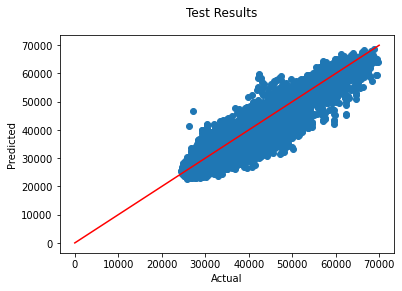

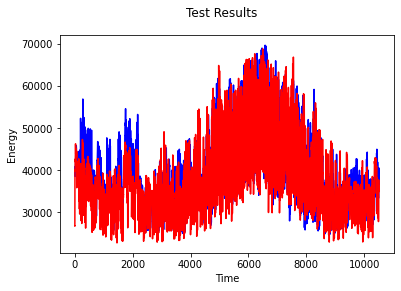

In [ ]:
# make a prediction on test data
M15_pred = model15.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M15_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M15_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M15_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Model-16

In [ ]:
# Standardize and try - Normalizing the variables

In [ ]:
# Model-16

n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model16 = Sequential()
model16.add(LSTM(100, input_shape=(n_steps,n_features), return_sequences=True, activation='relu'))
model16.add(SimpleRNN(30, activation='relu'))
model16.add(Dense(1))
model16.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model16.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model16.fit(X, y,
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 3, 100)            49200     
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 30)                3930      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 31        
Total params: 53,161
Trainable params: 53,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 26s 4ms/step - loss: 143419016.3565 - mae: 8173.3764 - val_loss: 24619952.0000 - val_mae: 3827.3071
Epoch 2/500
5351/5351 [==============================] - 23s 4ms/step - loss: 20703195.8857 - mae: 3574.2193 - val_loss: 30356182.0000 - val_mae: 4238.4937
Epoch 3/500
5351/5351 [==============================] - 24s 4ms/s

MAE:  2934.752876273984


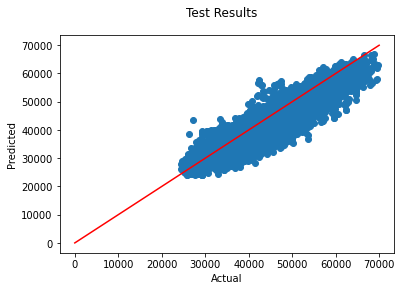

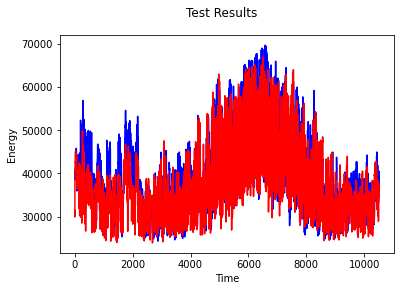

In [ ]:
# make a prediction on test data
M16_pred = model16.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M16_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M16_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M16_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
df_subset # train data

sknt  vsby    mslp  skyc1  tmpf_5  dwpf_5  relh_5  Hour           MWh
0       8.0  10.0  1015.5      2   0.000   0.000   0.000     0  28496.388850
1       7.0  10.0  1015.6      2   0.000   0.000   0.000     1  27662.443480
2       9.0  10.0  1016.2      2   0.000   0.000   0.000     2  27250.044715
3       7.0  10.0  1016.6      2   0.000   0.000   0.000     3  26783.226081
4       7.0  10.0  1017.2      2  32.036  18.608  57.316     4  26676.468490
...     ...   ...     ...    ...     ...     ...     ...   ...           ...
38218   0.0  10.0  1028.0      4  20.588  19.940  97.306    22  43800.794552
38219   3.0  10.0  1027.8      4  20.804  19.940  96.408    22  43800.794552
38220   5.0  10.0  1027.8      4  21.020  20.156  96.408    23  42055.295929
38221   3.0  10.0  1027.8      4  21.056  20.408  97.306    23  42055.295929
38222   3.0  10.0  1027.2      4  21.056  20.624  98.204    23  42055.295929

[38223 rows x 9 columns]

In [ ]:
df_test # test data

sknt    mslp  skyc1  tmpf_5  dwpf_5    relh   feel  Hour           MWh
0       3.0  1026.4      3   0.000   0.000  100.00  16.14     0  40707.660350
1       0.0  1026.4      3   0.000   0.000  100.00  21.02     0  40707.660350
2       5.0  1026.4      3   0.000   0.000  100.00  13.36     0  40707.660350
3       3.0  1026.0      3   0.000   0.000   96.26  17.17     1  39624.861027
4       4.0  1026.0      3  21.380  21.020   96.26  15.65     2  39013.544802
...     ...     ...    ...     ...     ...     ...    ...   ...           ...
10515   6.0  1024.8      4  44.348  37.184   92.56  35.07    22  36929.975190
10516   5.0  1024.8      0  42.944  37.184   92.56  35.80    22  36929.975190
10517   4.0  1026.1      3  41.540  37.796   96.55  36.67    22  36929.975190
10518   7.0  1026.1      4  40.748  38.192   92.59  35.75    23  35660.210526
10519   9.0  1026.6      0  40.136  38.372   92.56  33.36    23  35660.210526

[10520 rows x 9 columns]

## Model-17

(array([1029., 2974., 4625., 8828., 7121., 4720., 3333., 2741., 2084.,
         768.]),
 array([10.01529786, 10.12696045, 10.23862304, 10.35028562, 10.46194821,
        10.57361079, 10.68527338, 10.79693596, 10.90859855, 11.02026114,
        11.13192372]),
 <a list of 10 Patch objects>)

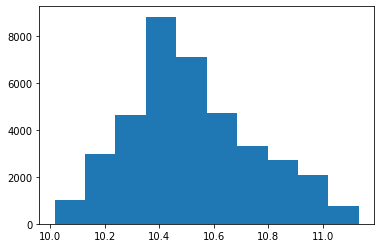

In [ ]:
plt.hist(np.log(df_subset['MWh']))

In [ ]:
# Normalizing the input data + log transforming the target variable
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Normalizing without the target column
scaler = MinMaxScaler()
tmp = scaler.fit_transform(df_subset.iloc[:,:-1])
#X_test = scaler.transform(X_test.iloc)

In [ ]:
tmp = pd.DataFrame(tmp)

In [ ]:
# Add the target variable back to tmp
tmp['MWh'] = np.log(df_subset['MWh'])

In [ ]:
train_sub = tmp

In [ ]:
# store train as numpy array
train = np.array(train_sub)

In [ ]:
n_steps = 3
raw_seq = np.array(train) #make sure your data is stored as a numpy array!
X, y = split_sequences(raw_seq, n_steps)

In [ ]:
tmp_test = scaler.transform(df_test.iloc[:,:-1])

In [ ]:
tmp_test = pd.DataFrame(tmp_test)

In [ ]:
tmp_test['MWh'] = np.log(df_test['MWh'])

In [ ]:
test_sub = tmp_test

(array([ 365.,  804., 1309., 2316., 1973., 1400.,  942.,  686.,  519.,
         206.]),
 array([10.09977231, 10.20487638, 10.30998045, 10.41508452, 10.52018859,
        10.62529266, 10.73039673, 10.8355008 , 10.94060487, 11.04570895,
        11.15081302]),
 <a list of 10 Patch objects>)

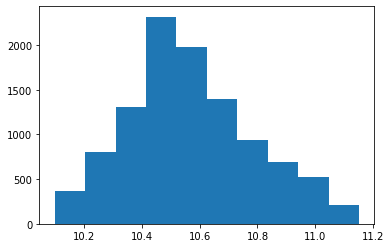

In [ ]:
plt.hist(test_sub['MWh'])

In [ ]:
# store test as numpy array
test = np.array(test_sub)

In [ ]:
n_steps = 3
raw_seq = np.array(test) #make sure your data is stored as a numpy array!
X_test, y_test = split_sequences(raw_seq, n_steps)

In [ ]:
# Model-17
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model17= Sequential()
model17.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation='relu'))
#model17.add(GRU(15, activation = "linear", recurrent_dropout=0.01))
model17.add(Dense(1))
model17.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model17.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model17.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_19 (SimpleRNN)    (None, 30)                1590      
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 31        
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 14s 2ms/step - loss: 4.5863 - mae: 0.7813 - val_loss: 0.0206 - val_mae: 0.1084
Epoch 2/500
5351/5351 [==============================] - 13s 3ms/step - loss: 0.0194 - mae: 0.1070 - val_loss: 0.0165 - val_mae: 0.0971
Epoch 3/500
5351/5351 [==============================] - 13s 2ms/step - loss: 0.0180 - mae: 0.0998 - val_loss: 0.0146 - val_mae: 0.0952
Epoch 4/500
5351/5351 [==============================] - 13s 2ms/step - loss: 0.0152 - mae: 0.0940 - val_

MAE:  2680.472471174462


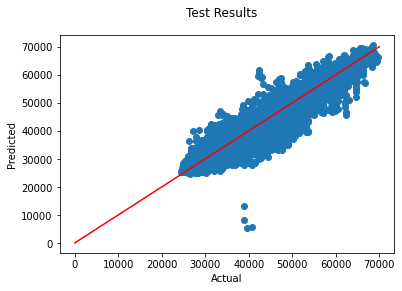

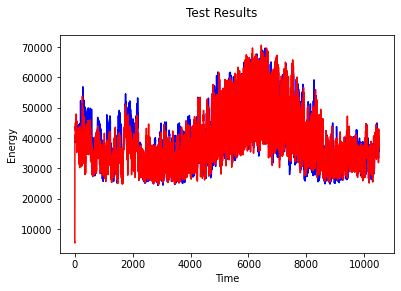

In [ ]:
# make a prediction on test data
M17_pred = model17.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M17_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M17_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M17_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M17_pred_df = pd.DataFrame(M17_pred)
M17_pred_df.to_csv("M17_predictions")

## Model-18

In [ ]:
# Model-18
n_features = X.shape[2]
n_steps = X.shape[1]

from keras.layers import Bidirectional
# define model
model18= Sequential()
model18.add(Bidirectional(SimpleRNN(30, activation='relu'),input_shape=(n_steps,n_features)))
#model17.add(GRU(15, activation = "linear", recurrent_dropout=0.01))
model18.add(Dense(1))
model18.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model18.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model18.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 60)                3180      
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 61        
Total params: 3,241
Trainable params: 3,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 18s 3ms/step - loss: 2.4631 - mae: 0.5498 - val_loss: 0.0324 - val_mae: 0.1476
Epoch 2/500
5351/5351 [==============================] - 16s 3ms/step - loss: 0.0216 - mae: 0.1078 - val_loss: 0.0325 - val_mae: 0.1408
Epoch 3/500
5351/5351 [==============================] - 16s 3ms/step - loss: 0.0163 - mae: 0.0963 - val_loss: 0.0249 - val_mae: 0.1220
Epoch 4/500
5351/5351 [==============================] - 16s 3ms/step - loss: 0.0141 - mae: 0.0928 - val_

MAE:  2561.3244990242274


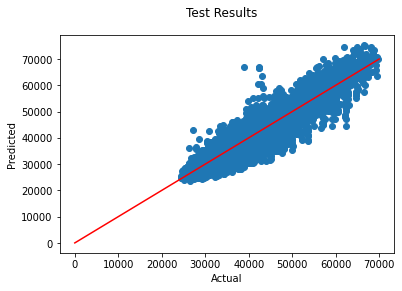

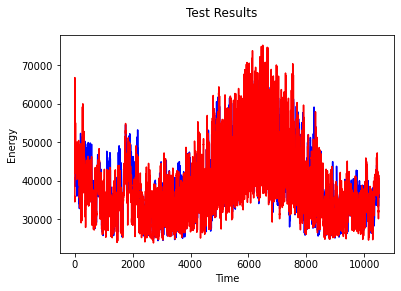

In [ ]:
# make a prediction on test data
M18_pred = model18.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M18_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M18_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M18_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M18_pred_df = pd.DataFrame(M18_pred)
M18_pred_df.to_csv("M18_predictions.csv")

## Model-19


In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

from keras.layers import Bidirectional
# define model
model19= Sequential()
model19.add(Bidirectional(GRU(30, activation='relu'),input_shape=(n_steps,n_features)))
#model17.add(GRU(15, activation = "linear", recurrent_dropout=0.01))
model19.add(Dense(1))
model19.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model19.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model19.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 60)                9720      
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 61        
Total params: 9,781
Trainable params: 9,781
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 25s 4ms/step - loss: 3.6116 - mae: 0.6834 - val_loss: 0.0237 - val_mae: 0.1198
Epoch 2/500
5351/5351 [==============================] - 22s 4ms/step - loss: 0.0185 - mae: 0.1031 - val_loss: 0.0185 - val_mae: 0.1097
Epoch 3/500
5351/5351 [==============================] - 22s 4ms/step - loss: 0.0124 - mae: 0.0868 - val_loss: 0.0205 - val_mae: 0.1076
Epoch 4/500
5351/5351 [==============================] - 22s 4ms/step - loss: 0.0114 - mae: 0.0837 - val_

MAE:  2529.6539599458033


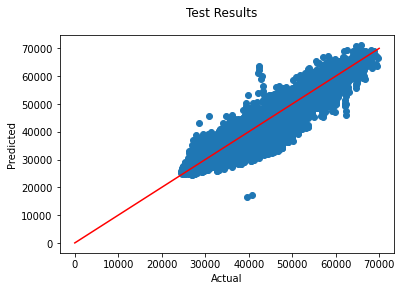

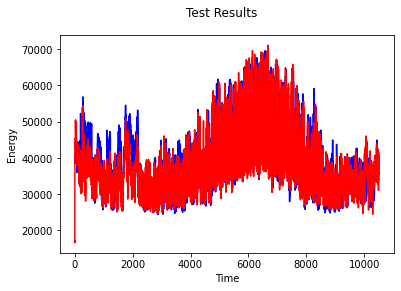

In [ ]:
# make a prediction on test data
M19_pred = model19.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M19_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M19_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M19_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M19_pred_df = pd.DataFrame(M19_pred)
M19_pred_df.to_csv("M19_predictions.csv")

## Model-20

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

from keras.layers import Bidirectional
# define model
model20= Sequential()
model20.add(Bidirectional(GRU(50, activation='relu'),input_shape=(n_steps,n_features)))
#model17.add(GRU(15, activation = "linear", recurrent_dropout=0.01))
model20.add(Dense(1))
model20.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model20.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model20.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 100)               22200     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 101       
Total params: 22,301
Trainable params: 22,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 26s 4ms/step - loss: 3.6051 - mae: 0.6627 - val_loss: 0.0169 - val_mae: 0.0972
Epoch 2/500
5351/5351 [==============================] - 24s 4ms/step - loss: 0.0208 - mae: 0.1035 - val_loss: 0.0333 - val_mae: 0.1601
Epoch 3/500
5351/5351 [==============================] - 23s 4ms/step - loss: 0.0130 - mae: 0.0889 - val_loss: 0.0357 - val_mae: 0.1676
Epoch 4/500
5351/5351 [==============================] - 23s 4ms/step - loss: 0.0117 - mae: 0.0847 - va

MAE:  2641.180605558257


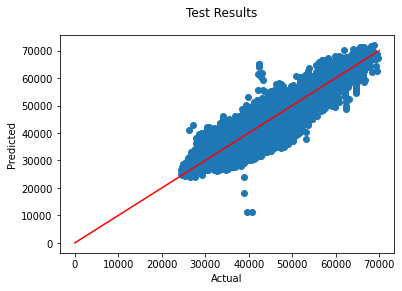

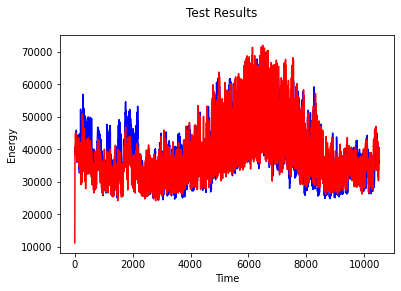

In [ ]:
# make a prediction on test data
M20_pred = model20.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M20_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M20_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M20_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M20_pred_df = pd.DataFrame(M20_pred)
M20_pred_df.to_csv("M20_predictions.csv")

## Model-21

In [ ]:
# Stacked Bidirectional

model21 = Sequential()
model21.add(Bidirectional(SimpleRNN(30, activation='relu', return_sequences=True),
                        input_shape=(n_steps,n_features)))
model21.add(Bidirectional(SimpleRNN(10, activation='relu')))
model21.add(Dropout(0.1)) # pick a number between 0.1 and 0.3
model21.add(Dense(1))
model21.compile(optimizer='adam', loss='mse',metrics=['mae'])
model21.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model21.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 3, 60)             3180      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 20)                1420      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 21        
Total params: 4,621
Trainable params: 4,621
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 27s 5ms/step - loss: 3.8656 - mae: 1.2515 - val_loss: 0.2375 - val_mae: 0.4574
Epoch 2/500
5351/5351 [==============================] - 23s 4ms/step - loss: 1.1747 - mae: 0.8603 - val_loss: 0.

MAE:  2906.1431876330594


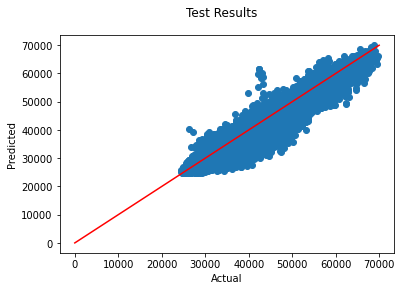

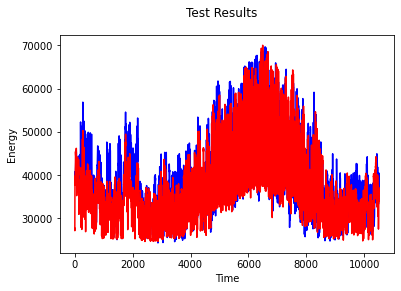

In [ ]:
# make a prediction on test data
M21_pred = model21.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M21_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M21_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M21_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M21_pred_df = pd.DataFrame(M21_pred)
M21_pred_df.to_csv("M21_predictions.csv")

## Model-22

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

from keras.layers import Bidirectional
# define model
model22= Sequential()
model22.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation = "relu", return_sequences = True, recurrent_dropout=0.01))
model22.add(Bidirectional(GRU(30)))
model22.add(Dense(1))
model22.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model22.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model22.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_25 (SimpleRNN)    (None, 3, 30)             1590      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60)                11160     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 61        
Total params: 12,811
Trainable params: 12,811
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
5351/5351 [==============================] - 32s 5ms/step - loss: 3.7657 - mae: 0.5757 - val_loss: 0.0143 - val_mae: 0.0916
Epoch 2/500
5351/5351 [==============================] - 28s 5ms/step - loss: 0.0113 - mae: 0.0841 - val_loss: 0.0144 - val_mae: 0.0925
Epoch 3/500
5351/5351 [==============================] - 28s 5ms/step - loss: 0.0085 - mae: 0.0729 - val_lo

MAE:  2794.5462558677946


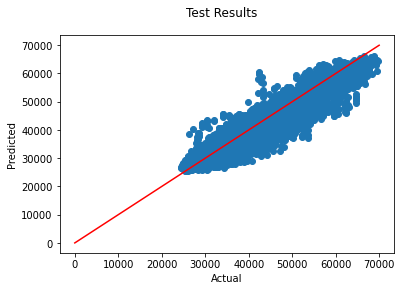

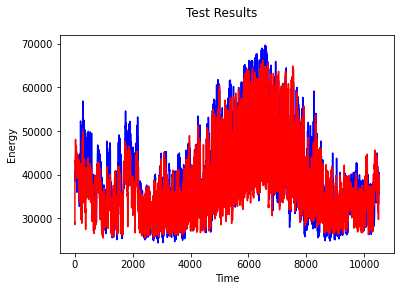

In [ ]:
# make a prediction on test data
M22_pred = model22.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M22_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M22_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M22_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M22_pred_df = pd.DataFrame(M22_pred)
M22_pred_df.to_csv("M22_predictions.csv")

## Model-23

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

from keras.layers import Bidirectional
# define model
model23= Sequential()
model23.add(SimpleRNN(30, input_shape=(n_steps,n_features), activation = "relu", return_sequences = True, recurrent_dropout=0.01))
model23.add(SimpleRNN(30, return_sequences=True, activation="relu"))
model23.add(Dropout(0.2))
model23.add(SimpleRNN(30))
model23.add(Dropout(0.2))
model23.add(Dense(1))
model23.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model23.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model23.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_32 (SimpleRNN)    (None, 3, 30)             1590      
_________________________________________________________________
simple_rnn_33 (SimpleRNN)    (None, 3, 30)             1830      
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 30)             0         
_________________________________________________________________
simple_rnn_34 (SimpleRNN)    (None, 30)                1830      
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 31        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
___________________________________________________

MAE:  2992.167506799663


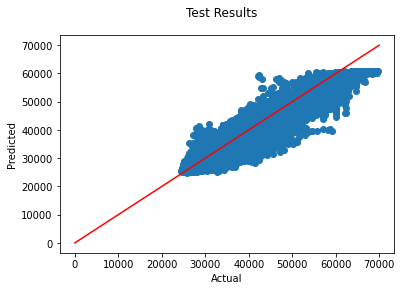

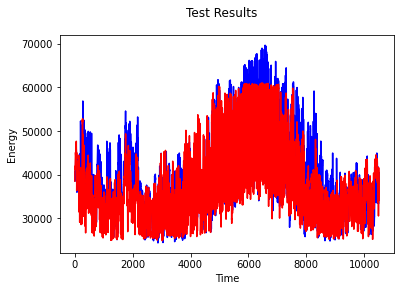

In [ ]:
# make a prediction on test data
M23_pred = model23.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M23_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M23_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M23_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M23_pred_df = pd.DataFrame(M23_pred)
M23_pred_df.to_csv("M23_predictions.csv")

## Model-24

In [ ]:
n_features = X.shape[2]
n_steps = X.shape[1]

from keras.layers import Bidirectional
# define model
model24= Sequential()
model24.add(LSTM(50, input_shape=(n_steps,n_features), activation = "relu", return_sequences = True, recurrent_dropout=0.01))
model24.add(LSTM(50, return_sequences=True, activation="relu"))
model24.add(Dropout(0.2))
model24.add(LSTM(50))
model24.add(Dropout(0.2))
model24.add(Dense(1))
model24.compile(optimizer='Adam', loss='mse',metrics=['mae'])
model24.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model24.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=500,
          batch_size=5,
          validation_split=0.3, # val is a random 30% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 3, 50)             14600     
_________________________________________________________________
lstm_15 (LSTM)               (None, 3, 50)             20200     
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 50)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 51        
Total params: 55,051
Trainable params: 55,051
Non-trainable params: 0
_________________________________________________

MAE:  2657.068112407609


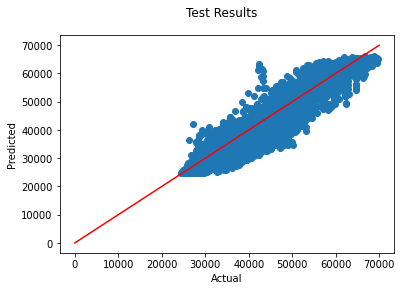

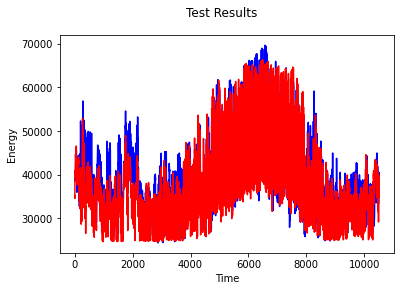

In [ ]:
# make a prediction on test data
M24_pred = model24.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(np.exp(y_test), np.exp(M24_pred)))

actual = np.exp(y_test) # the actual value of "y"
plt.scatter(x=actual, y=np.exp(M24_pred))
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), np.exp(y_test), color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), np.exp(M24_pred), color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

In [ ]:
M24_pred_df = pd.DataFrame(M24_pred)
M24_pred_df.to_csv("M24_predictions.csv")

## Model-25

In [ ]:
# Model-25
from tensorflow import keras
n_features = X.shape[2]
n_steps = X.shape[1]

# define model
model25 = Sequential()
model25.add(GRU(100, input_shape=(n_steps,n_features), return_sequences = True, activation='relu', recurrent_dropout=0.001))
model25.add(GRU(50, return_sequences = True, activation = "relu", recurrent_dropout=0.001))
model25.add(GRU(25, activation = "relu", recurrent_dropout=0.01))
model25.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.001)
model25.compile(optimizer= opt, loss='mse',metrics=['mae'])
model25.summary()

es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)

# fit model (uses early stopping)
model25.fit(X, y, # using X_train and y_train data here to fit the model
          epochs=100,
          batch_size=5,
          validation_split=0.2, # val is a random 20% of the data since we set shuffle = True
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 3, 100)            37200     
_________________________________________________________________
gru_22 (GRU)                 (None, 3, 50)             22800     
_________________________________________________________________
gru_23 (GRU)                 (None, 25)                5775      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 26        
Total params: 65,801
Trainable params: 65,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6116/6116 [==============================] - 78s 12ms/step - loss: 153223017.7669 - mae: 8467.1968 - val_loss: 21868076.0000 - val_mae: 3648.7893
Epoch 2/100
6116/6116 [==============================] - 70s 11ms/step - loss: 23659974.31

MAE:  3080.72250835736


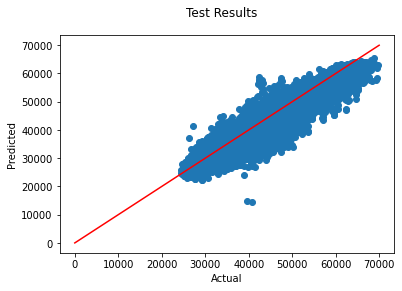

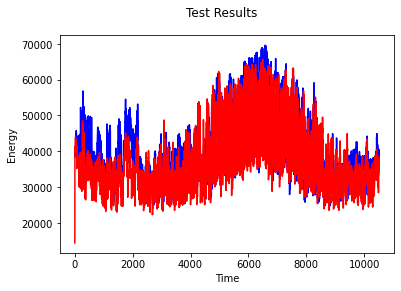

In [ ]:
# make a prediction on test data
M25_pred = model25.predict(X_test) # making predictions on the X_test data

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(y_test, M25_pred))

actual = y_test # the actual value of "y"
plt.scatter(x=actual, y=M25_pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks good!

# Timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), M25_pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.show()

## Baseline Model

In [ ]:
# Baseline Model

In [ ]:
#baseline model - prediction is just the previous time step
base_test = ercot_data_test
base_test['Baseline'] = base_test['MWh'].shift(1)
base_test.head()

Date   tmpf   dwpf  ...  Weekend           MWh      Baseline
0 2015-01-01 00:00:00  21.02  21.02  ...        0  40707.660350           NaN
1 2015-01-01 00:00:00  21.02  21.02  ...        0  40707.660350  40707.660350
2 2015-01-01 00:00:00  21.02  21.02  ...        0  40707.660350  40707.660350
3 2015-01-01 01:00:00  21.92  21.02  ...        0  39624.861027  40707.660350
4 2015-01-01 02:00:00  21.92  21.02  ...        0  39013.544802  39624.861027

[5 rows x 18 columns]

In [ ]:
y_test_baseline = base_test['Baseline'].tail(base_test.shape[0])
y_test_baseline

0                 NaN
1        40707.660350
2        40707.660350
3        40707.660350
4        39624.861027
             ...     
10515    38075.677924
10516    36929.975190
10517    36929.975190
10518    36929.975190
10519    35660.210526
Name: Baseline, Length: 10520, dtype: float64

MAE:  1199.6804114699657


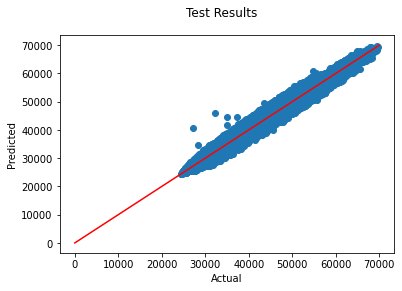

In [ ]:
# show scatterplots of actual vs. predicted for train and test
# make a prediction
pred = y_test_baseline # the pred
actual = base_test['MWh'] # the actual

# Removing first row with NaN
pred = y_test_baseline[1:]
actual = actual[1:]

# calculate MSE for the baseline model
from sklearn.metrics import mean_absolute_error
print('MAE: ', mean_absolute_error(actual, pred))

plt.scatter(x=actual, y=pred)
x = np.linspace(0,70000) # 45 degree line from 0 to 70000
plt.plot(x, x, color='red')
plt.suptitle('Test Results')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()
# looks pretty good!

In [ ]:
# Baseline Model shows MAE of 1199, which our models should beat!
# Model-10 beats it, but its not reproducible because of the random weight intialization.